In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import matplotlib.colors as mcolors
import anndata as ad
import seaborn as sns

In [4]:
# CLL-map tables - 
# import into your code as module with "import config_cllmap_tables"
# import config_cllmap_tables
# and then save the tables as variables, for example
# master_table = config_cllmap_tables.master_table

path = "/private/resources/"

# expression data
tpms_603samps_deseqLog10_batchcorr = pd.read_csv(path + "cll_tables/cllmap_rnaseq_tpms_603samps_deseqLog10_batchcorr.tsv", sep="\t")
cllmap_rnaseq_tpms_full = pd.read_csv(path + "cll_tables/cllmap_rnaseq_tpms_full.tsv", sep="\t")


In [5]:
cllmap_rnaseq_tpms_full.shape

(57242, 717)

In [6]:
df = cllmap_rnaseq_tpms_full


# The first two columns are used for `var`
var = df.iloc[:, :2].set_index('Description')

# The remaining columns are used for `obs`
obs = pd.DataFrame(index=df.columns[2:])

# The data matrix is the remaining part of the DataFrame, transposed
X = df.iloc[:, 2:].values.T

# Create the AnnData object with the data matrix, `obs`, and `var`
adata = sc.AnnData(X=X, obs=obs, var=var)

/data01/home/ls/sarahl/miniforge3/envs/proj/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata

AnnData object with n_obs × n_vars = 715 × 57242
    var: 'Name'

In [8]:
descriptions_to_keep = [
'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
'ZNF471', 'KCNH2', 'COBLL1', 'SEPT10', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2']
print(len(descriptions_to_keep))

# Find duplicates
duplicates = [item for item in set(descriptions_to_keep) if descriptions_to_keep.count(item) > 1]

# Print duplicates
print("Duplicates:", duplicates)

# Filter the var DataFrame to retain only the rows with the desired descriptions
filtered_var = adata.var[adata.var.index.isin(descriptions_to_keep)]

# Subset the AnnData object using the filtered var DataFrame
adata_filtered = adata[:, adata.var.index.isin(descriptions_to_keep)]

77
Duplicates: []


In [9]:
master_table = pd.read_csv(path + "cll_tables/cllmap_master_table.20220622.tsv", sep="\t")

In [10]:
ec_table = master_table[["participant_id", "ec_name"]]

In [11]:
ec_table

participant_id ec_name
0          CRC-0001   EC-u1
1          CRC-0002   EC-u1
2          CRC-0003   EC-u2
3          CRC-0004   EC-m4
4          CRC-0005   EC-u2
...             ...     ...
1171           MBL5     NaN
1172           MBL6     NaN
1173           MBL7     NaN
1174           MBL8     NaN
1175           MBL9     NaN

[1176 rows x 2 columns]

In [12]:
ec_table = ec_table[ec_table['participant_id'].isin(adata_filtered.obs.index)]

In [13]:
ec_table

participant_id ec_name
0          CRC-0001   EC-u1
1          CRC-0002   EC-u1
2          CRC-0003   EC-u2
3          CRC-0004   EC-m4
4          CRC-0005   EC-u2
...             ...     ...
1148      SCLL-0501     NaN
1149      SCLL-0502   EC-m4
1150      SCLL-0503   EC-m1
1151      SCLL-0504   EC-u1
1152      SCLL-0505   EC-u2

[715 rows x 2 columns]

In [14]:

filtered_ec_table = ec_table[ec_table['participant_id'].isin(adata_filtered.obs.index)]
filtered_ec_table = filtered_ec_table.dropna(subset=['ec_name'])
adata_filtered = adata_filtered[filtered_ec_table['participant_id'].values].copy()

print(filtered_ec_table)

# Define a function to split the AnnData object based on EC type
def split_anndata_by_ec(adata, ec_table):
    ec_types = ec_table['ec_name'].dropna().unique()  # Get unique EC types
    adata_dict = {}  # Dictionary to store the split AnnData objects

    for ec_type in ec_types:
        samples = ec_table[ec_table['ec_name'] == ec_type]['participant_id']
        adata_subset = adata[samples, :].copy()  # Subset AnnData based on sampleIDs
        adata_dict[ec_type] = adata_subset

    return adata_dict

# Split the filtered AnnData object
adata_dict = split_anndata_by_ec(adata_filtered, filtered_ec_table)

# Verify the split AnnData objects
for ec_type, adata_subset in adata_dict.items():
    print(f"EC Type: {ec_type}, Shape: {adata_subset.shape}")

     participant_id ec_name
0          CRC-0001   EC-u1
1          CRC-0002   EC-u1
2          CRC-0003   EC-u2
3          CRC-0004   EC-m4
4          CRC-0005   EC-u2
...             ...     ...
1146      SCLL-0499   EC-m1
1149      SCLL-0502   EC-m4
1150      SCLL-0503   EC-m1
1151      SCLL-0504   EC-u1
1152      SCLL-0505   EC-u2

[603 rows x 2 columns]
EC Type: EC-u1, Shape: (188, 77)
EC Type: EC-u2, Shape: (64, 77)
EC Type: EC-m4, Shape: (113, 77)
EC Type: EC-m3, Shape: (54, 77)
EC Type: EC-i, Shape: (62, 77)
EC Type: EC-o, Shape: (21, 77)
EC Type: EC-m1, Shape: (53, 77)
EC Type: EC-m2, Shape: (48, 77)


In [15]:
import numpy as np
adata_avg_dict = {}

for ec_type, adata_subset in adata_dict.items():
    avg_expression = np.mean(adata_subset.X, axis=0)  # Calculate the average expression for each gene
    avg_expression = avg_expression.reshape(1, -1)  # Reshape to keep 2D structure
    adata_avg = sc.AnnData(X=avg_expression, var=adata_subset.var.copy())  # Create a new AnnData object
    adata_avg.obs['ec_name'] = [ec_type]  # Add EC type to obs
    adata_avg_dict[ec_type] = adata_avg

# Combine the individual AnnData objects into one
adata_combined = sc.concat(adata_avg_dict.values(), join='outer', merge='same')

# Verify the combined AnnData object
print(adata_combined.X)

[[3.11151636e+01 3.66196496e+00 1.04393787e+01 2.88928518e+01
  3.34417850e+01 9.12423094e+01 1.95337344e+02 9.12811088e+00
  1.56838960e+01 1.45214278e+01 3.00744371e+02 1.00291570e+01
  1.18154714e+01 7.69288689e+00 3.51819112e+01 1.75431158e+01
  1.07794368e+01 3.68364009e+00 2.35119750e+02 2.19250454e+00
  4.10909959e+00 8.68901766e+01 8.93598797e+01 1.11389743e+00
  4.20815804e+00 4.58641719e+00 5.84443654e-01 1.00178229e+02
  3.85314859e+00 1.08282472e+01 5.93119022e+01 7.92914891e+00
  2.20370245e+00 1.14078678e+01 1.14057191e+01 1.88807367e+01
  2.14875302e+00 4.57125836e+00 3.25256093e+00 7.48936957e+00
  3.16344175e+00 8.15952739e+01 6.97611518e+00 1.57643197e+01
  5.31560964e+01 6.65706223e+01 2.07982131e+01 2.93889919e+01
  2.25369731e+01 3.40072388e+01 6.71473670e+00 1.40826996e+00
  8.88559633e-01 2.10408674e+01 8.26819284e+01 6.44826700e+00
  5.24580488e+01 1.06989658e+01 1.56154166e+01 1.45835461e+01
  6.08993755e+00 1.10753777e+01 3.28251028e+01 1.90361202e+01
  1.2033

/data01/home/ls/sarahl/miniforge3/envs/proj/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/data01/home/ls/sarahl/miniforge3/envs/proj/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Average TPM values:
Description
SH3D21      25.169296
GRIK3        6.629589
GADD45A      9.722742
C1orf162    29.856958
SEMA4A      30.111548
              ...    
GPR34        5.158675
PHF16       42.328089
ZMAT1       52.041256
BEX4        72.455185
LDOC1        5.407129
Length: 77, dtype: float64
Filtered genes (should be >= 1 TPM):
Index(['SH3D21', 'GRIK3', 'GADD45A', 'C1orf162', 'SEMA4A', 'FCRL3', 'FCRL2',
       'CD1C', 'MNDA', 'FCER1G', 'FMOD', 'WNT9A', 'FAM49A', 'EML6', 'MAP4K4',
       'SEPT10', 'COBLL1', 'ZNF804A', 'CTLA4', 'CD80', 'ITGB5', 'LEF1',
       'TBC1D9', 'ADAM29', 'SLC12A7', 'ARSI', 'WWC1', 'MYLIP', 'NT5E',
       'TSPAN13', 'AEBP1', 'PPP1R9A', 'TFEC', 'CNTNAP2', 'KCNH2', 'LPL',
       'NUGGC', 'MYBL1', 'PTK2', 'PIP5K1B', 'MYO3A', 'DUSP5', 'MS4A6A',
       'MS4A4E', 'FADS3', 'SESN3', 'RIMKLB', 'LRRK2', 'BCL7A', 'HIP1R',
       'VPS37B', 'GPHN', 'DPF3', 'ACSM3', 'ITGAX', 'GNAO1', 'P2RX1', 'TUBG2',
       'KANK2', 'CEACAM1', 'ZNF471', 'HCK', 'MYL9', 'TOX2', 'TSHZ2', 

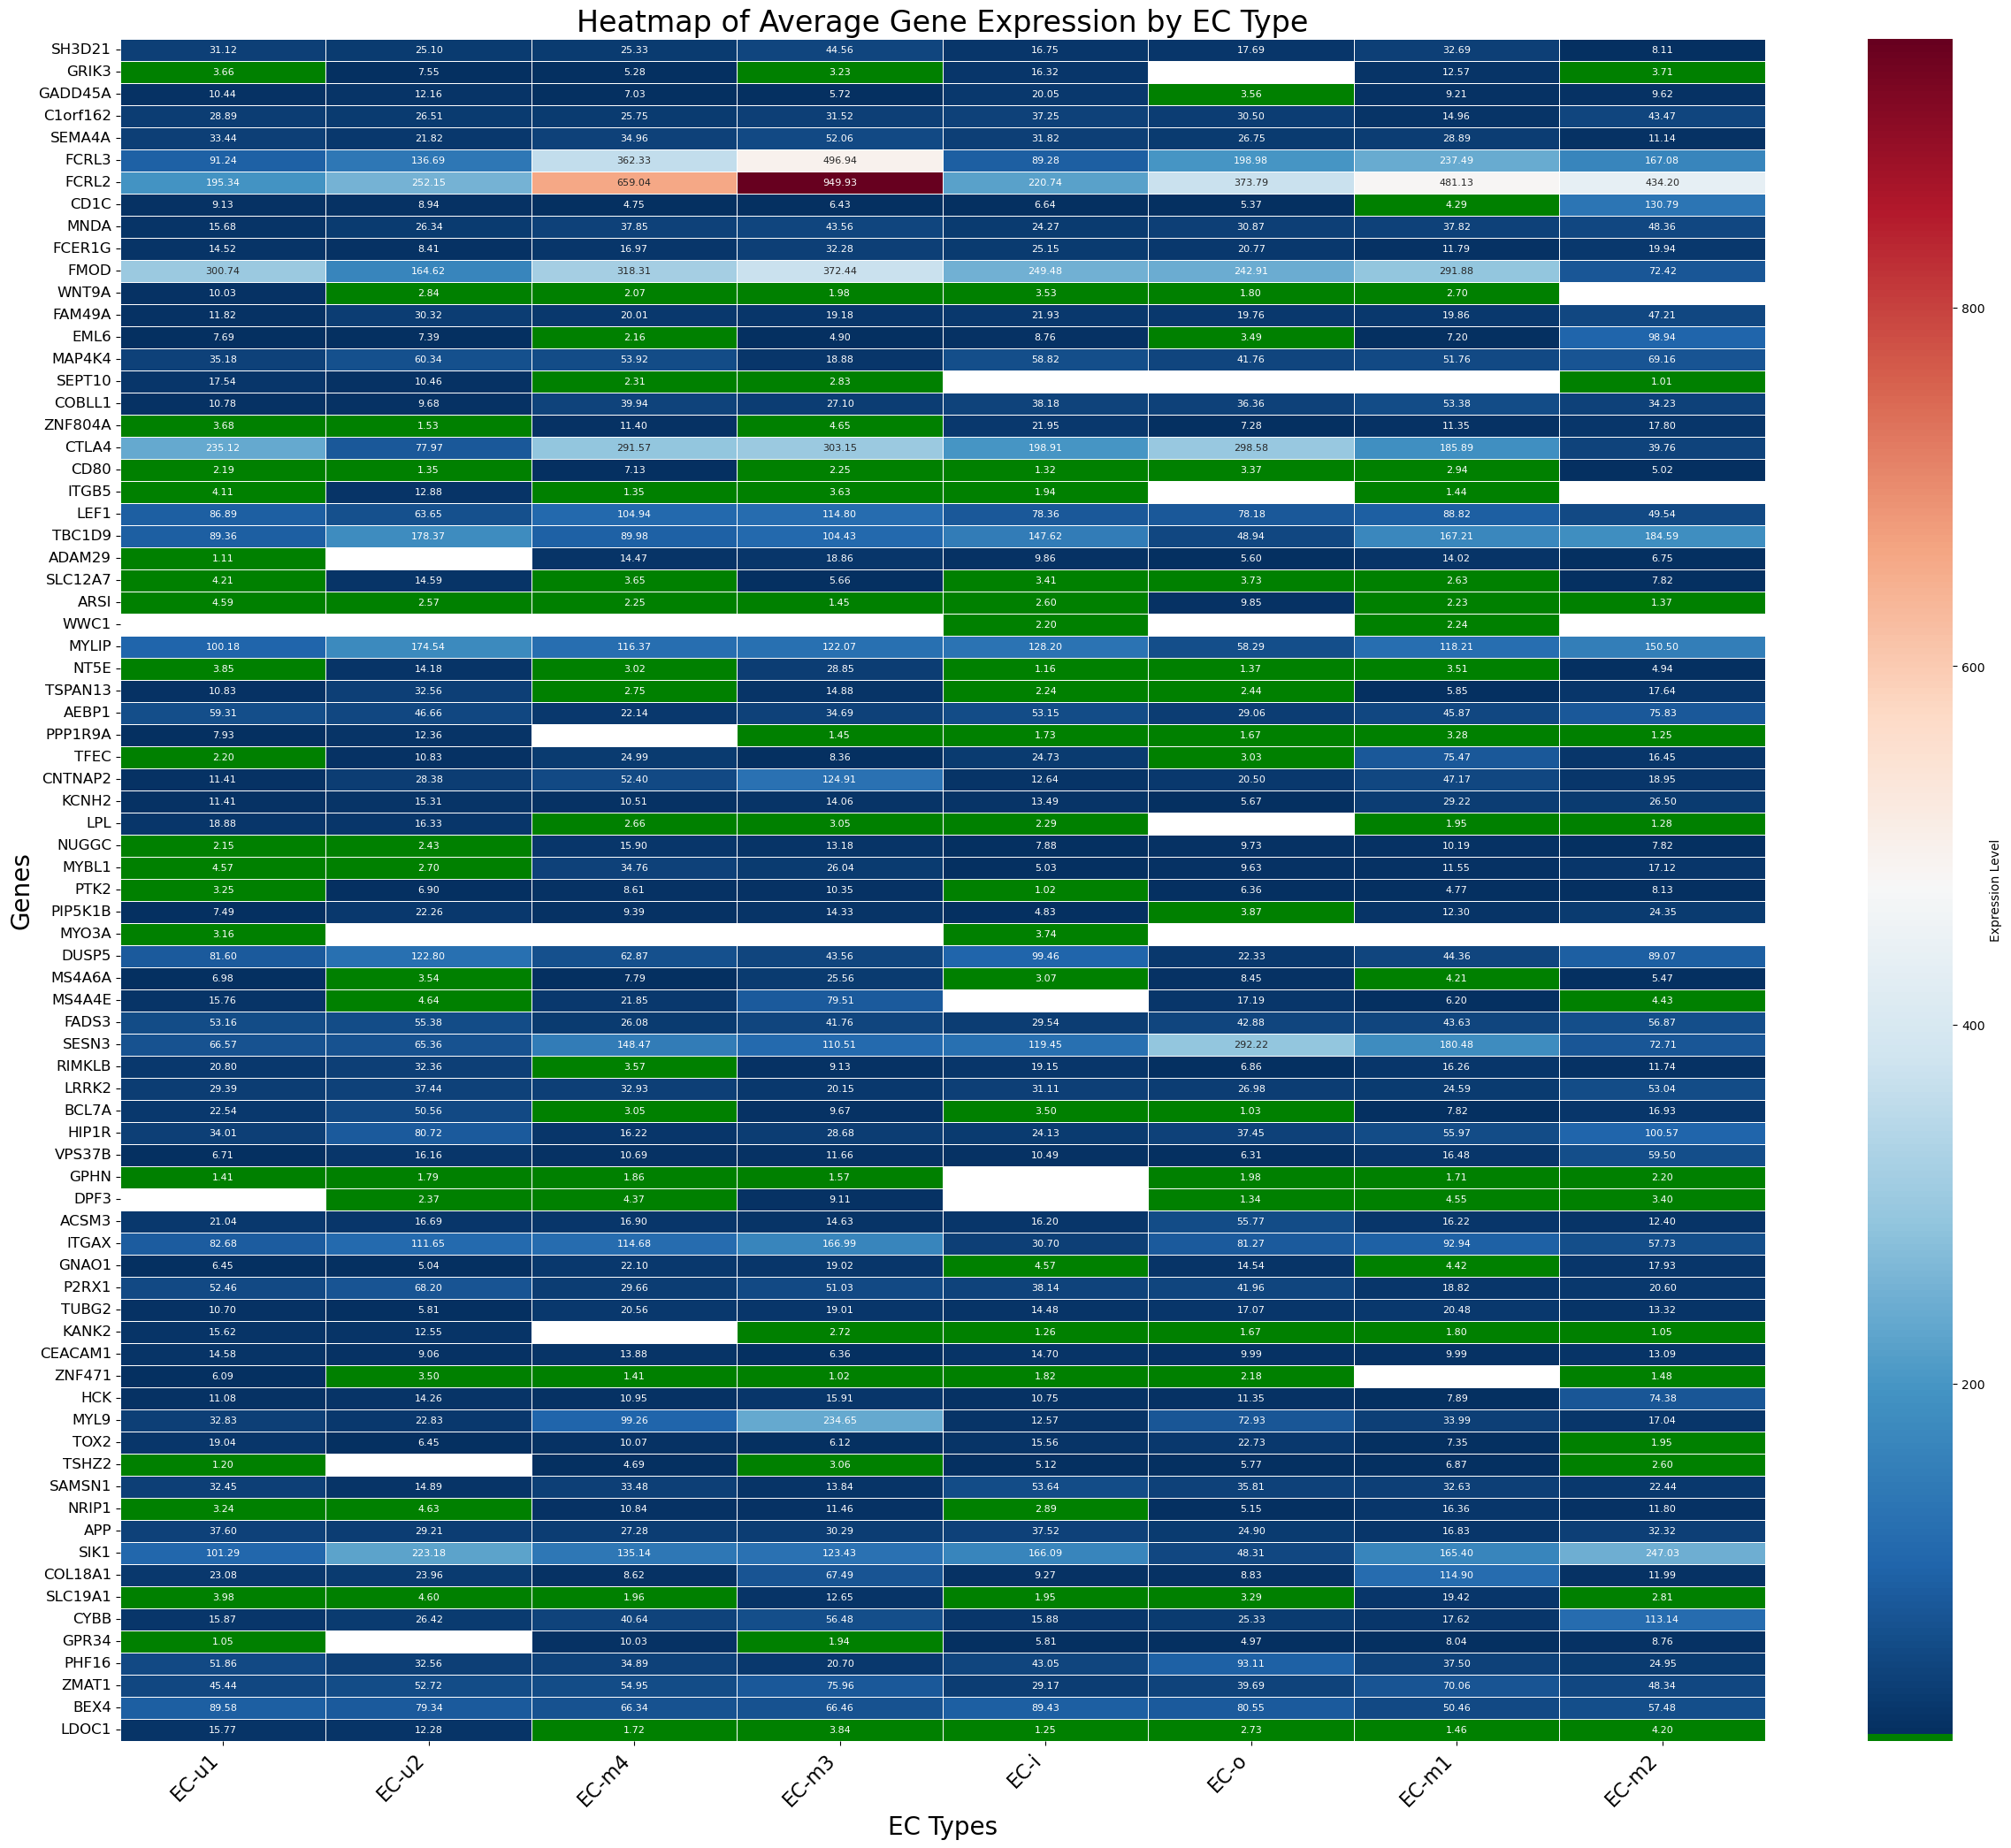

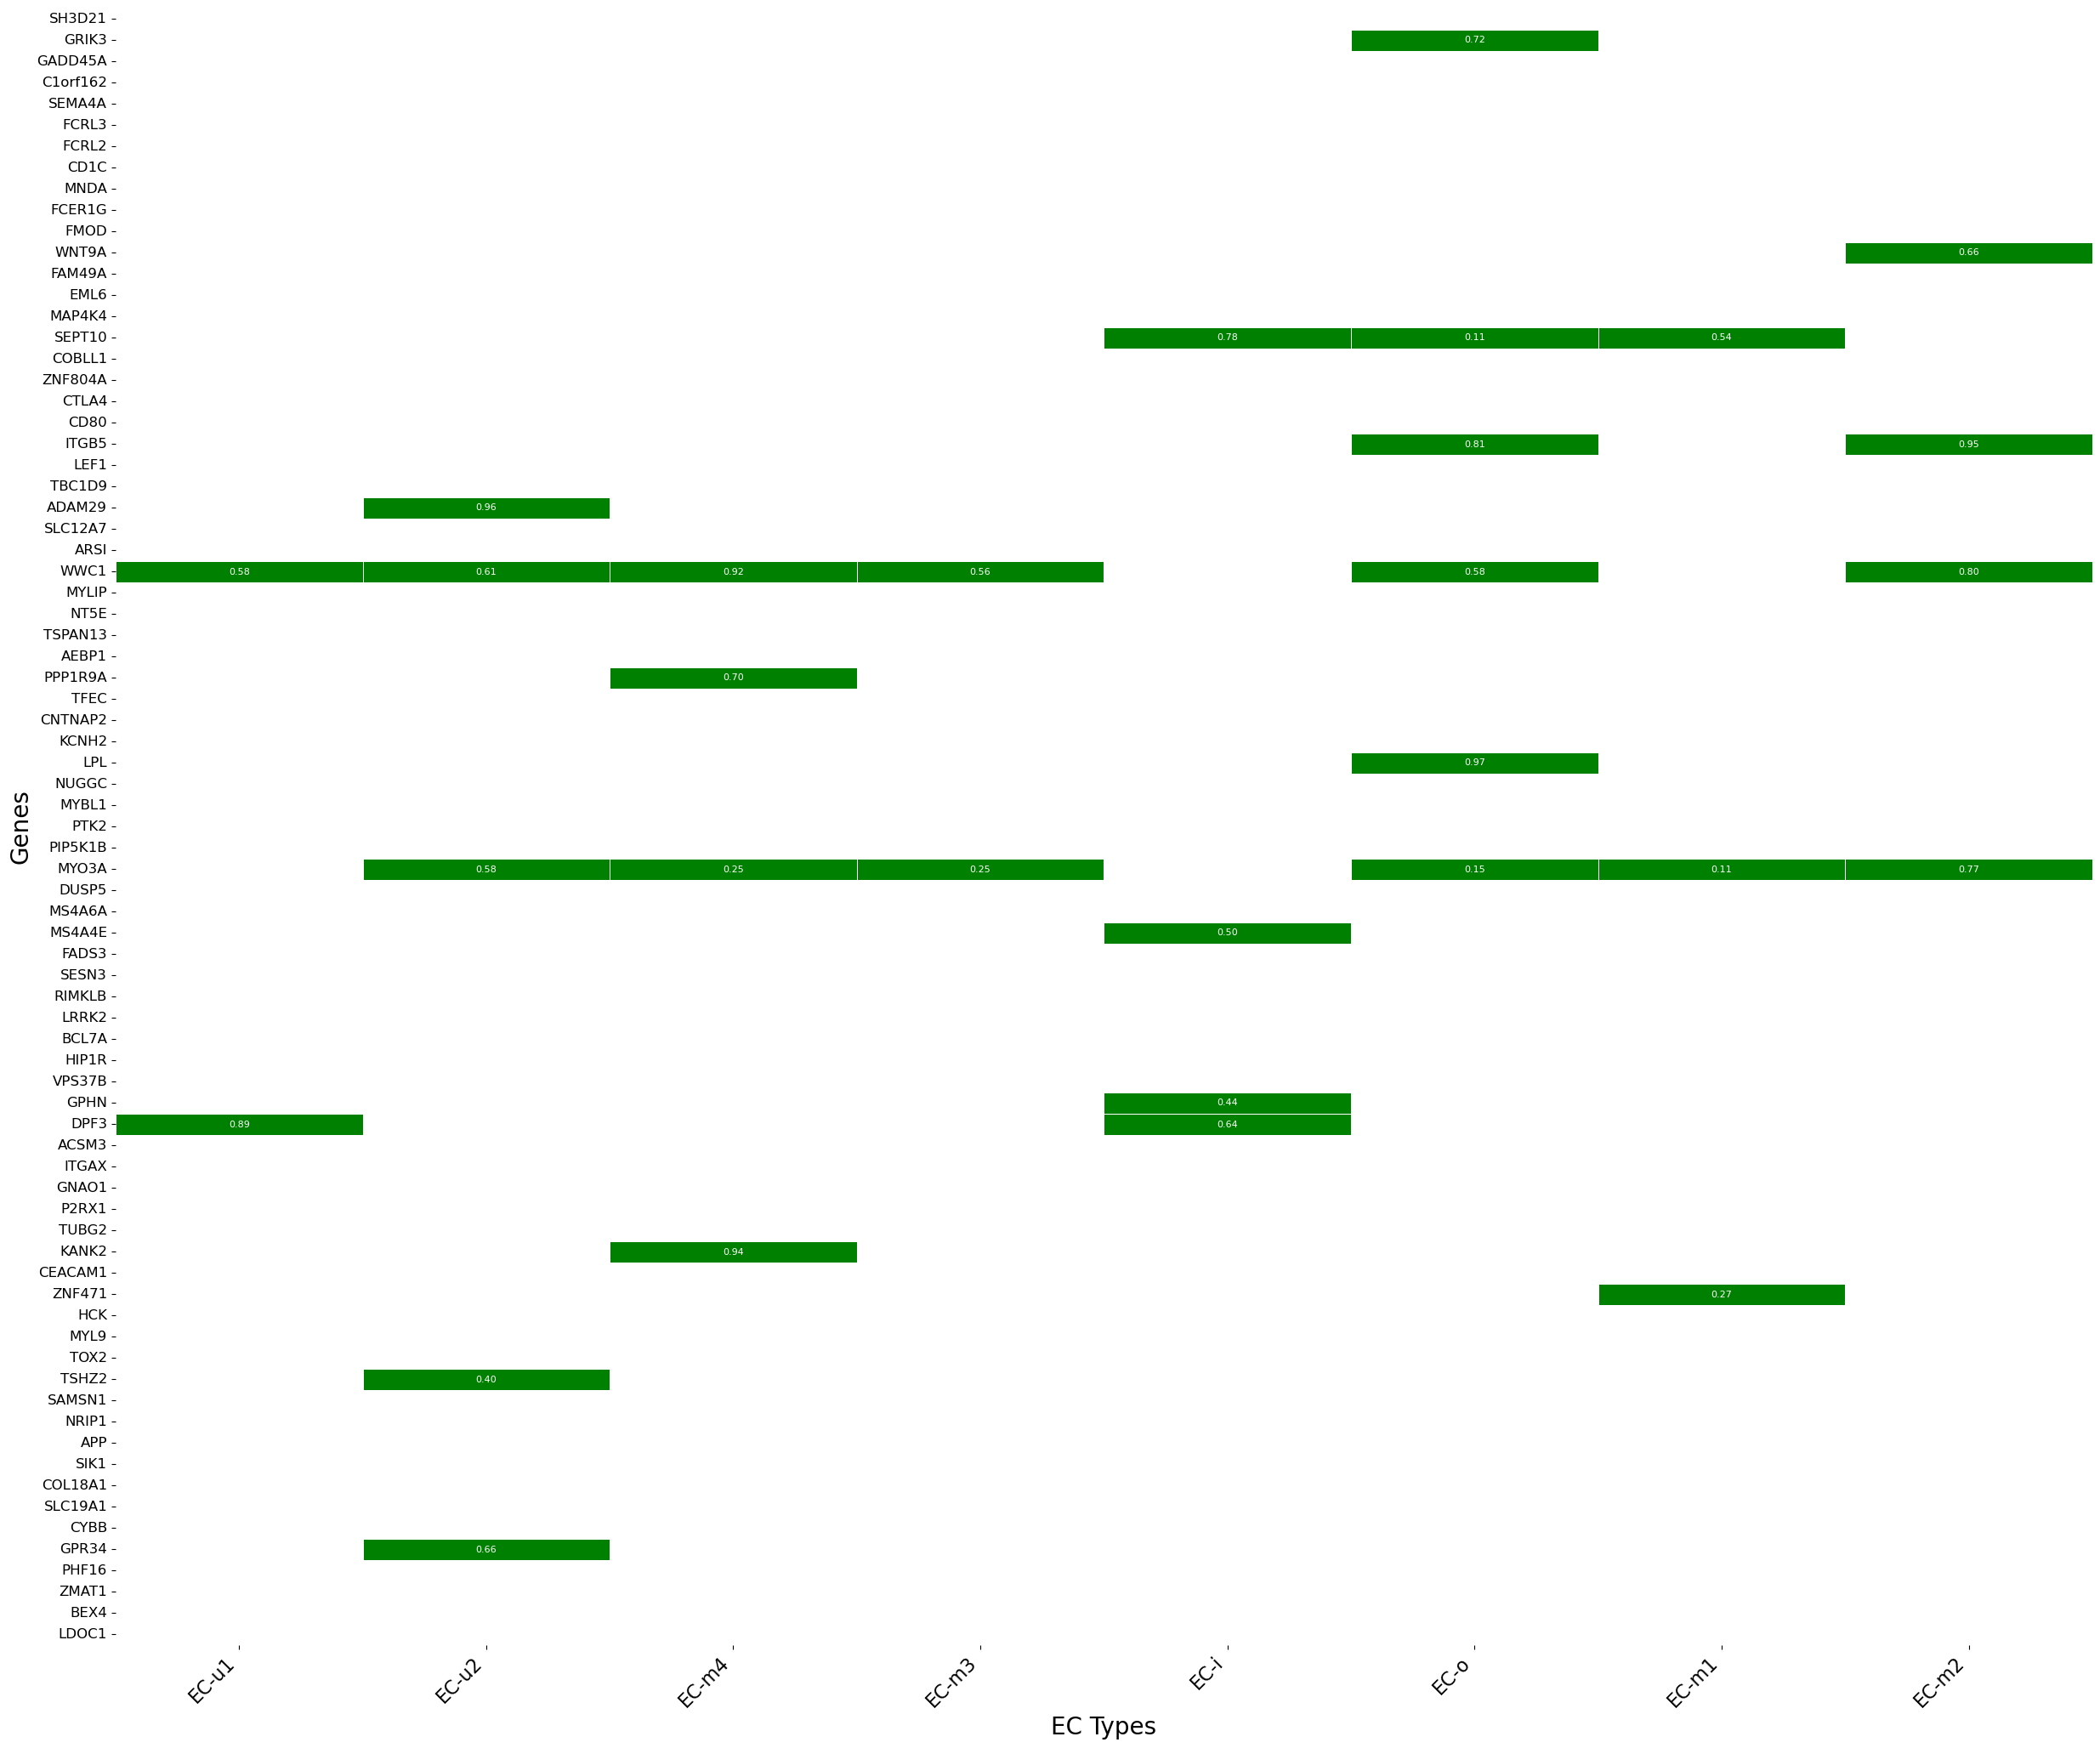

In [16]:
# Need to change this to Viridis color scheme, and make the color in groups of
# 0-0.1
# 0.1-1
# 1-10
# 10-100
# 100+ 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import matplotlib.colors as mcolors

# Provided code
adata_avg_dict = {}

# Step 1: Calculate average expression for each subset
for ec_type, adata_subset in adata_dict.items():
    avg_expression = np.mean(adata_subset.X, axis=0)  # Calculate the average expression for each gene
    avg_expression = avg_expression.reshape(1, -1)  # Reshape to keep 2D structure
    adata_avg = sc.AnnData(X=avg_expression, var=adata_subset.var.copy())  # Create a new AnnData object
    adata_avg.obs['ec_name'] = [ec_type]  # Add EC type to obs
    adata_avg_dict[ec_type] = adata_avg

# Combine the individual AnnData objects into one
adata_combined = sc.concat(adata_avg_dict.values(), join='outer', merge='same')

# Create a DataFrame for easier handling
df = pd.DataFrame(data=adata_combined.X.T, index=adata_combined.var.index, columns=adata_combined.obs['ec_name'])

# Calculate the average TPM across all EC types
avg_tpm = df.mean(axis=1)
print("Average TPM values:")
print(avg_tpm)

# Filter out genes with an average TPM of under 1
filtered_genes = avg_tpm[avg_tpm >= 1].index
print("Filtered genes (should be >= 1 TPM):")
print(filtered_genes)
df_filtered = df.loc[filtered_genes]

# Print number of genes before and after filtering
initial_genes_count = df.shape[0]
remaining_genes_count = df_filtered.shape[0]
print(f"Number of genes before filtering: {initial_genes_count}")
print(f"Number of genes after filtering: {remaining_genes_count}")

# Create a mask for values less than 1
mask = df_filtered < 1

# Create a custom colormap that includes green for values less than 1
cmap = mcolors.ListedColormap(['green'] + list(sns.color_palette("RdBu_r", 256)))

# Plot the heatmap with the custom colormap and annotate each cell
plt.figure(figsize=(30, 25))  # Increase figure size
sns.heatmap(df_filtered, cmap=cmap, annot=True, fmt=".2f", cbar_kws={'label': 'Expression Level'}, mask=mask, linewidths=.5, annot_kws={"size": 8}, vmin=1)
plt.xlabel('EC Types', fontsize=20)
plt.ylabel('Genes', fontsize=20)
plt.title('Heatmap of Average Gene Expression by EC Type', fontsize=24)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=12)  # Reduce y-axis label font size
plt.show()

# Overlay the green cells for values less than 1
plt.figure(figsize=(30, 25))  # Increase figure size
sns.heatmap(df_filtered.where(mask), cmap=mcolors.ListedColormap(['green']), annot=True, fmt=".2f", linewidths=.5, annot_kws={"size": 8}, cbar=False)
plt.xlabel('EC Types', fontsize=20)
plt.ylabel('Genes', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=12)  # Reduce y-axis label font size
plt.show()

/data01/home/ls/sarahl/miniforge3/envs/proj/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Average TPM values:
Description
SH3D21      25.169296
GRIK3        6.629589
GADD45A      9.722742
C1orf162    29.856958
SEMA4A      30.111548
              ...    
GPR34        5.158675
PHF16       42.328089
ZMAT1       52.041256
BEX4        72.455185
LDOC1        5.407129
Length: 77, dtype: float64
Filtered genes (should be >= 1 TPM):
Index(['SH3D21', 'GRIK3', 'GADD45A', 'C1orf162', 'SEMA4A', 'FCRL3', 'FCRL2',
       'CD1C', 'MNDA', 'FCER1G', 'FMOD', 'WNT9A', 'FAM49A', 'EML6', 'MAP4K4',
       'SEPT10', 'COBLL1', 'ZNF804A', 'CTLA4', 'CD80', 'ITGB5', 'LEF1',
       'TBC1D9', 'ADAM29', 'SLC12A7', 'ARSI', 'WWC1', 'MYLIP', 'NT5E',
       'TSPAN13', 'AEBP1', 'PPP1R9A', 'TFEC', 'CNTNAP2', 'KCNH2', 'LPL',
       'NUGGC', 'MYBL1', 'PTK2', 'PIP5K1B', 'MYO3A', 'DUSP5', 'MS4A6A',
       'MS4A4E', 'FADS3', 'SESN3', 'RIMKLB', 'LRRK2', 'BCL7A', 'HIP1R',
       'VPS37B', 'GPHN', 'DPF3', 'ACSM3', 'ITGAX', 'GNAO1', 'P2RX1', 'TUBG2',
       'KANK2', 'CEACAM1', 'ZNF471', 'HCK', 'MYL9', 'TOX2', 'TSHZ2', 

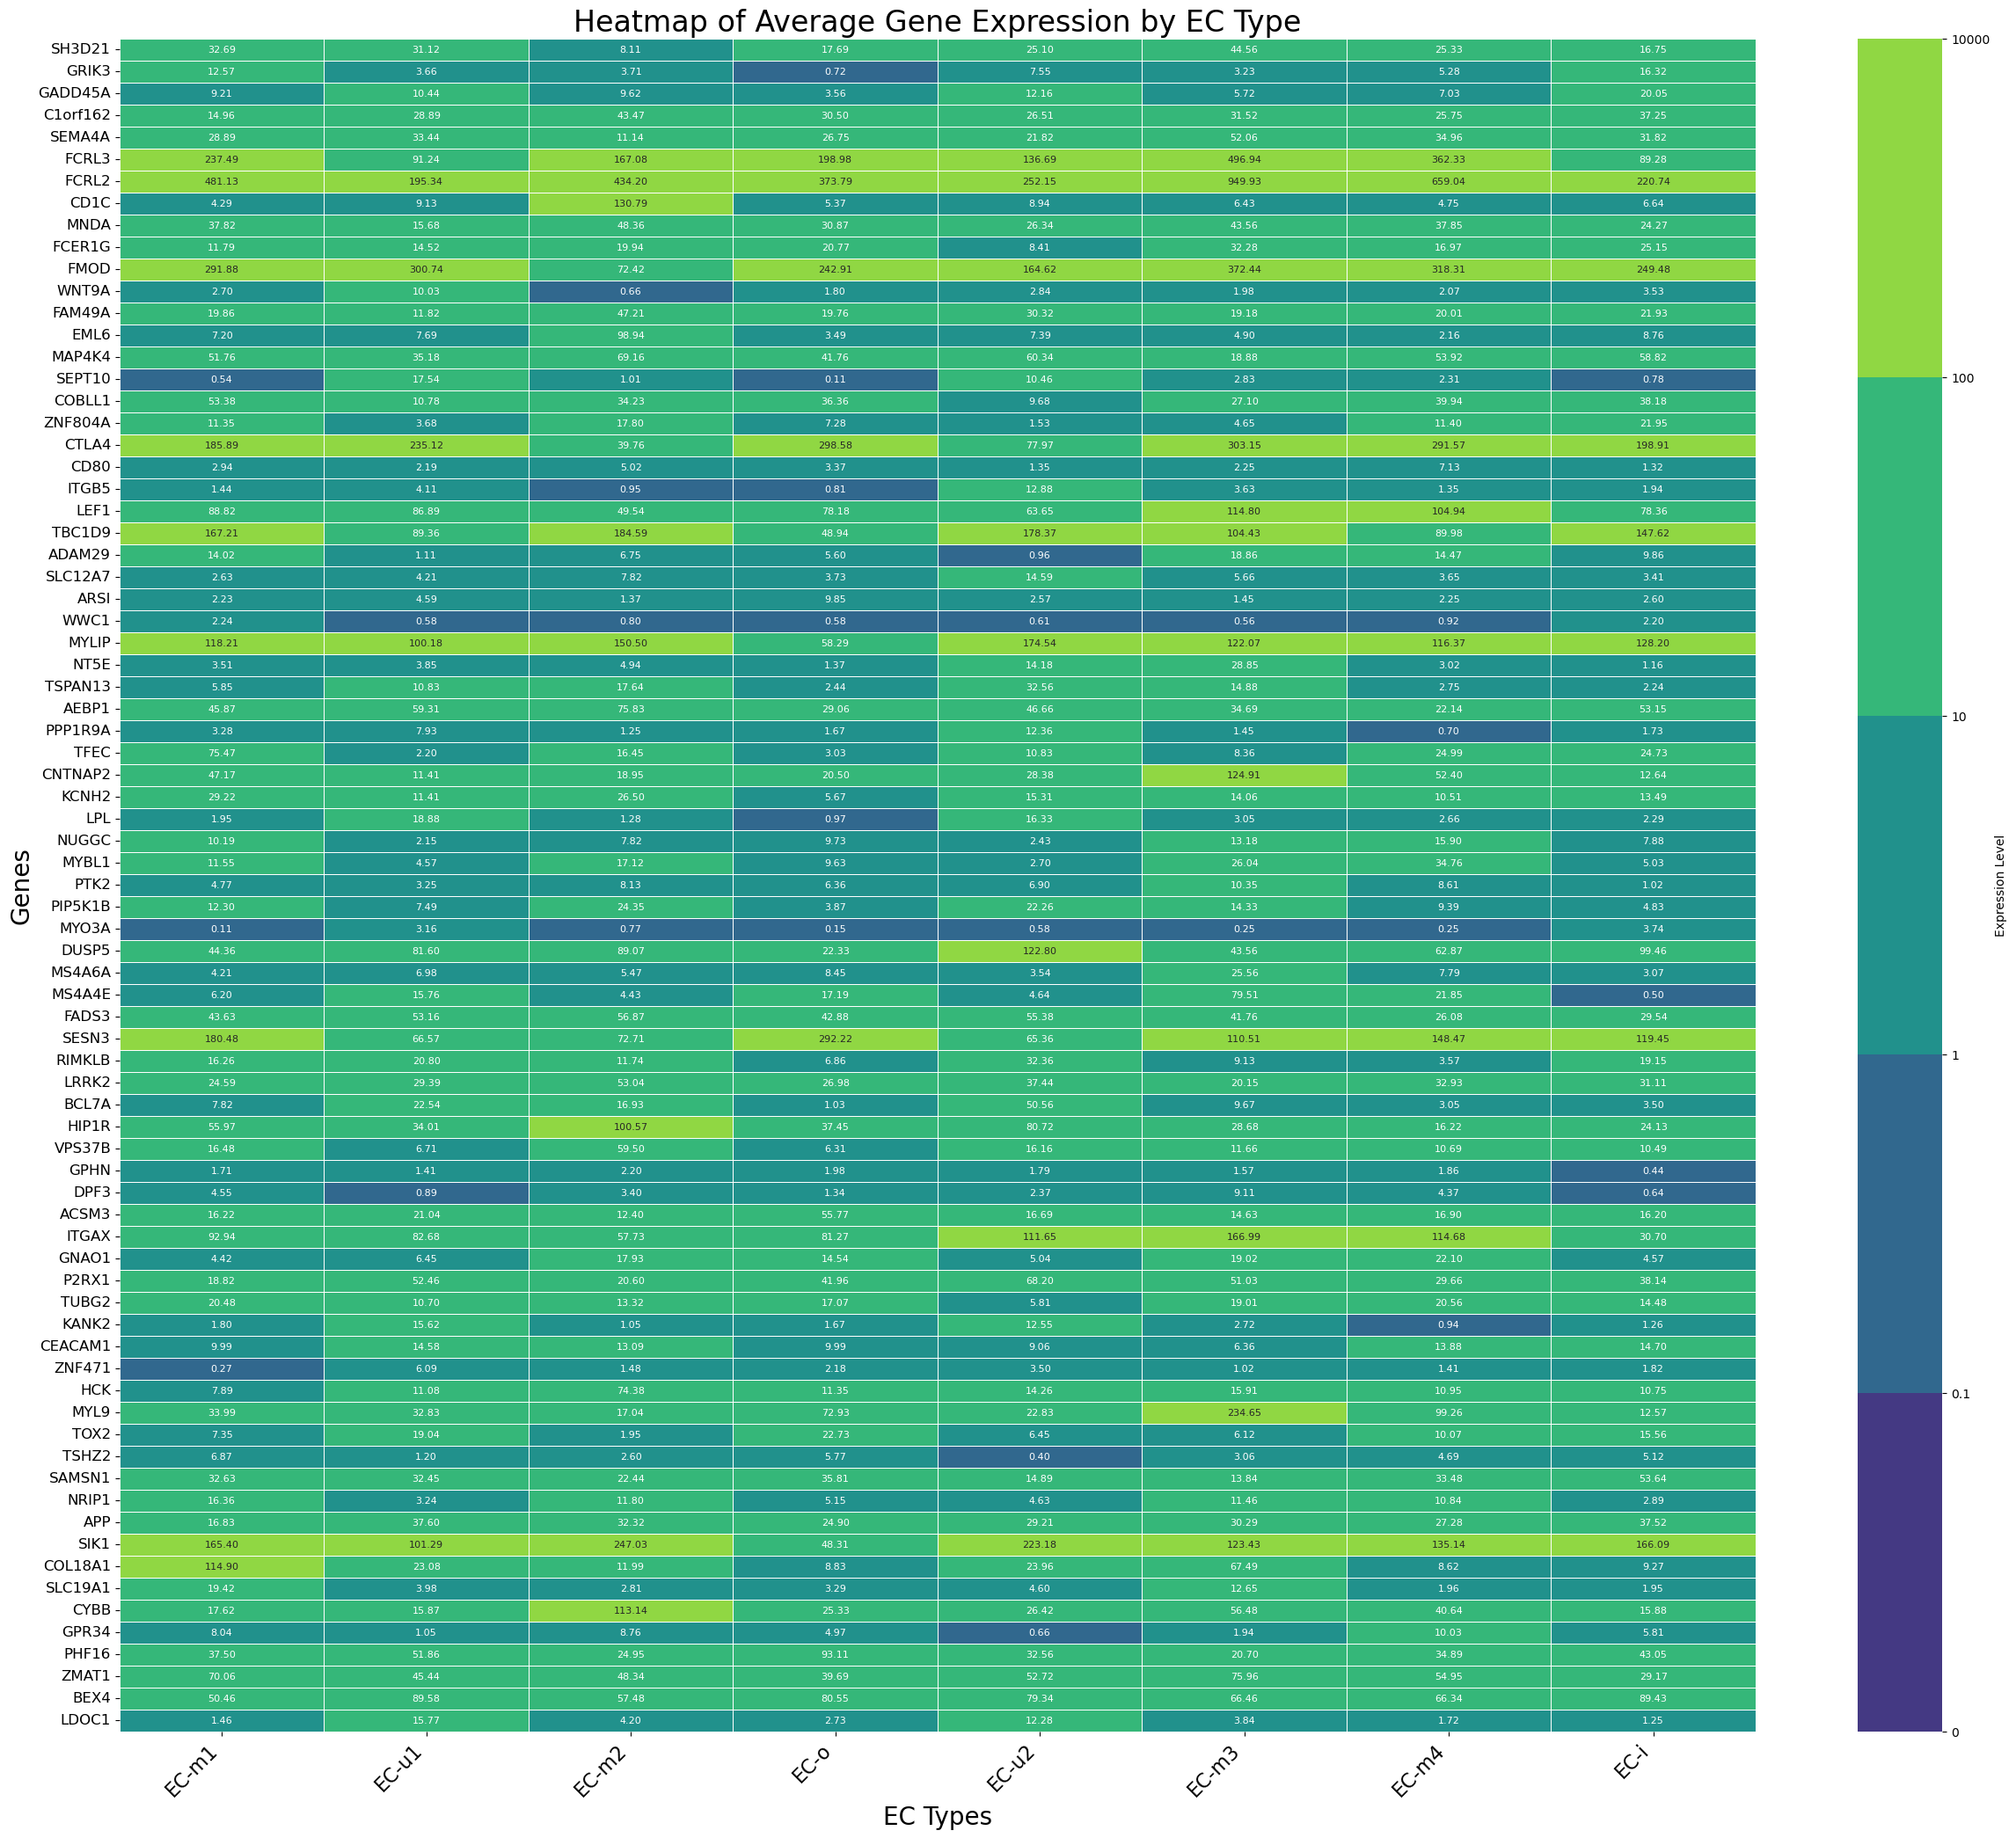

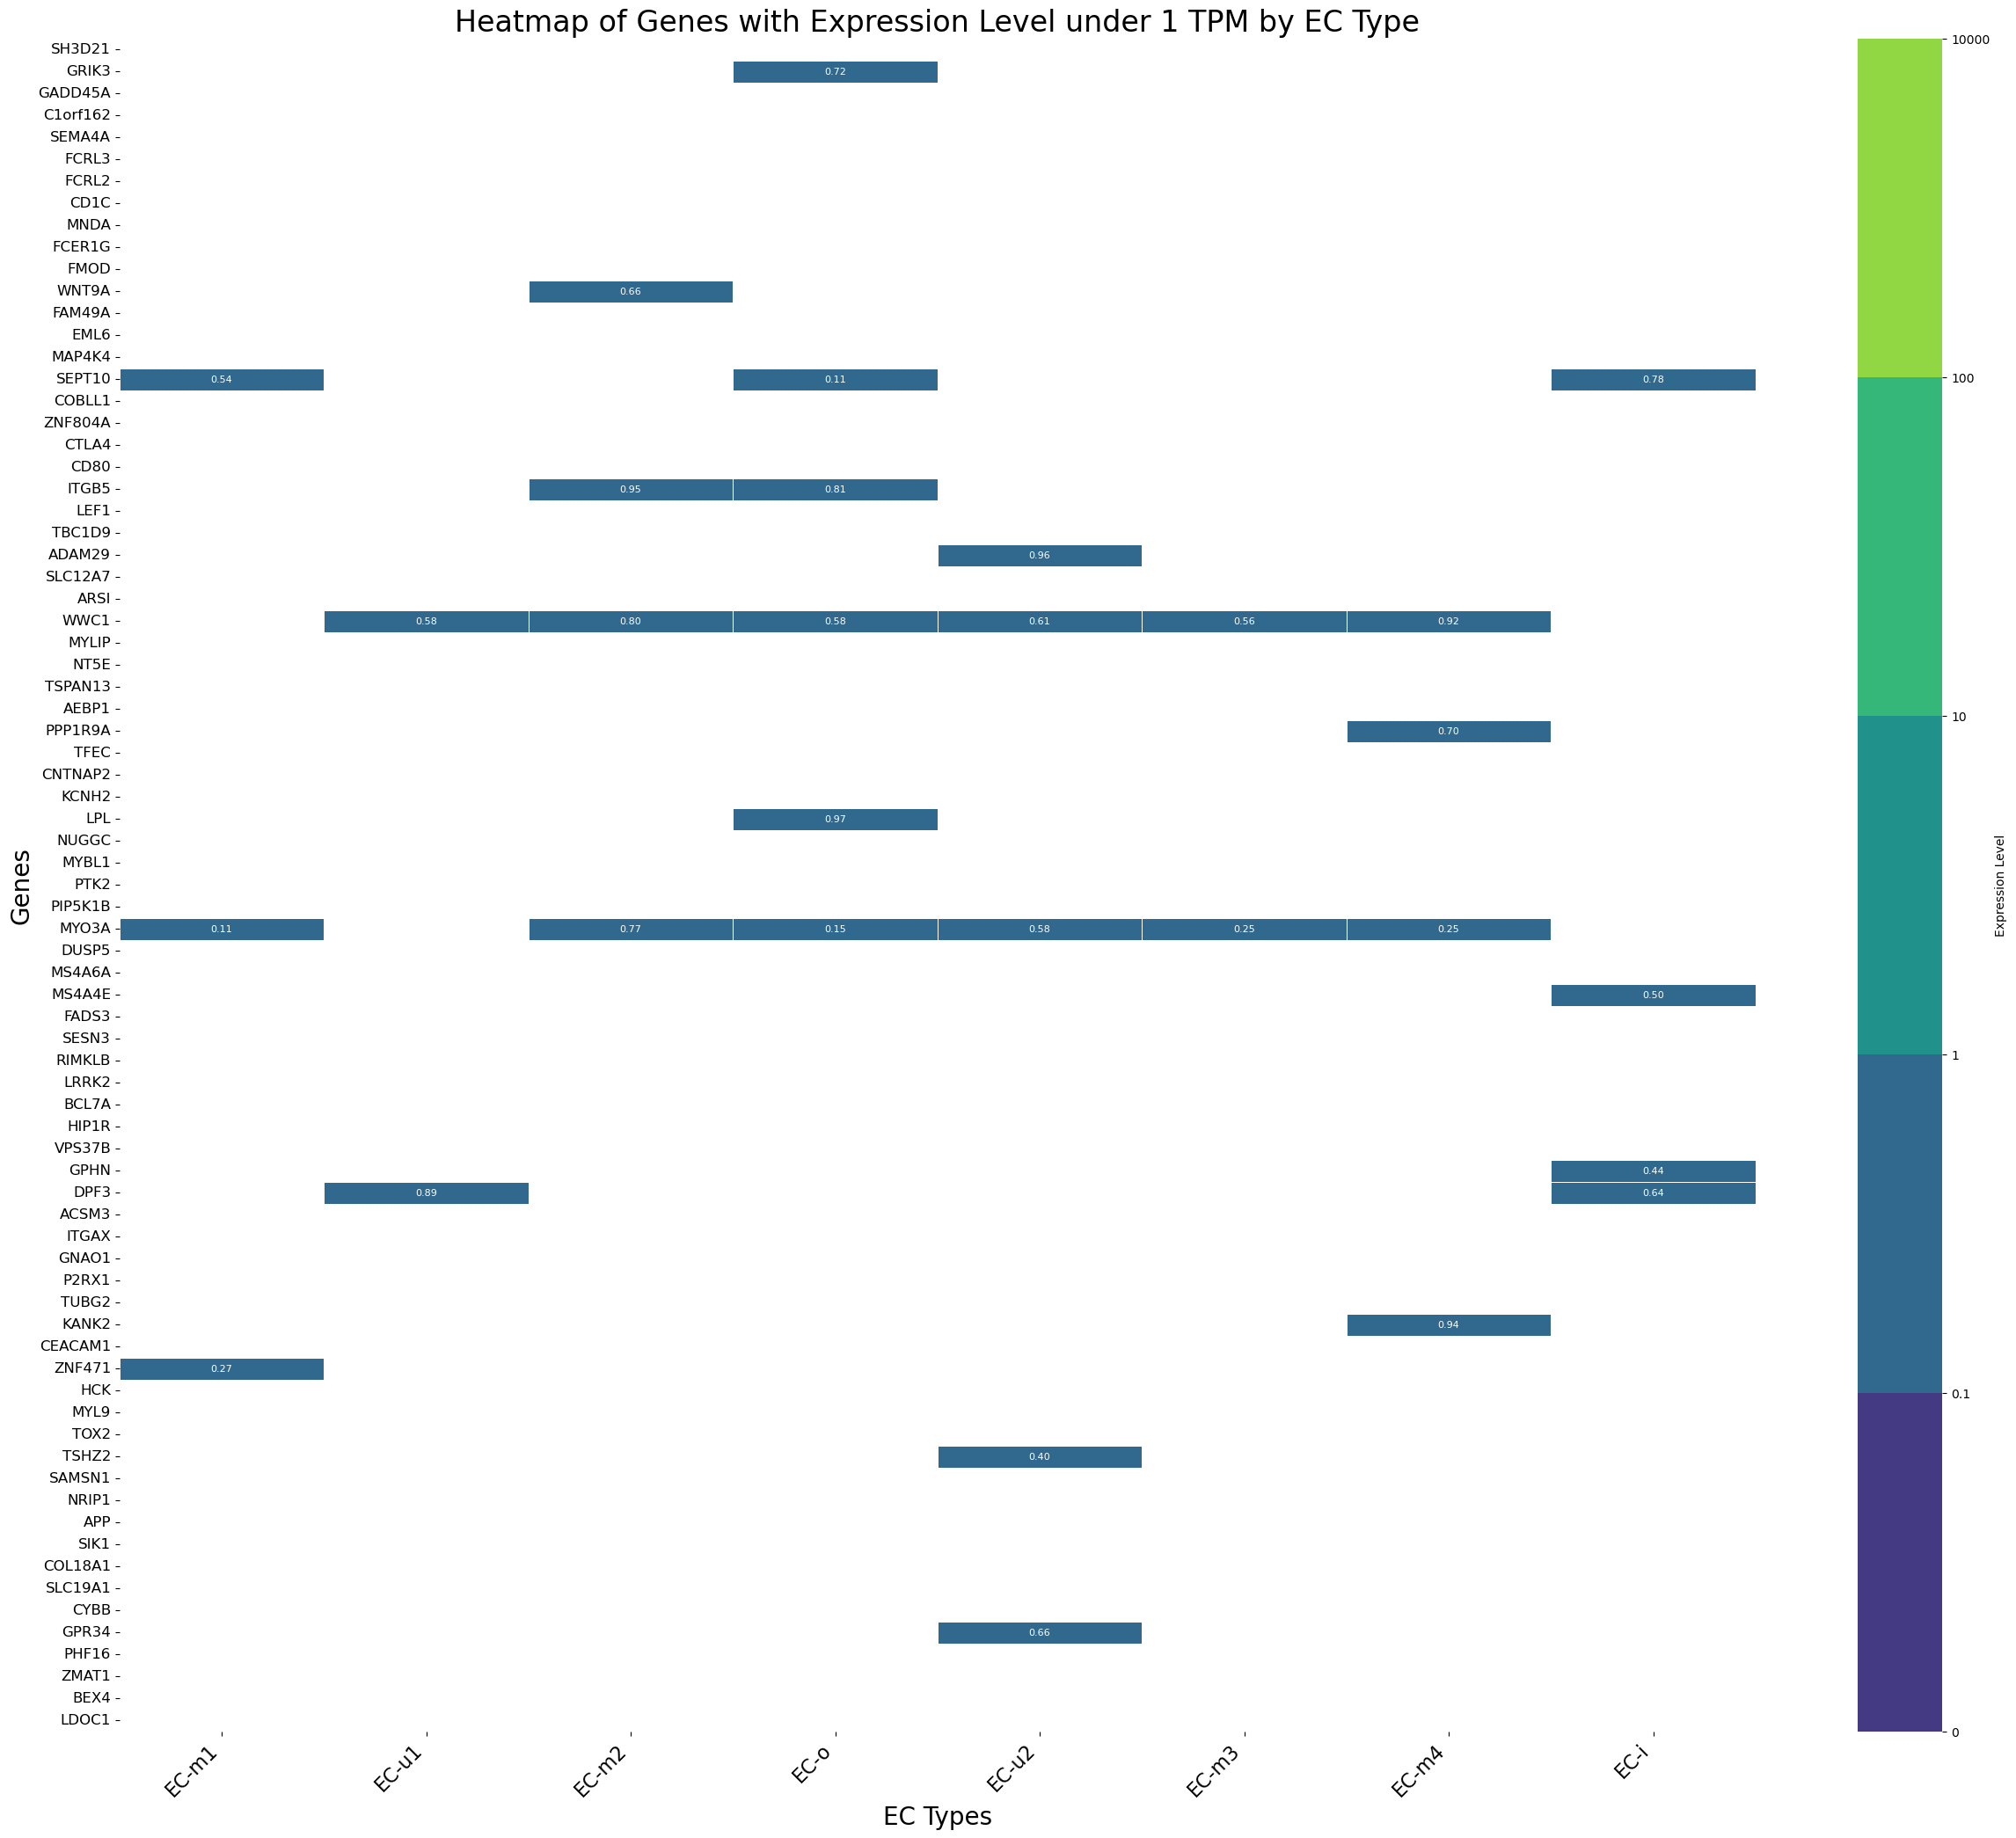

In [17]:
import matplotlib.colors as mcolors

# Provided code
adata_avg_dict = {}

# Step 1: Calculate average expression for each subset
for ec_type, adata_subset in adata_dict.items():
    avg_expression = np.mean(adata_subset.X, axis=0)  # Calculate the average expression for each gene
    avg_expression = avg_expression.reshape(1, -1)  # Reshape to keep 2D structure
    adata_avg = sc.AnnData(X=avg_expression, var=adata_subset.var.copy())  # Create a new AnnData object
    adata_avg.obs['ec_name'] = [ec_type]  # Add EC type to obs
    adata_avg_dict[ec_type] = adata_avg

# Combine the individual AnnData objects into one
adata_combined = sc.concat(adata_avg_dict.values(), join='outer', merge='same')

# Create a DataFrame for easier handling
df = pd.DataFrame(data=adata_combined.X.T, index=adata_combined.var.index, columns=adata_combined.obs['ec_name'])

# Calculate the average TPM across all EC types
avg_tpm = df.mean(axis=1)
print("Average TPM values:")
print(avg_tpm)

# Filter out genes with an average TPM of over 1
filtered_genes = avg_tpm[avg_tpm >= 1].index
print("Filtered genes (should be >= 1 TPM):")
print(filtered_genes)
df_filtered = df.loc[filtered_genes]

# Print number of genes before and after filtering
initial_genes_count = df.shape[0]
remaining_genes_count = df_filtered.shape[0]
print(f"Number of genes before filtering: {initial_genes_count}")
print(f"Number of genes after filtering: {remaining_genes_count}")

# Ensure all values in df are finite
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Ensure all values in df_filtered are finite
df_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)
df_filtered.fillna(0, inplace=True)

# Define the desired order for the columns
desired_order = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]

# Reorder the columns
df = df[desired_order]
df_filtered = df_filtered[desired_order]

# Create a custom colormap with specified groups
bounds = [0, 0.1, 1, 10, 100, 10000]
colors = sns.color_palette("viridis", len(bounds) - 1)
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the heatmap with the custom colormap and annotate each cell
plt.figure(figsize=(30, 25))  # Increase figure size
ax = sns.heatmap(df, cmap=cmap, norm=norm, annot=True, fmt=".2f", cbar_kws={'label': 'Expression Level', 'ticks': bounds}, linewidths=.5, annot_kws={"size": 8})
plt.xlabel('EC Types', fontsize=20)
plt.ylabel('Genes', fontsize=20)
plt.title('Heatmap of Average Gene Expression by EC Type', fontsize=24)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=12)  # Reduce y-axis label font size
cbar = ax.collections[0].colorbar
cbar.set_ticks(bounds)
cbar.set_ticklabels(bounds)
plt.show()

# Plot the second graph with genes having expression level under 1
# Create a mask for values less than 1
mask = df_filtered < 1

plt.figure(figsize=(30, 25))  # Increase figure size
ax = sns.heatmap(df_filtered.where(mask), cmap=cmap, norm=norm, annot=True, fmt=".2f", cbar_kws={'label': 'Expression Level', 'ticks': bounds}, linewidths=.5, annot_kws={"size": 8})
plt.xlabel('EC Types', fontsize=20)
plt.ylabel('Genes', fontsize=20)
plt.title('Heatmap of Genes with Expression Level under 1 TPM by EC Type', fontsize=24)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=12)  # Reduce y-axis label font size
cbar = ax.collections[0].colorbar
cbar.set_ticks(bounds)
cbar.set_ticklabels(bounds)
plt.show()

/data01/home/ls/sarahl/miniforge3/envs/proj/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Average TPM values:
Description
SH3D21      25.169296
GRIK3        6.629589
GADD45A      9.722742
C1orf162    29.856958
SEMA4A      30.111548
              ...    
GPR34        5.158675
PHF16       42.328089
ZMAT1       52.041256
BEX4        72.455185
LDOC1        5.407129
Length: 77, dtype: float64
Filtered genes (should be >= 1 TPM):
Index(['SH3D21', 'GRIK3', 'GADD45A', 'C1orf162', 'SEMA4A', 'FCRL3', 'FCRL2',
       'CD1C', 'MNDA', 'FCER1G', 'FMOD', 'WNT9A', 'FAM49A', 'EML6', 'MAP4K4',
       'SEPT10', 'COBLL1', 'ZNF804A', 'CTLA4', 'CD80', 'ITGB5', 'LEF1',
       'TBC1D9', 'ADAM29', 'SLC12A7', 'ARSI', 'WWC1', 'MYLIP', 'NT5E',
       'TSPAN13', 'AEBP1', 'PPP1R9A', 'TFEC', 'CNTNAP2', 'KCNH2', 'LPL',
       'NUGGC', 'MYBL1', 'PTK2', 'PIP5K1B', 'MYO3A', 'DUSP5', 'MS4A6A',
       'MS4A4E', 'FADS3', 'SESN3', 'RIMKLB', 'LRRK2', 'BCL7A', 'HIP1R',
       'VPS37B', 'GPHN', 'DPF3', 'ACSM3', 'ITGAX', 'GNAO1', 'P2RX1', 'TUBG2',
       'KANK2', 'CEACAM1', 'ZNF471', 'HCK', 'MYL9', 'TOX2', 'TSHZ2', 

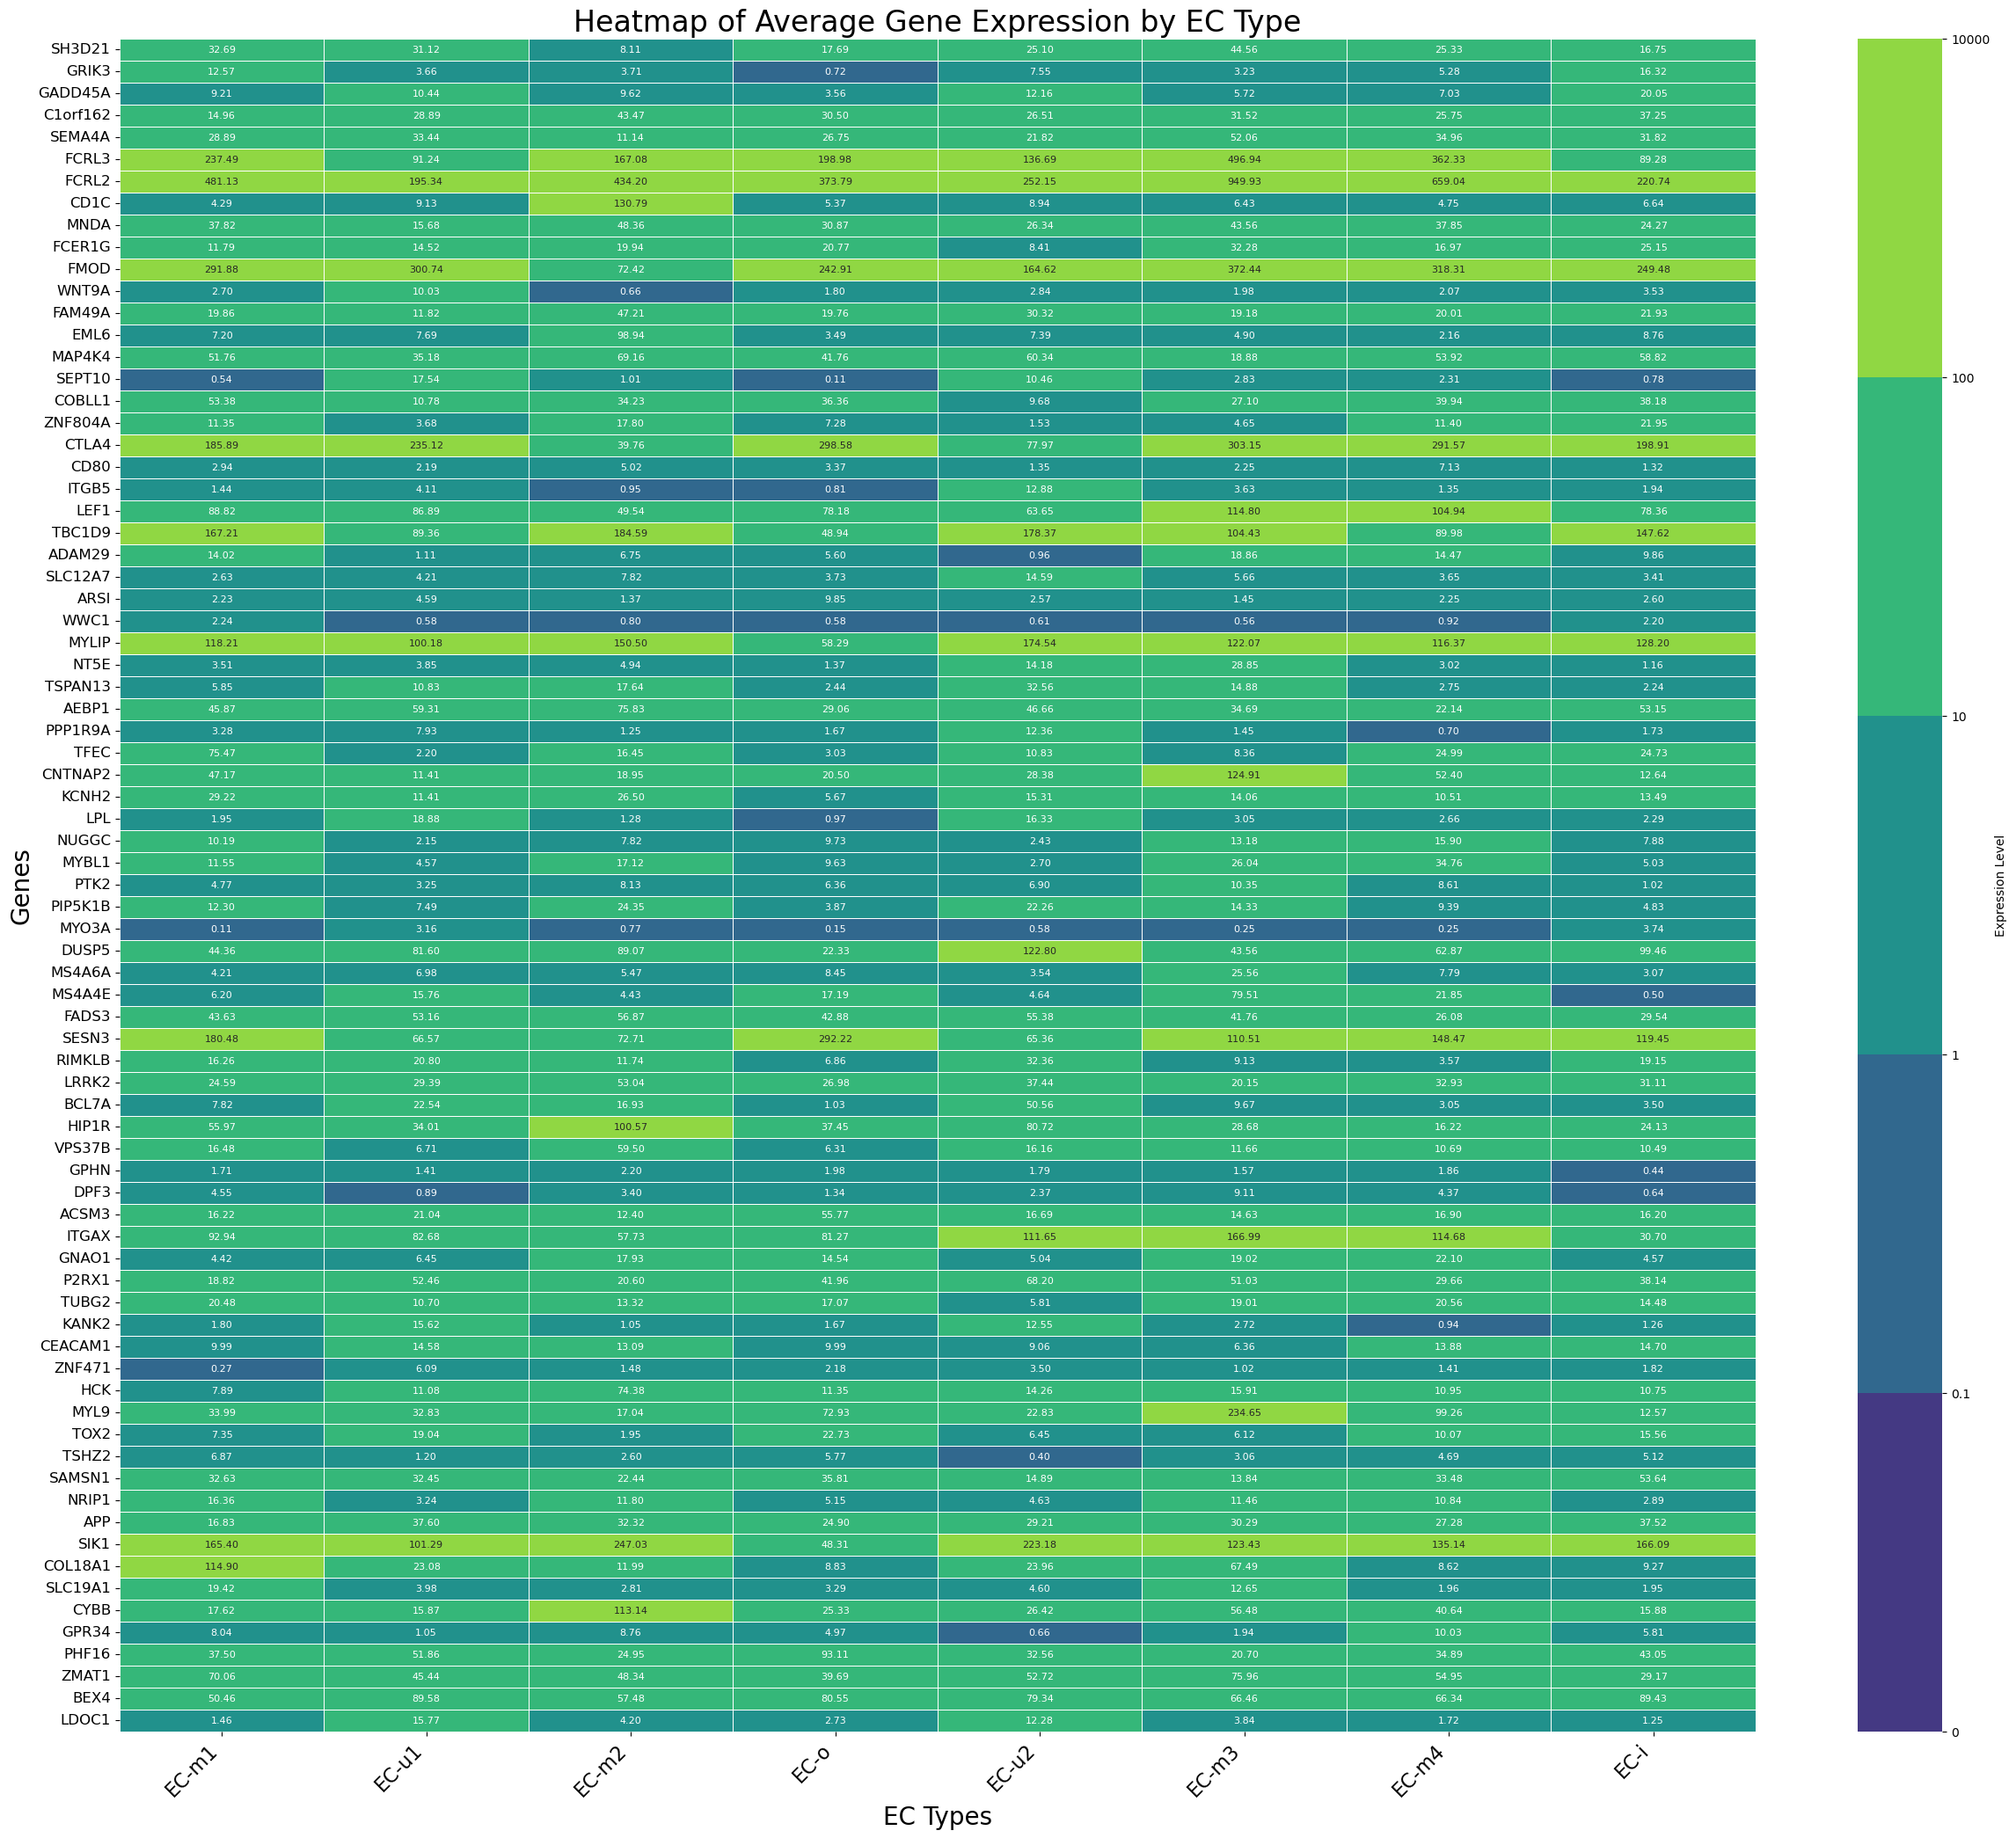

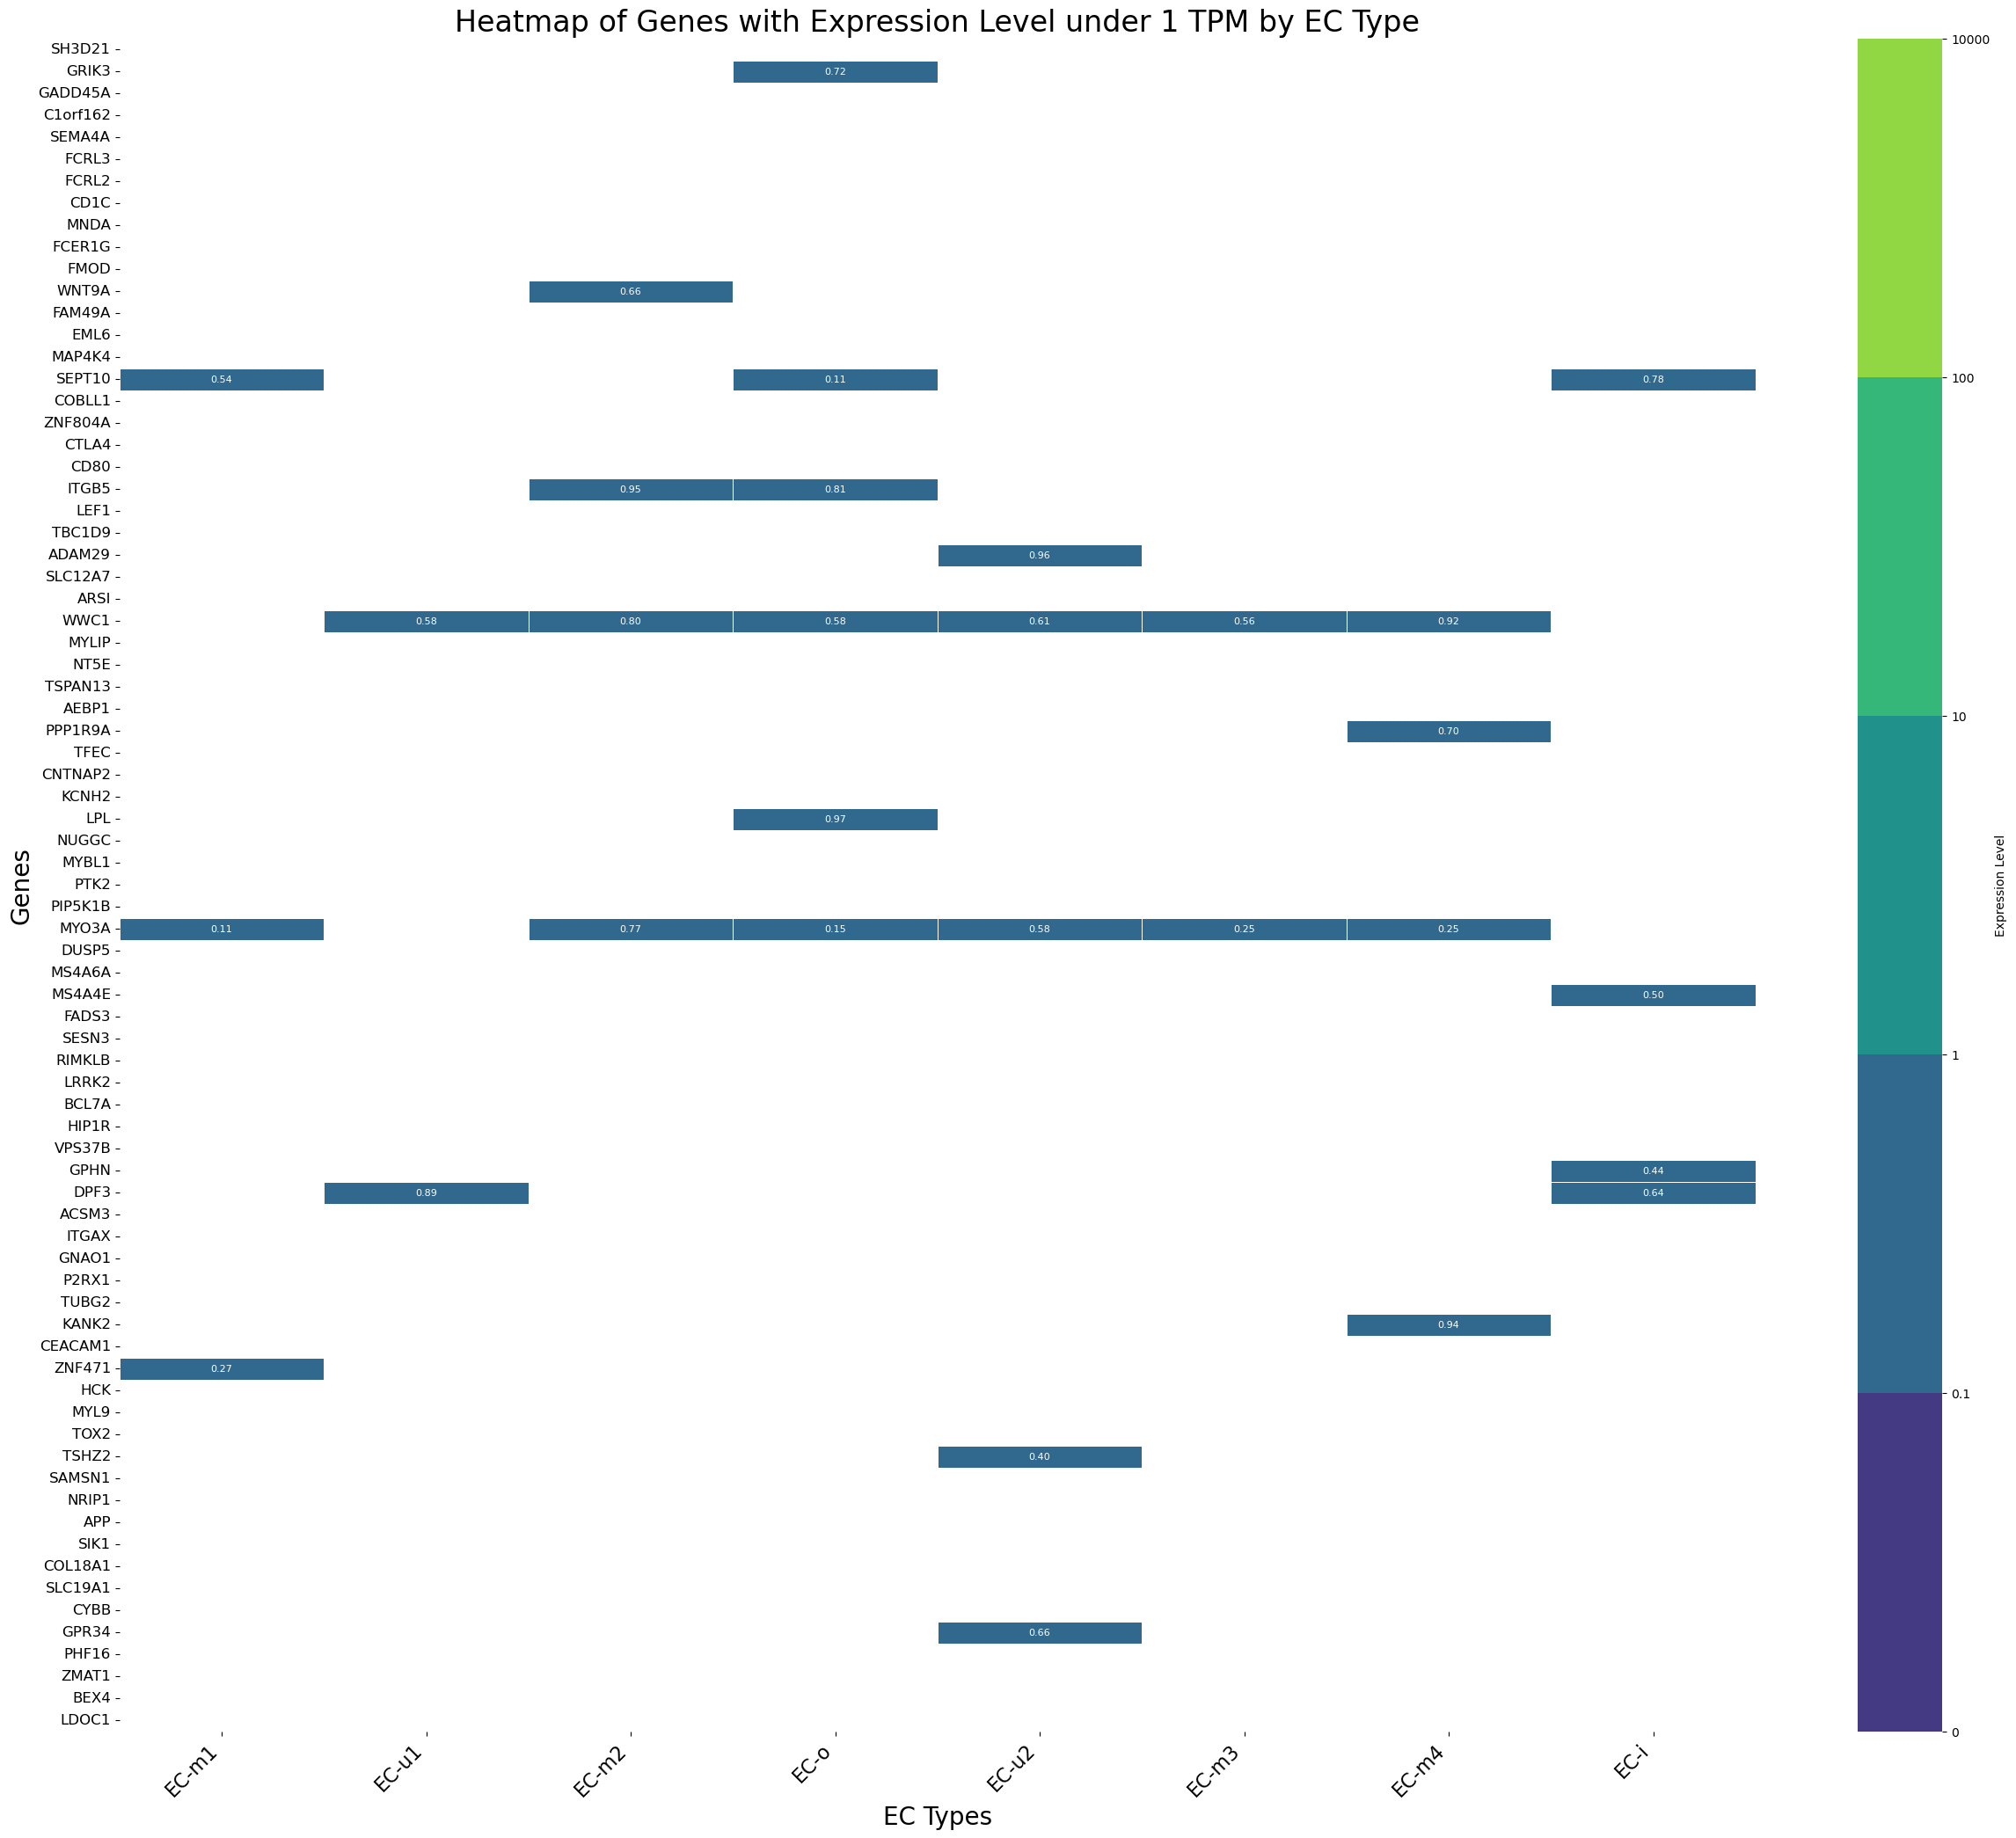

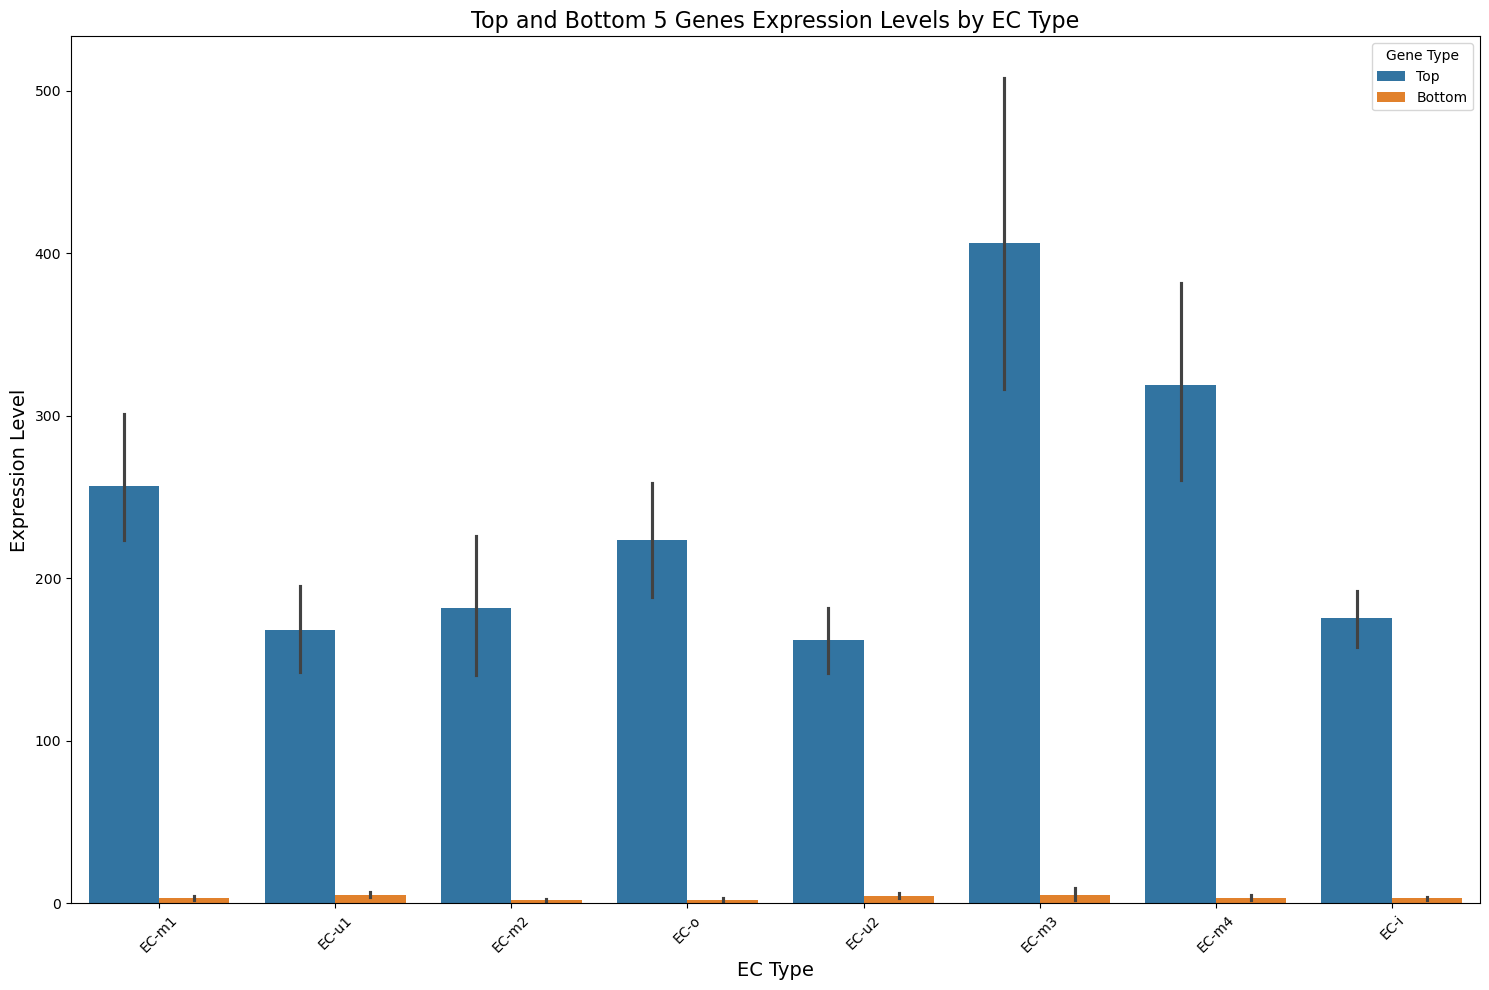

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

# Provided code
adata_avg_dict = {}

# Step 1: Calculate average expression for each subset
for ec_type, adata_subset in adata_dict.items():
    avg_expression = np.mean(adata_subset.X, axis=0)  # Calculate the average expression for each gene
    avg_expression = avg_expression.reshape(1, -1)  # Reshape to keep 2D structure
    adata_avg = sc.AnnData(X=avg_expression, var=adata_subset.var.copy())  # Create a new AnnData object
    adata_avg.obs['ec_name'] = [ec_type]  # Add EC type to obs
    adata_avg_dict[ec_type] = adata_avg

# Combine the individual AnnData objects into one
adata_combined = sc.concat(adata_avg_dict.values(), join='outer', merge='same')

# Create a DataFrame for easier handling
df = pd.DataFrame(data=adata_combined.X.T, index=adata_combined.var.index, columns=adata_combined.obs['ec_name'])

# Calculate the average TPM across all EC types
avg_tpm = df.mean(axis=1)
print("Average TPM values:")
print(avg_tpm)

# Filter out genes with an average TPM of over 1
filtered_genes = avg_tpm[avg_tpm >= 1].index
print("Filtered genes (should be >= 1 TPM):")
print(filtered_genes)
df_filtered = df.loc[filtered_genes]

# Print number of genes before and after filtering
initial_genes_count = df.shape[0]
remaining_genes_count = df_filtered.shape[0]
print(f"Number of genes before filtering: {initial_genes_count}")
print(f"Number of genes after filtering: {remaining_genes_count}")

# Ensure all values in df are finite
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Ensure all values in df_filtered are finite
df_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)
df_filtered.fillna(0, inplace=True)

# Define the desired order for the columns
desired_order = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]

# Reorder the columns
df = df[desired_order]
df_filtered = df_filtered[desired_order]

# Create a custom colormap with specified groups
bounds = [0, 0.1, 1, 10, 100, 10000]
colors = sns.color_palette("viridis", len(bounds) - 1)
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the heatmap with the custom colormap and annotate each cell
plt.figure(figsize=(30, 25))  # Increase figure size
ax = sns.heatmap(df, cmap=cmap, norm=norm, annot=True, fmt=".2f", cbar_kws={'label': 'Expression Level', 'ticks': bounds}, linewidths=.5, annot_kws={"size": 8})
plt.xlabel('EC Types', fontsize=20)
plt.ylabel('Genes', fontsize=20)
plt.title('Heatmap of Average Gene Expression by EC Type', fontsize=24)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=12)  # Reduce y-axis label font size
cbar = ax.collections[0].colorbar
cbar.set_ticks(bounds)
cbar.set_ticklabels(bounds)
plt.show()

# Plot the second graph with genes having expression level under 1
# Create a mask for values less than 1
mask = df_filtered < 1

plt.figure(figsize=(30, 25))  # Increase figure size
ax = sns.heatmap(df_filtered.where(mask), cmap=cmap, norm=norm, annot=True, fmt=".2f", cbar_kws={'label': 'Expression Level', 'ticks': bounds}, linewidths=.5, annot_kws={"size": 8})
plt.xlabel('EC Types', fontsize=20)
plt.ylabel('Genes', fontsize=20)
plt.title('Heatmap of Genes with Expression Level under 1 TPM by EC Type', fontsize=24)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=12)  # Reduce y-axis label font size
cbar = ax.collections[0].colorbar
cbar.set_ticks(bounds)
cbar.set_ticklabels(bounds)
plt.show()

# Initialize dictionaries to store top and bottom genes for each EC
top_genes_dict = {}
bottom_genes_dict = {}

# Find top 5 most expressive and least expressive genes for each EC
for ec_type in df.columns:
    sorted_genes = df[ec_type].sort_values(ascending=False)
    top_genes_dict[ec_type] = sorted_genes.head(5).index.tolist()
    bottom_genes_dict[ec_type] = sorted_genes.tail(5).index.tolist()

# Combine all top and bottom genes into a single list
all_top_genes = [gene for genes in top_genes_dict.values() for gene in genes]
all_bottom_genes = [gene for genes in bottom_genes_dict.values() for gene in genes]

# Create a DataFrame to store the expression values of top and bottom genes
top_genes_df = df.loc[all_top_genes]
bottom_genes_df = df.loc[all_bottom_genes]

# Create a DataFrame for plotting
plot_df = pd.concat([top_genes_df, bottom_genes_df])
plot_df['Gene'] = plot_df.index
plot_df = plot_df.melt(id_vars='Gene', var_name='EC Type', value_name='Expression')

# Add a column to differentiate top and bottom genes
plot_df['Gene Type'] = plot_df['Gene'].apply(lambda x: 'Top' if x in all_top_genes else 'Bottom')

# Set the figure size
plt.figure(figsize=(15, 10))

# Create a bar plot
sns.barplot(data=plot_df, x='EC Type', y='Expression', hue='Gene Type', dodge=True)

# Set plot labels and title
plt.xlabel('EC Type', fontsize=14)
plt.ylabel('Expression Level', fontsize=14)
plt.title('Top and Bottom 5 Genes Expression Levels by EC Type', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Gene Type')

# Show the plot
plt.tight_layout()
plt.show()


In [19]:
if 'GRIK3' in df.index:
    il13ra1_values = df.loc['GRIK3']
    print(f"Expression values for GRIK3:\n{il13ra1_values}")
else:
    print("IL13RA1 not found in the dataset.")

Expression values for GRIK3:
ec_name
EC-m1    12.568265
EC-u1     3.661965
EC-m2     3.711382
EC-o      0.718510
EC-u2     7.547641
EC-m3     3.231374
EC-m4     5.280407
EC-i     16.317166
Name: GRIK3, dtype: float64


In [20]:
def normalize_to_one(adata):
    # Normalize each row to sum to 1
    normalized_X = adata.X / adata.X.sum(axis=1, keepdims=True)
    return sc.AnnData(X=normalized_X, obs=adata.obs.copy(), var=adata.var.copy())

# Dictionary to store normalized AnnData objects
adata_normalized_dict = {}

# Normalize each EC type separately
for ec_type, adata_subset in adata_avg_dict.items():
    adata_normalized = normalize_to_one(adata_subset)
    adata_normalized_dict[ec_type] = adata_normalized

# Combine the normalized AnnData objects into one
adata_combined_normalized = sc.concat(adata_normalized_dict.values(), join='outer', merge='same')

# Verify the combined normalized AnnData object
print(adata_combined_normalized.obs)

def validate_normalization(adata):
    row_sums = adata.X.sum(axis=1)
    return np.allclose(row_sums, 1)

for ec_type, adata_normalized in adata_normalized_dict.items():
    is_valid = validate_normalization(adata_normalized)
    print(f"Normalization validation for {ec_type}: {is_valid}")


  ec_name
0   EC-u1
0   EC-u2
0   EC-m4
0   EC-m3
0    EC-i
0    EC-o
0   EC-m1
0   EC-m2
Normalization validation for EC-u1: True
Normalization validation for EC-u2: True
Normalization validation for EC-m4: True
Normalization validation for EC-m3: True
Normalization validation for EC-i: True
Normalization validation for EC-o: True
Normalization validation for EC-m1: True
Normalization validation for EC-m2: True


/data01/home/ls/sarahl/miniforge3/envs/proj/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [21]:
from scipy.stats import spearmanr

check = sc.read_h5ad("raw_data/normalized_sc_cll_3ca.h5ad")

descriptions_to_keep = [
'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
 'ZNF471', 'KCNH2', 'COBLL1', 'SEPT10', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
  'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
   'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
    'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
     'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
      'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
       'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
        'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
         'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2']

# Calculate the length of the array
array_length = len(descriptions_to_keep)

# Print the length of the array
print(f"The length of the array is: {array_length}")
# Filter the var DataFrame to retain only the rows with the desired descriptions
filtered_var = check.var[check.var.index.isin(descriptions_to_keep)]

# Subset the AnnData object using the filtered var DataFrame
adata_filtered = adata[:, adata.var.index.isin(descriptions_to_keep)]

# Step 1: Subset the AnnData object to include only the sample 'CRC-0004'
ec_profiles = pd.DataFrame(adata_combined_normalized.X.T, index=adata_combined_normalized.var_names, columns=adata_combined_normalized.obs['ec_name'])

print(adata_filtered.shape)
for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    print(sample_expression.shape)  # C

The length of the array is: 77
(715, 77)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)
(77,)

In [22]:
check = sc.read_h5ad("raw_data/normalized_sc_cll_3ca.h5ad")
check.X

array([[2.17605787e-06, 1.70717881e-05, 1.88960772e-06, ...,
        4.49766984e-06, 2.65354552e-05, 1.89000799e-04],
       [1.06627184e-06, 6.56501634e-06, 4.13802996e-05, ...,
        2.45577189e-05, 2.82999691e-04, 5.57805599e-06],
       [3.97416359e-06, 3.76439119e-05, 4.40506015e-06, ...,
        1.03908239e-05, 2.99450246e-04, 3.33280172e-05],
       ...,
       [2.87848829e-06, 3.02250428e-05, 3.68238590e-06, ...,
        8.52513383e-06, 2.06592951e-04, 1.14826771e-04],
       [3.73022499e-06, 5.81899155e-05, 8.46386901e-06, ...,
        1.83713648e-05, 8.26097666e-05, 1.83312695e-04],
       [2.67677390e-06, 3.01452889e-04, 2.60759709e-06, ...,
        6.11916472e-06, 3.49750514e-05, 7.57818216e-05]])

In [23]:
check = sc.read_h5ad("raw_data/normalized_sc_cll_3ca.h5ad")
check.shape

(720, 55764)

In [24]:
adata.shape

(715, 57242)

In [25]:
ec_profiles = pd.DataFrame(adata_combined_normalized.X.T, index=adata_combined_normalized.var_names, columns=adata_combined_normalized.obs['ec_name'])
ec_profiles.shape

(77, 8)

In [26]:
import scanpy as sc

# Read the h5ad file
check = sc.read_h5ad("raw_data/normalized_sc_cll_3ca.h5ad")

# List of descriptions to keep
descriptions_to_keep = [
    'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
    'ZNF471', 'KCNH2', 'COBLL1', 'SOWAHC', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
    'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
    'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
    'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
    'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
    'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
    'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
    'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
    'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2'
]

# Identify duplicates in descriptions_to_keep
duplicates = [gene for gene in set(descriptions_to_keep) if descriptions_to_keep.count(gene) > 1]

# Identify missing genes from descriptions_to_keep that are not in check.var.index
missing_genes = [gene for gene in descriptions_to_keep if gene not in check.var.index]

# Output the results
print(f"Duplicates in descriptions_to_keep: {duplicates}")
print(f"Missing genes: {missing_genes}")


filtered_var = check[:, check.var.index.isin(descriptions_to_keep)]
filtered_var.shape


Duplicates in descriptions_to_keep: []
Missing genes: []


(720, 77)

In [27]:
from scipy.stats import spearmanr




descriptions_to_keep = [
    'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
    'ZNF471', 'KCNH2', 'COBLL1', 'SOWAHC', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
    'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
    'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
    'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
    'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
    'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
    'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
    'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
    'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2'
]




# Subset the AnnData object using the filtered var DataFrame
adata_filtered = adata[:, adata.var.index.isin(descriptions_to_keep)]
adata_filtered.shape

(715, 77)

In [28]:

ec_profiles = pd.DataFrame(adata_combined_normalized.X.T, index=adata_combined_normalized.var_names, columns=adata_combined_normalized.obs['ec_name'])
ec_profiles.shape

(77, 8)

In [29]:
from scipy.stats import spearmanr


check = sc.read_h5ad("raw_data/normalized_sc_cll_3ca.h5ad")


descriptions_to_keep = [
    'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
    'ZNF471', 'KCNH2', 'COBLL1', 'SOWAHC', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
    'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
    'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
    'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
    'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
    'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
    'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
    'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
    'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2'
]


adata_filtered = check[:, check.var.index.isin(descriptions_to_keep)]
adata_filtered.obs.index

Index(['CLL03_T0_cDNA_A10_S202', 'CLL03_T0_cDNA_A11_S203',
       'CLL03_T0_cDNA_A12_S204', 'CLL03_T0_cDNA_A1_S193',
       'CLL03_T0_cDNA_A2_S194', 'CLL03_T0_cDNA_A3_S195',
       'CLL03_T0_cDNA_A4_S196', 'CLL03_T0_cDNA_A5_S197',
       'CLL03_T0_cDNA_A6_S198', 'CLL03_T0_cDNA_A7_S199',
       ...
       'CLL12_cDNA_H12_S192', 'CLL12_cDNA_H1_S181', 'CLL12_cDNA_H2_S182',
       'CLL12_cDNA_H3_S183', 'CLL12_cDNA_H4_S184', 'CLL12_cDNA_H5_S185',
       'CLL12_cDNA_H6_S186', 'CLL12_cDNA_H7_S187', 'CLL12_cDNA_H9_S189',
       'CLL12_cDNA_H8_S188'],
      dtype='object', name='cell_name', length=720)

In [30]:
from scipy.stats import spearmanr


check = sc.read_h5ad("raw_data/normalized_sc_cll_3ca.h5ad")


descriptions_to_keep = [
    'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
    'ZNF471', 'KCNH2', 'COBLL1', 'SOWAHC', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
    'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
    'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
    'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
    'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
    'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
    'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
    'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
    'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2'
]


adata_filtered = check[:, check.var.index.isin(descriptions_to_keep)]

# Step 1: Subset the AnnData object to include only the sample 'CRC-0004'
ec_profiles = pd.DataFrame(adata_combined_normalized.X.T, index=adata_combined_normalized.var_names, columns=adata_combined_normalized.obs['ec_name'])

# Step 2: Compute Spearman correlation for each sample
# Create a DataFrame to store the correlation results
correlation_results = pd.DataFrame(index=adata_filtered.obs.index, columns=ec_profiles.columns)

def compute_spearman_correlations(sample_expression, ec_profiles):
    correlations = {}
    for ec_type in ec_profiles.columns:
        ec_expression = ec_profiles[ec_type]
        # Check if there are NaNs in the data
        if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
            correlations[ec_type] = np.nan
        # Check if the data is constant
        elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0:
            correlations[ec_type] = np.nan
        else:
            correlation, _ = spearmanr(sample_expression, ec_expression)
            correlations[ec_type] = correlation
    return correlations

# Iterate over each sample in the AnnData object
for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

# Dictionary to store the highest EC type for each sample
closest_ec_types_per_sample = {}
highest_correlation_list = []
for sample_id in correlation_results.index:
    # Remove NaN values before identifying the highest correlation
    valid_correlations = correlation_results.loc[sample_id].dropna()
    if not valid_correlations.empty:
        highest_ec_type = valid_correlations.idxmax()
        highest_correlation = valid_correlations[highest_ec_type]
        highest_correlation_list.append(highest_correlation)
        close_ec_types = valid_correlations[valid_correlations >= highest_correlation].index.tolist()
        closest_ec_types_per_sample[sample_id] = close_ec_types

# Display the correlation results and closest EC types

print("\nClosest EC types per sample:")
for sample_id, ec_types in closest_ec_types_per_sample.items():
    print(f"{sample_id}: {ec_types}")





Closest EC types per sample:
CLL03_T0_cDNA_A10_S202: ['EC-i']
CLL03_T0_cDNA_A11_S203: ['EC-i']
CLL03_T0_cDNA_A12_S204: ['EC-u2']
CLL03_T0_cDNA_A1_S193: ['EC-i']
CLL03_T0_cDNA_A2_S194: ['EC-m2']
CLL03_T0_cDNA_A3_S195: ['EC-i']
CLL03_T0_cDNA_A4_S196: ['EC-m2']
CLL03_T0_cDNA_A5_S197: ['EC-i']
CLL03_T0_cDNA_A6_S198: ['EC-m2']
CLL03_T0_cDNA_A7_S199: ['EC-i']
CLL03_T0_cDNA_A8_S200: ['EC-i']
CLL03_T0_cDNA_A9_S201: ['EC-i']
CLL03_T0_cDNA_B10_S214: ['EC-i']
CLL03_T0_cDNA_B11_S215: ['EC-m2']
CLL03_T0_cDNA_B12_S216: ['EC-i']
CLL03_T0_cDNA_B1_S205: ['EC-i']
CLL03_T0_cDNA_B2_S206: ['EC-i']
CLL03_T0_cDNA_B3_S207: ['EC-i']
CLL03_T0_cDNA_B4_S208: ['EC-u1']
CLL03_T0_cDNA_B5_S209: ['EC-i']
CLL03_T0_cDNA_B6_S210: ['EC-i']
CLL03_T0_cDNA_B7_S211: ['EC-i']
CLL03_T0_cDNA_B8_S212: ['EC-u1']
CLL03_T0_cDNA_B9_S213: ['EC-i']
CLL03_T0_cDNA_C10_S226: ['EC-i']
CLL03_T0_cDNA_C11_S227: ['EC-i']
CLL03_T0_cDNA_C12_S228: ['EC-i']
CLL03_T0_cDNA_C1_S217: ['EC-i']
CLL03_T0_cDNA_C2_S218: ['EC-i']
CLL03_T0_cDNA_C3_S219: ['E

In [31]:
from scipy.stats import spearmanr


check = sc.read_h5ad("raw_data/normalized_sc_cll_3ca.h5ad")


descriptions_to_keep = [
    'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
    'ZNF471', 'KCNH2', 'COBLL1', 'SOWAHC', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
    'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
    'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
    'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
    'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
    'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
    'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
    'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
    'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2'
]


adata_filtered = check[:, check.var.index.isin(descriptions_to_keep)]

# Step 1: Subset the AnnData object to include only the sample 'CRC-0004'
ec_profiles = pd.DataFrame(adata_combined_normalized.X.T, index=adata_combined_normalized.var_names, columns=adata_combined_normalized.obs['ec_name'])

# Step 2: Compute Spearman correlation for each sample
# Create a DataFrame to store the correlation results
correlation_results = pd.DataFrame(index=adata_filtered.obs.index, columns=ec_profiles.columns)

def compute_spearman_correlations(sample_expression, ec_profiles):
    correlations = {}
    for ec_type in ec_profiles.columns:
        ec_expression = ec_profiles[ec_type]
        # Check if there are NaNs in the data
        if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
            correlations[ec_type] = np.nan
        # Check if the data is constant
        elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0:
            correlations[ec_type] = np.nan
        else:
            correlation, _ = spearmanr(sample_expression, ec_expression)
            correlations[ec_type] = correlation
    return correlations

# Iterate over each sample in the AnnData object
for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

# Dictionary to store the highest and second highest EC types for each sample
ec_correlations_per_sample = {}
for sample_id in correlation_results.index:
    # Remove NaN values before identifying the highest correlations
    valid_correlations = correlation_results.loc[sample_id].dropna()
    if not valid_correlations.empty:
        sorted_correlations = valid_correlations.sort_values(ascending=False)
        highest_ec_type = sorted_correlations.index[0]
        highest_correlation = sorted_correlations.iloc[0]
        if len(sorted_correlations) > 1:
            second_highest_ec_type = sorted_correlations.index[1]
            second_highest_correlation = sorted_correlations.iloc[1]
        else:
            second_highest_ec_type = None
            second_highest_correlation = None
        ec_correlations_per_sample[sample_id] = {
            "highest_ec_type": highest_ec_type,
            "highest_correlation": highest_correlation,
            "second_highest_ec_type": second_highest_ec_type,
            "second_highest_correlation": second_highest_correlation
        }

# Display the correlation results and closest EC types
print("\nEC Correlations per sample:")
for sample_id, correlations in ec_correlations_per_sample.items():
    print(f"{sample_id}: Highest: {correlations['highest_ec_type']} ({correlations['highest_correlation']:.4f}), "
          f"Second Highest: {correlations['second_highest_ec_type']} ({correlations['second_highest_correlation']:.4f})")




EC Correlations per sample:
CLL03_T0_cDNA_A10_S202: Highest: EC-i (-0.0173), Second Highest: EC-o (-0.0890)
CLL03_T0_cDNA_A11_S203: Highest: EC-i (-0.0442), Second Highest: EC-m2 (-0.0779)
CLL03_T0_cDNA_A12_S204: Highest: EC-u2 (-0.0138), Second Highest: EC-u1 (-0.0146)
CLL03_T0_cDNA_A1_S193: Highest: EC-i (-0.0504), Second Highest: EC-u1 (-0.0784)
CLL03_T0_cDNA_A2_S194: Highest: EC-m2 (-0.0478), Second Highest: EC-i (-0.0606)
CLL03_T0_cDNA_A3_S195: Highest: EC-i (0.0273), Second Highest: EC-m2 (0.0065)
CLL03_T0_cDNA_A4_S196: Highest: EC-m2 (-0.0383), Second Highest: EC-i (-0.0399)
CLL03_T0_cDNA_A5_S197: Highest: EC-i (-0.0280), Second Highest: EC-m2 (-0.0417)
CLL03_T0_cDNA_A6_S198: Highest: EC-m2 (-0.0059), Second Highest: EC-i (-0.0060)
CLL03_T0_cDNA_A7_S199: Highest: EC-i (0.0313), Second Highest: EC-m2 (0.0071)
CLL03_T0_cDNA_A8_S200: Highest: EC-i (0.0044), Second Highest: EC-u1 (-0.0188)
CLL03_T0_cDNA_A9_S201: Highest: EC-i (-0.1227), Second Highest: EC-m2 (-0.1504)
CLL03_T0_cDNA

In [32]:
np.mean(highest_correlation_list), np.std(highest_correlation_list)

(0.021075725654479373, 0.0688981170724195)

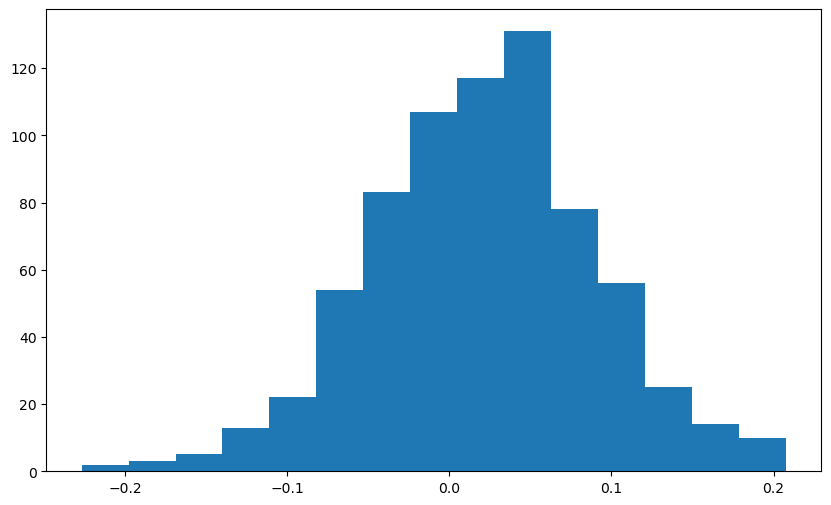

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(highest_correlation_list, bins=15)
plt.show()

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.stats import spearmanr

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))

# Combine all dictionaries into a single comprehensive dictionary
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# Define the desired order for the columns
desired_order = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]

# Load the normalized single-cell data
check = sc.read_h5ad("raw_data/normalized_sc_cll_3ca.h5ad")

descriptions_to_keep = [
    'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
    'ZNF471', 'KCNH2', 'COBLL1', 'SOWAHC', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
    'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
    'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
    'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
    'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
    'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
    'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
    'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
    'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2'
]


adata_filtered = check[:, check.var.index.isin(descriptions_to_keep)]

# Step 1: Subset the AnnData object to include only the sample 'CRC-0004'
ec_profiles = pd.DataFrame(adata_combined_normalized.X.T, index=adata_combined_normalized.var_names, columns=adata_combined_normalized.obs['ec_name'])

# Step 2: Compute Spearman correlation for each sample
# Create a DataFrame to store the correlation results
correlation_results = pd.DataFrame(index=adata_filtered.obs.index, columns=ec_profiles.columns)

def compute_spearman_correlations(sample_expression, ec_profiles):
    correlations = {}
    for ec_type in ec_profiles.columns:
        ec_expression = ec_profiles[ec_type]
        # Check if there are NaNs in the data
        if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
            correlations[ec_type] = np.nan
        # Check if the data is constant
        elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0:
            correlations[ec_type] = np.nan
        else:
            correlation, _ = spearmanr(sample_expression, ec_expression)
            correlations[ec_type] = correlation
    return correlations

# Iterate over each sample in the AnnData object
for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

# Dictionary to store the highest EC type for each sample
closest_ec_types_per_sample = {}
highest_correlation_list = []
for sample_id in correlation_results.index:

    # Remove NaN values before identifying the highest correlation
    valid_correlations = correlation_results.loc[sample_id].dropna()
    if not valid_correlations.empty:
        highest_ec_type = valid_correlations.idxmax()
        highest_correlation = valid_correlations[highest_ec_type]
        highest_correlation_list.append(highest_correlation)
        close_ec_types = valid_correlations[valid_correlations >= highest_correlation].index.tolist()
        closest_ec_types_per_sample[sample_id] = close_ec_types

# Display the correlation results and closest EC types

print("\nClosest EC types per sample:")
for sample_id, ec_types in closest_ec_types_per_sample.items():
    print(f"{sample_id}: {ec_types}")


Closest EC types per sample:
CLL03_T0_cDNA_A10_S202: ['EC-i']
CLL03_T0_cDNA_A11_S203: ['EC-i']
CLL03_T0_cDNA_A12_S204: ['EC-u2']
CLL03_T0_cDNA_A1_S193: ['EC-i']
CLL03_T0_cDNA_A2_S194: ['EC-m2']
CLL03_T0_cDNA_A3_S195: ['EC-i']
CLL03_T0_cDNA_A4_S196: ['EC-m2']
CLL03_T0_cDNA_A5_S197: ['EC-i']
CLL03_T0_cDNA_A6_S198: ['EC-m2']
CLL03_T0_cDNA_A7_S199: ['EC-i']
CLL03_T0_cDNA_A8_S200: ['EC-i']
CLL03_T0_cDNA_A9_S201: ['EC-i']
CLL03_T0_cDNA_B10_S214: ['EC-i']
CLL03_T0_cDNA_B11_S215: ['EC-m2']
CLL03_T0_cDNA_B12_S216: ['EC-i']
CLL03_T0_cDNA_B1_S205: ['EC-i']
CLL03_T0_cDNA_B2_S206: ['EC-i']
CLL03_T0_cDNA_B3_S207: ['EC-i']
CLL03_T0_cDNA_B4_S208: ['EC-u1']
CLL03_T0_cDNA_B5_S209: ['EC-i']
CLL03_T0_cDNA_B6_S210: ['EC-i']
CLL03_T0_cDNA_B7_S211: ['EC-i']
CLL03_T0_cDNA_B8_S212: ['EC-u1']
CLL03_T0_cDNA_B9_S213: ['EC-i']
CLL03_T0_cDNA_C10_S226: ['EC-i']
CLL03_T0_cDNA_C11_S227: ['EC-i']
CLL03_T0_cDNA_C12_S228: ['EC-i']
CLL03_T0_cDNA_C1_S217: ['EC-i']
CLL03_T0_cDNA_C2_S218: ['EC-i']
CLL03_T0_cDNA_C3_S219: ['E

/tmp/ipykernel_2605329/2376674698.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_filtered.obs['highest_ec_type'] = highest_ec_type


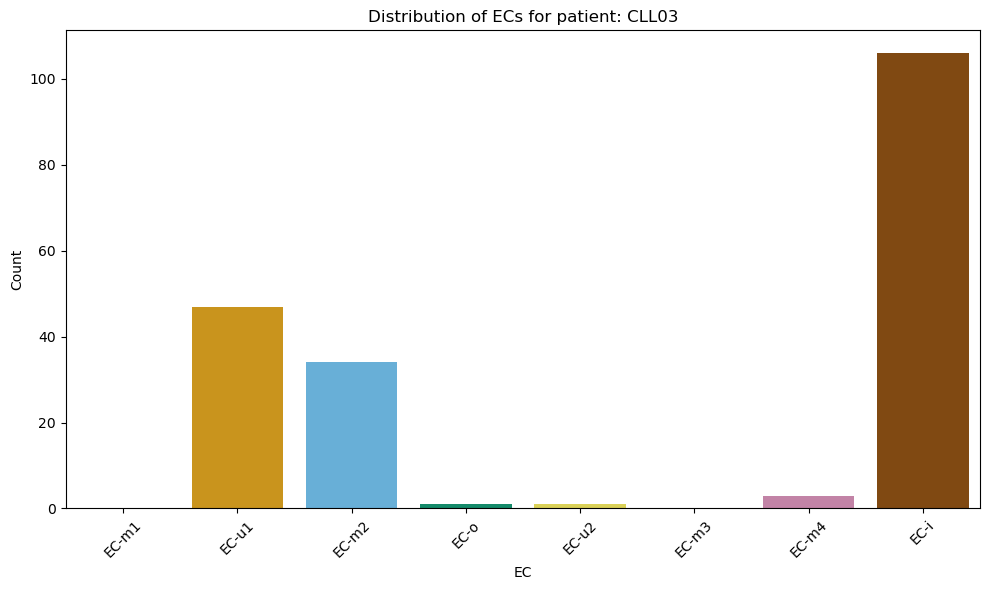

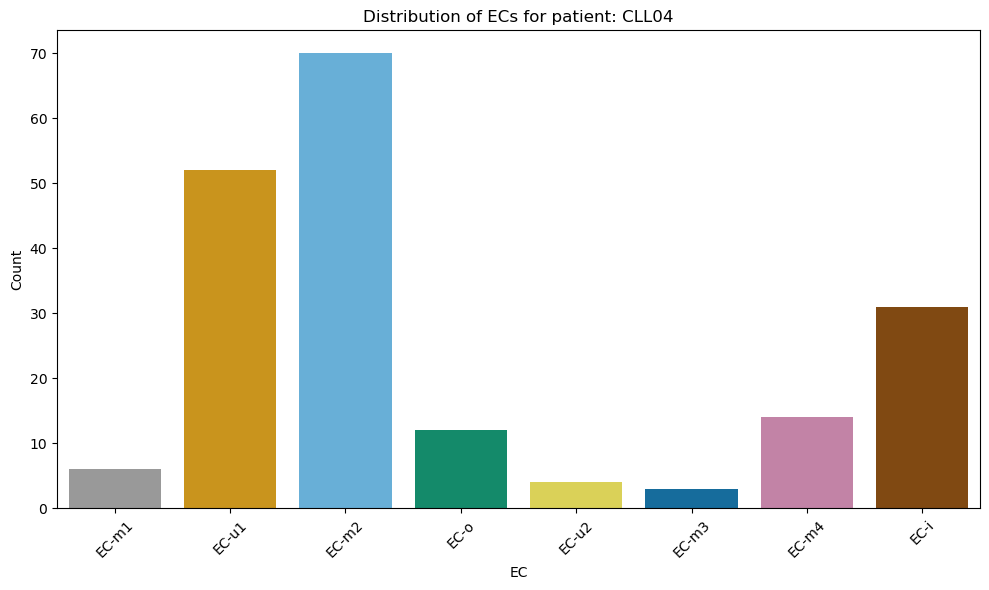

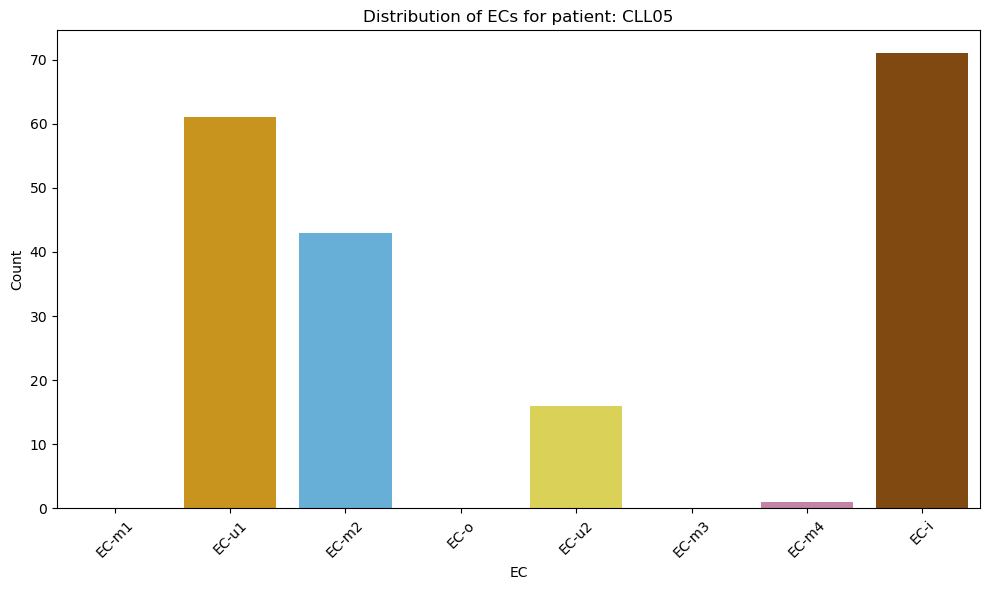

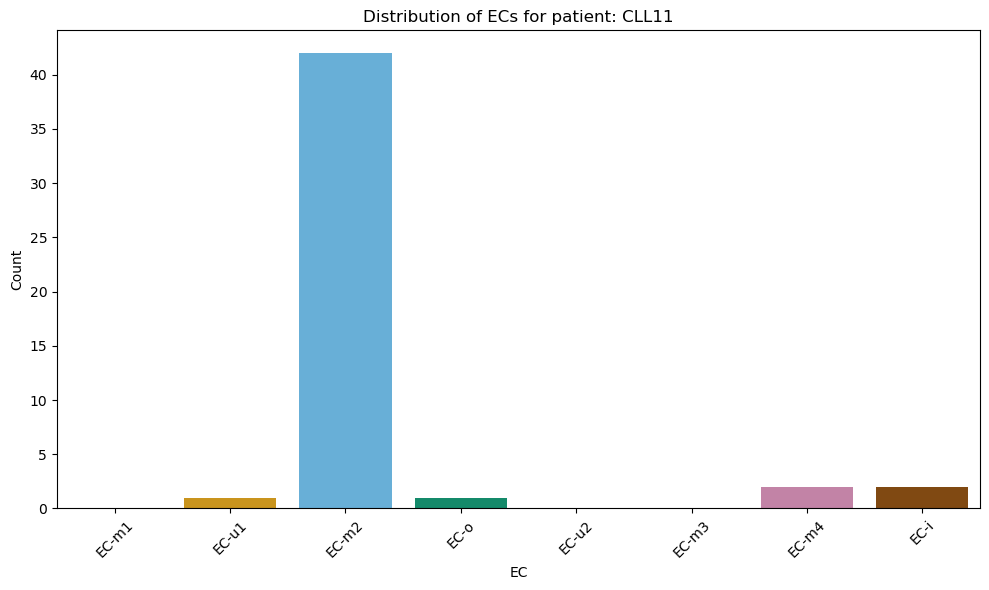

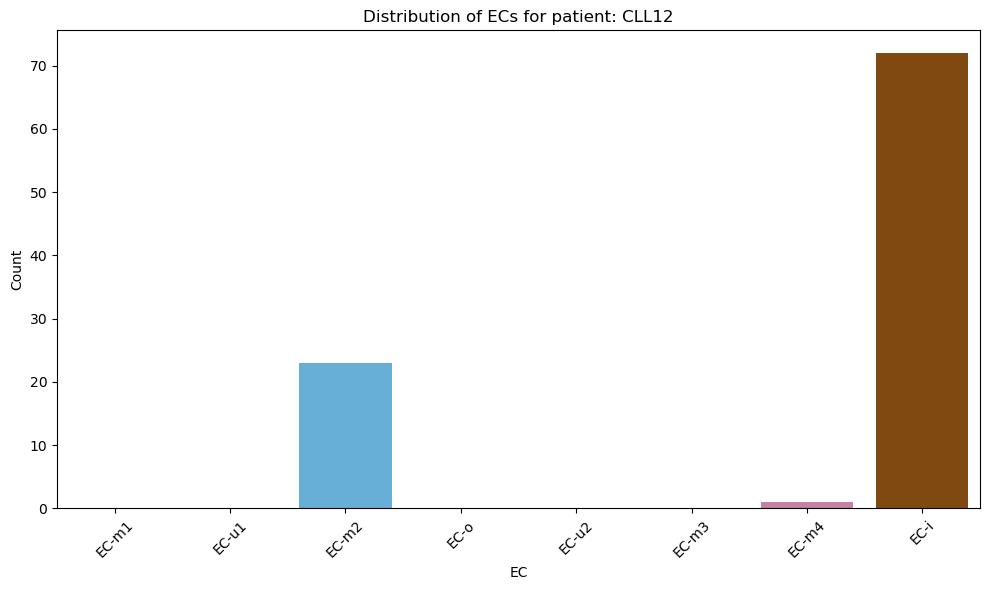

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Identify the EC type with the highest correlation for each cell
highest_ec_type = correlation_results.idxmax(axis=1)

# Step 2: Add the highest EC type to the original AnnData object
adata_filtered.obs['highest_ec_type'] = highest_ec_type

# Step 3: Group by patient and EC type to get the count of cells for each EC type per patient
# Set observed=True to prevent the FutureWarning
patient_ec_distribution = adata_filtered.obs.groupby(['patient', 'highest_ec_type'], observed=True).size().unstack(fill_value=0)

# Step 4: Plot the distribution of EC types for each patient
for patient in patient_ec_distribution.index:
    plt.figure(figsize=(10, 6))
    patient_data = patient_ec_distribution.loc[patient].reindex(EC_NAMES, fill_value=0)
    
    # Use hue to map EC types to colors and avoid the seaborn FutureWarning
    sns.barplot(x=patient_data.index, y=patient_data.values, hue=patient_data.index, palette=EC_COLOR_LIST, dodge=False, legend=False)
    
    plt.title(f'Distribution of ECs for patient: {patient}')
    plt.xlabel('EC')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [36]:
print(adata_filtered.obs.index)

Index(['CLL03_T0_cDNA_A10_S202', 'CLL03_T0_cDNA_A11_S203',
       'CLL03_T0_cDNA_A12_S204', 'CLL03_T0_cDNA_A1_S193',
       'CLL03_T0_cDNA_A2_S194', 'CLL03_T0_cDNA_A3_S195',
       'CLL03_T0_cDNA_A4_S196', 'CLL03_T0_cDNA_A5_S197',
       'CLL03_T0_cDNA_A6_S198', 'CLL03_T0_cDNA_A7_S199',
       ...
       'CLL12_cDNA_H12_S192', 'CLL12_cDNA_H1_S181', 'CLL12_cDNA_H2_S182',
       'CLL12_cDNA_H3_S183', 'CLL12_cDNA_H4_S184', 'CLL12_cDNA_H5_S185',
       'CLL12_cDNA_H6_S186', 'CLL12_cDNA_H7_S187', 'CLL12_cDNA_H9_S189',
       'CLL12_cDNA_H8_S188'],
      dtype='object', name='cell_name', length=720)


/tmp/ipykernel_2605329/2520169099.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_treatment_data.index, y=patient_treatment_data.values, palette=EC_COLOR_LIST)


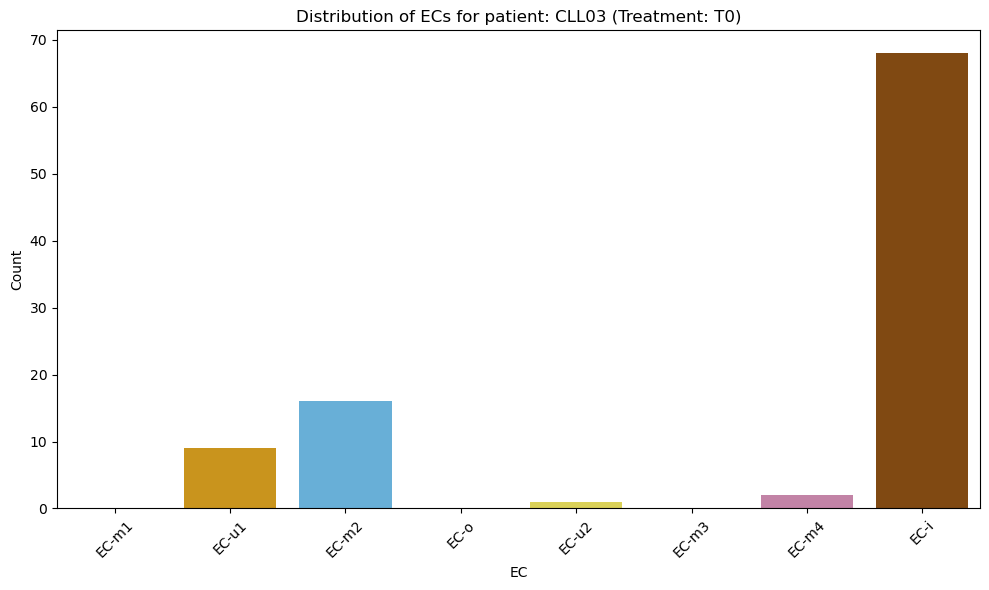

/tmp/ipykernel_2605329/2520169099.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_treatment_data.index, y=patient_treatment_data.values, palette=EC_COLOR_LIST)


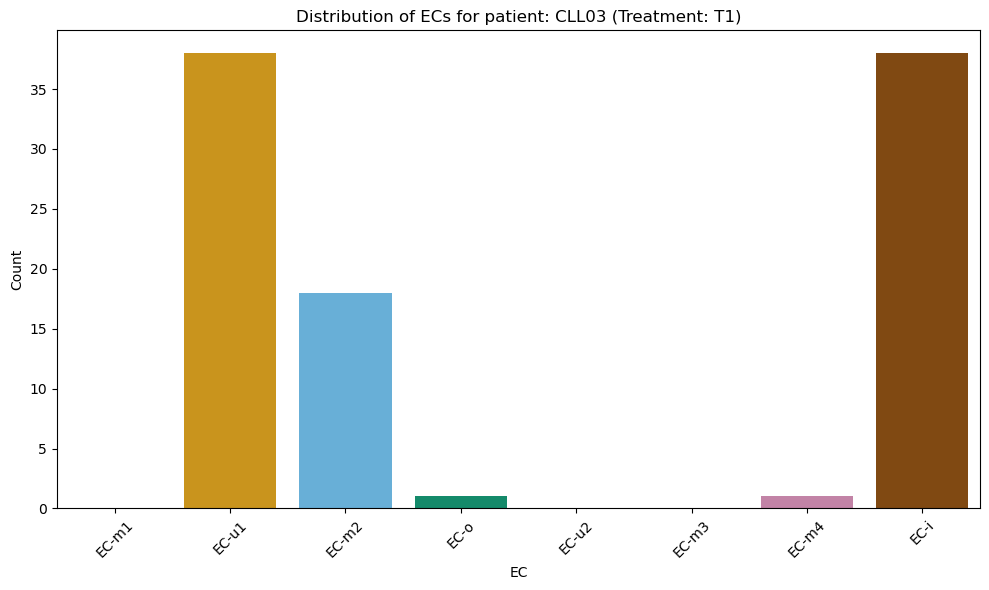

/tmp/ipykernel_2605329/2520169099.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_treatment_data.index, y=patient_treatment_data.values, palette=EC_COLOR_LIST)


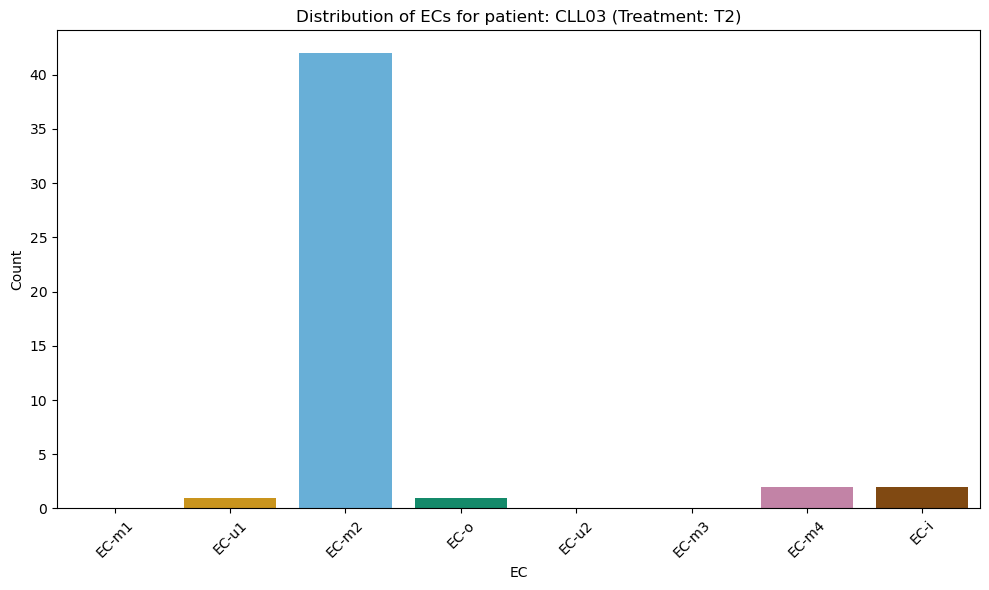

/tmp/ipykernel_2605329/2520169099.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_treatment_data.index, y=patient_treatment_data.values, palette=EC_COLOR_LIST)


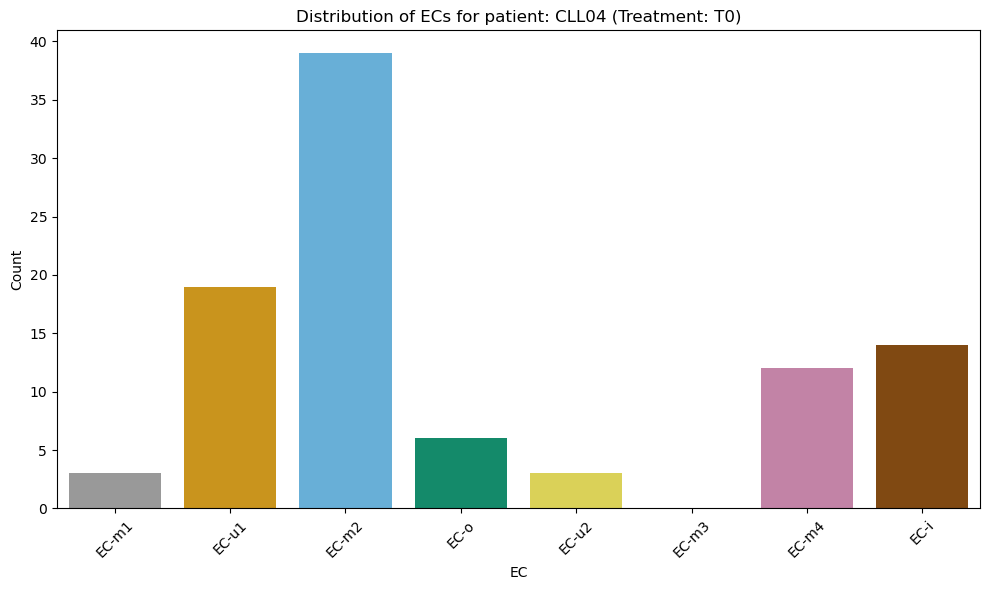

/tmp/ipykernel_2605329/2520169099.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_treatment_data.index, y=patient_treatment_data.values, palette=EC_COLOR_LIST)


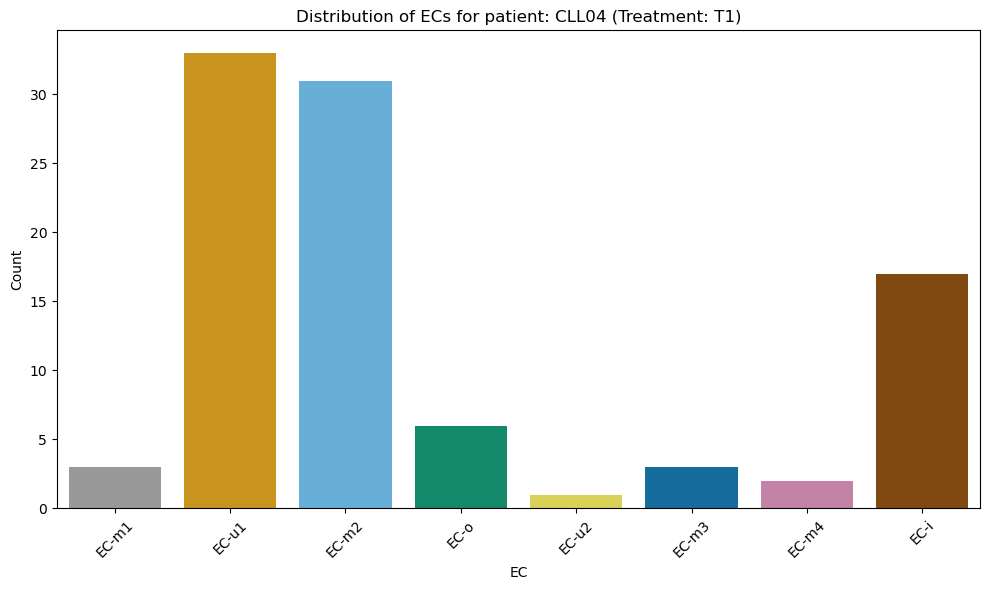

/tmp/ipykernel_2605329/2520169099.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_treatment_data.index, y=patient_treatment_data.values, palette=EC_COLOR_LIST)


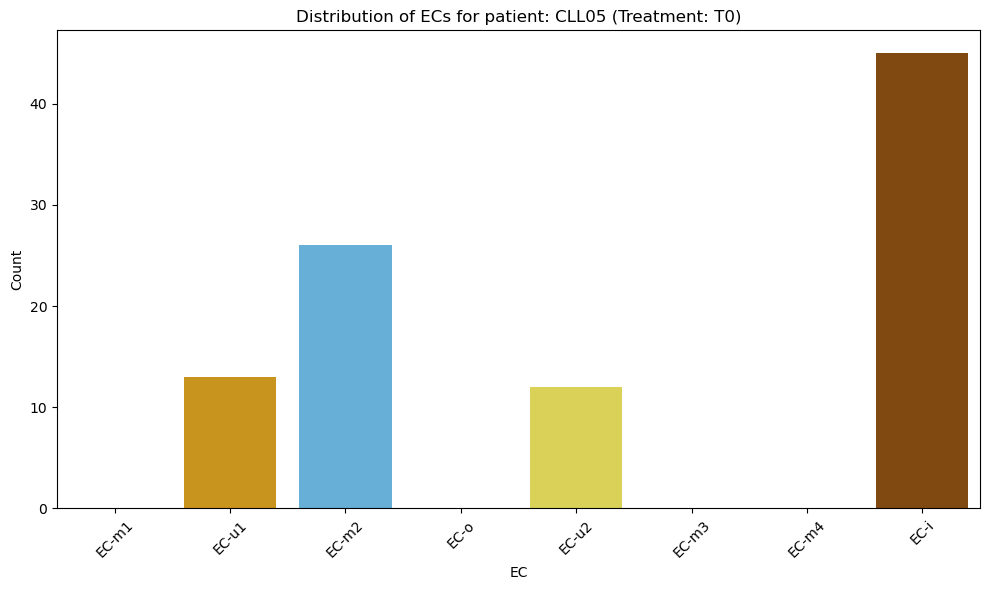

/tmp/ipykernel_2605329/2520169099.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_treatment_data.index, y=patient_treatment_data.values, palette=EC_COLOR_LIST)


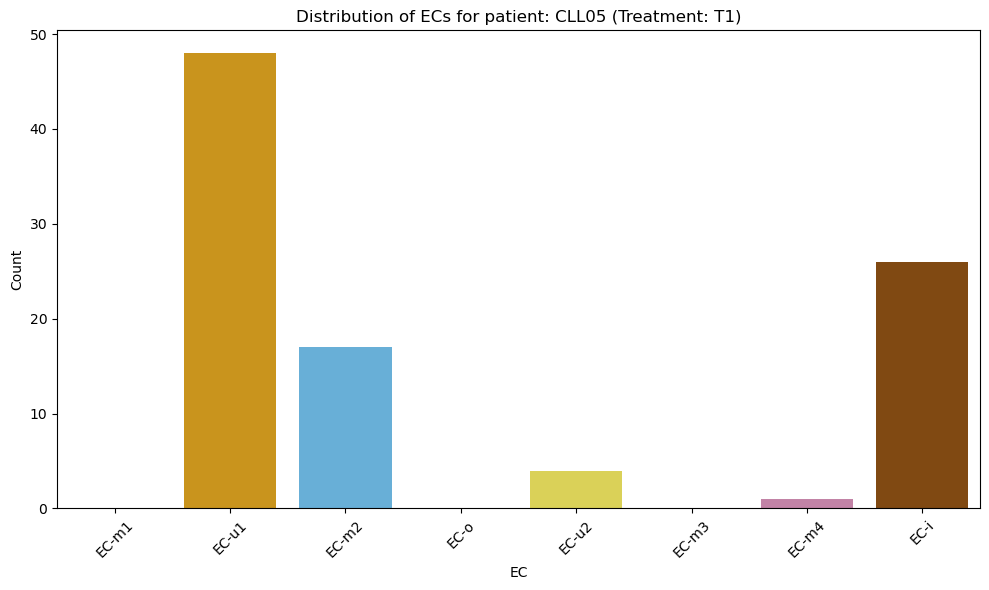

/tmp/ipykernel_2605329/2520169099.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_treatment_data.index, y=patient_treatment_data.values, palette=EC_COLOR_LIST)


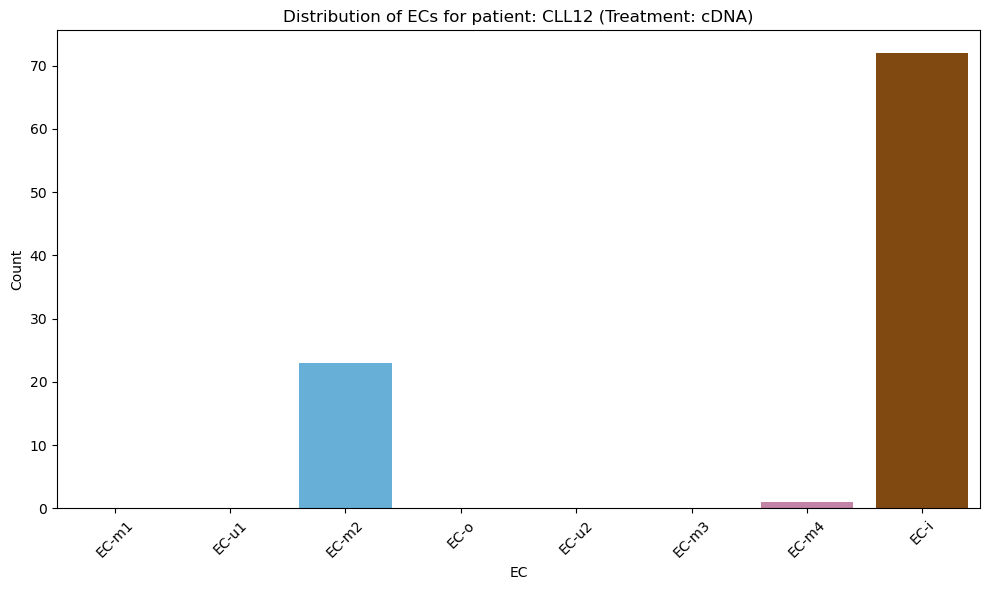

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Identify the EC type with the highest correlation for each cell
highest_ec_type = correlation_results.idxmax(axis=1)

# Step 2: Add the highest EC type to the original AnnData object
adata_filtered.obs['highest_ec_type'] = highest_ec_type

# Step 3: Extract patient and treatment from the sample_id
adata_filtered.obs['patient'] = adata_filtered.obs.index.to_series().apply(lambda x: x.split('_')[0])
adata_filtered.obs['treatment'] = adata_filtered.obs.index.to_series().apply(lambda x: x.split('_')[1])

# Alternative using list comprehension:
# adata_filtered.obs['patient'] = [x.split('_')[0] for x in adata_filtered.obs.index]
# adata_filtered.obs['treatment'] = [x.split('_')[1] for x in adata_filtered.obs.index]

# Step 4: Group by patient, treatment, and EC type to get the count of cells for each combination
patient_treatment_ec_distribution = adata_filtered.obs.groupby(['patient', 'treatment', 'highest_ec_type'], observed=True).size().unstack(fill_value=0)

# Step 5: Plot the distribution of EC types for each patient and treatment
for patient in patient_treatment_ec_distribution.index.get_level_values(0).unique():
    for treatment in patient_treatment_ec_distribution.loc[patient].index.get_level_values(0).unique():
        plt.figure(figsize=(10, 6))
        patient_treatment_data = patient_treatment_ec_distribution.loc[(patient, treatment)].reindex(EC_NAMES, fill_value=0)
        
        # Use hue to map EC types to colors and avoid the seaborn FutureWarning
        sns.barplot(x=patient_treatment_data.index, y=patient_treatment_data.values, palette=EC_COLOR_LIST)
        
        plt.title(f'Distribution of ECs for patient: {patient} (Treatment: {treatment})')
        plt.xlabel('EC')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [38]:
closest_ec_types_per_sample

{'CLL03_T0_cDNA_A10_S202': ['EC-i'],
 'CLL03_T0_cDNA_A11_S203': ['EC-i'],
 'CLL03_T0_cDNA_A12_S204': ['EC-u2'],
 'CLL03_T0_cDNA_A1_S193': ['EC-i'],
 'CLL03_T0_cDNA_A2_S194': ['EC-m2'],
 'CLL03_T0_cDNA_A3_S195': ['EC-i'],
 'CLL03_T0_cDNA_A4_S196': ['EC-m2'],
 'CLL03_T0_cDNA_A5_S197': ['EC-i'],
 'CLL03_T0_cDNA_A6_S198': ['EC-m2'],
 'CLL03_T0_cDNA_A7_S199': ['EC-i'],
 'CLL03_T0_cDNA_A8_S200': ['EC-i'],
 'CLL03_T0_cDNA_A9_S201': ['EC-i'],
 'CLL03_T0_cDNA_B10_S214': ['EC-i'],
 'CLL03_T0_cDNA_B11_S215': ['EC-m2'],
 'CLL03_T0_cDNA_B12_S216': ['EC-i'],
 'CLL03_T0_cDNA_B1_S205': ['EC-i'],
 'CLL03_T0_cDNA_B2_S206': ['EC-i'],
 'CLL03_T0_cDNA_B3_S207': ['EC-i'],
 'CLL03_T0_cDNA_B4_S208': ['EC-u1'],
 'CLL03_T0_cDNA_B5_S209': ['EC-i'],
 'CLL03_T0_cDNA_B6_S210': ['EC-i'],
 'CLL03_T0_cDNA_B7_S211': ['EC-i'],
 'CLL03_T0_cDNA_B8_S212': ['EC-u1'],
 'CLL03_T0_cDNA_B9_S213': ['EC-i'],
 'CLL03_T0_cDNA_C10_S226': ['EC-i'],
 'CLL03_T0_cDNA_C11_S227': ['EC-i'],
 'CLL03_T0_cDNA_C12_S228': ['EC-i'],
 'CLL03_T0_c

/tmp/ipykernel_2605329/3113483021.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)


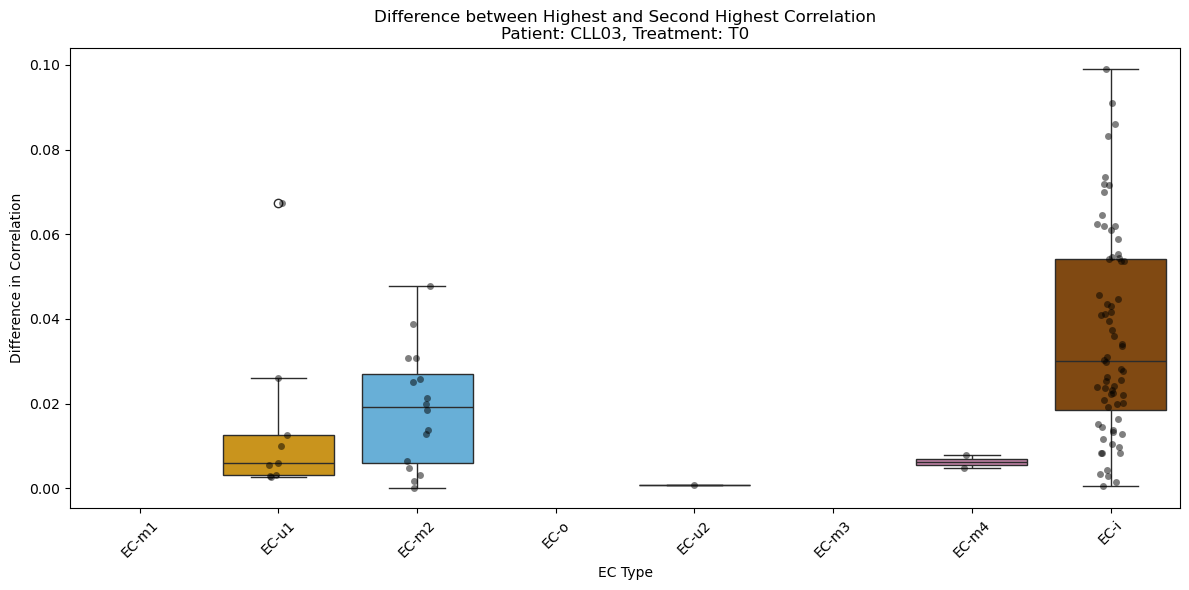

/tmp/ipykernel_2605329/3113483021.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)


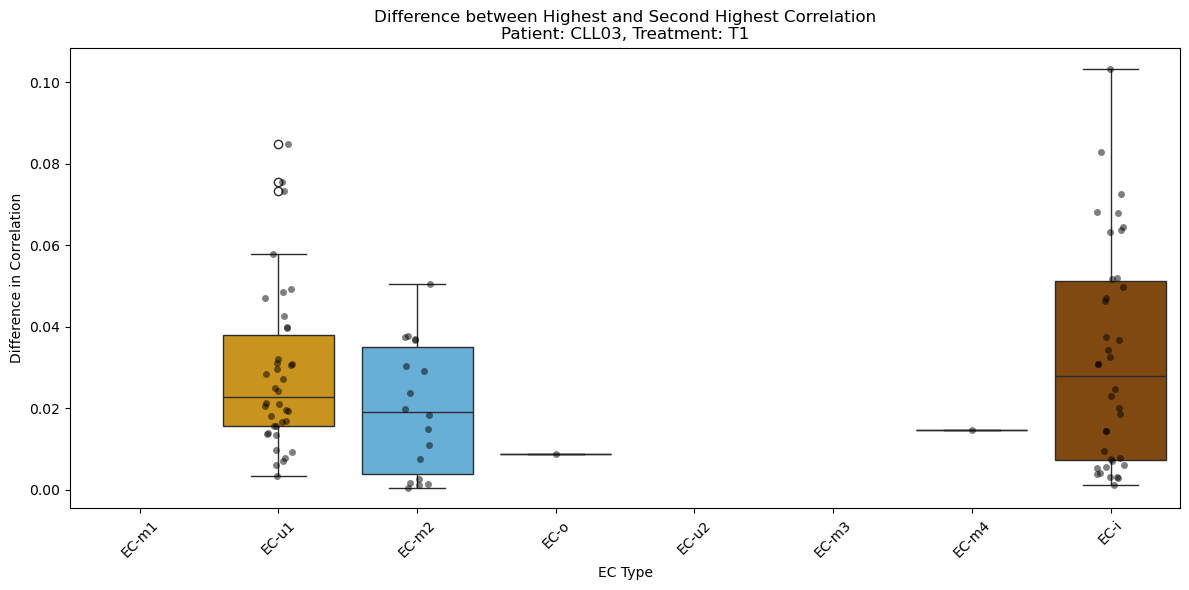

/tmp/ipykernel_2605329/3113483021.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)


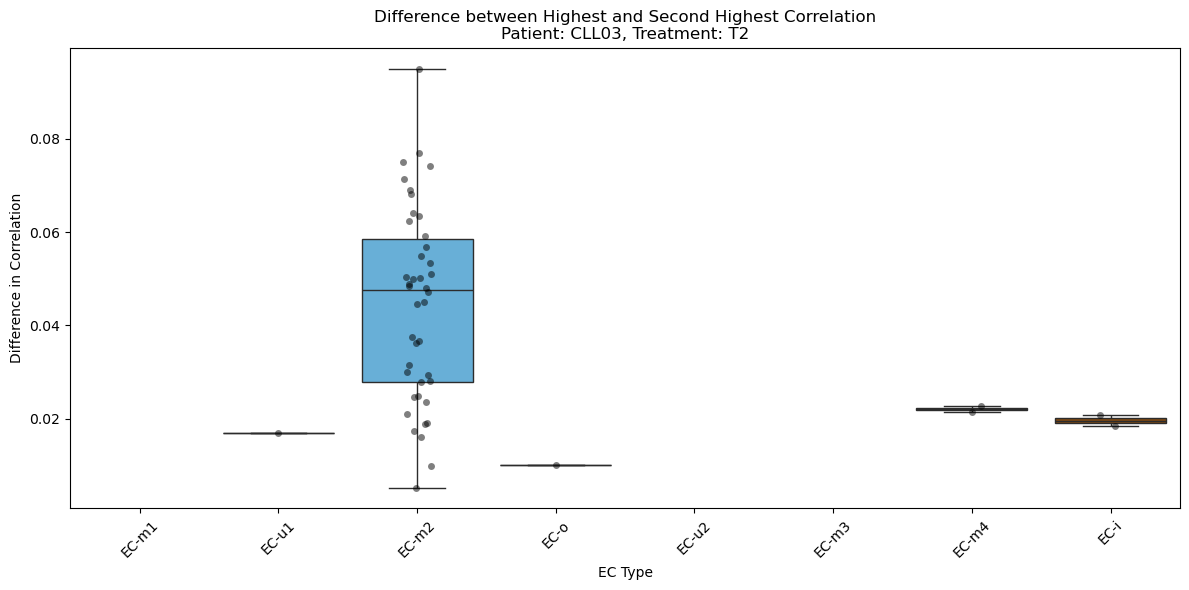

/tmp/ipykernel_2605329/3113483021.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)


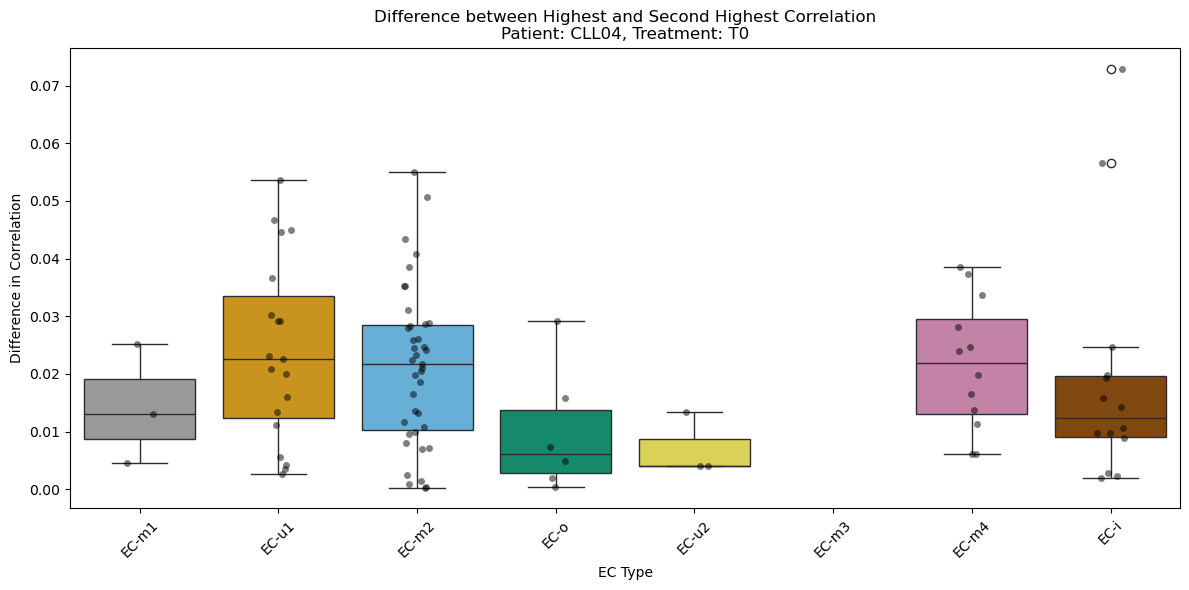

/tmp/ipykernel_2605329/3113483021.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)


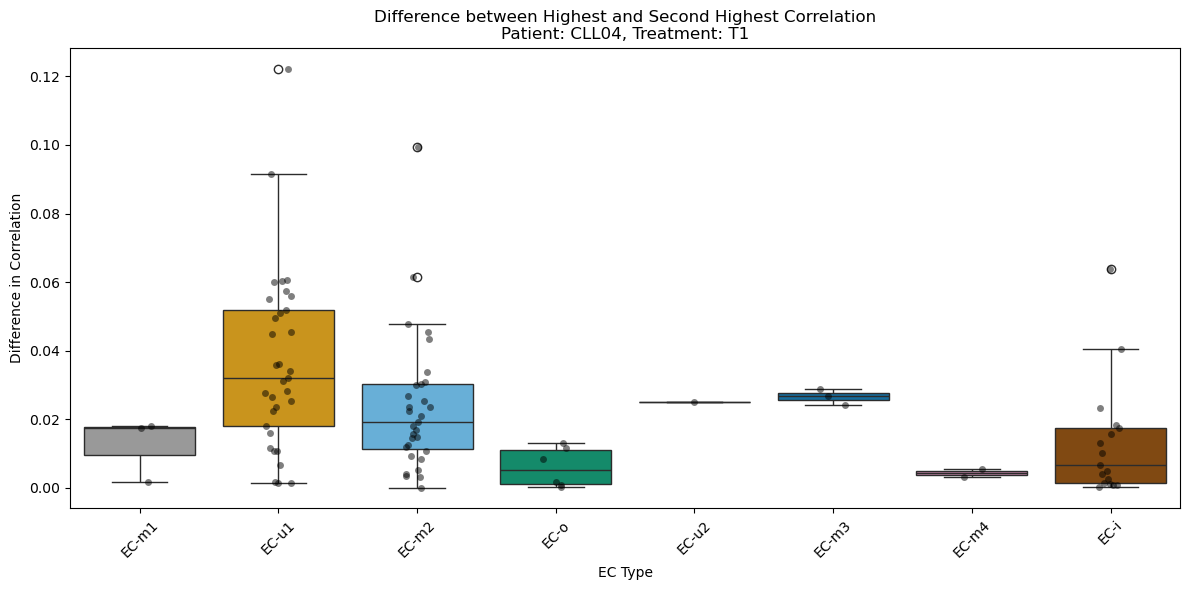

/tmp/ipykernel_2605329/3113483021.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)


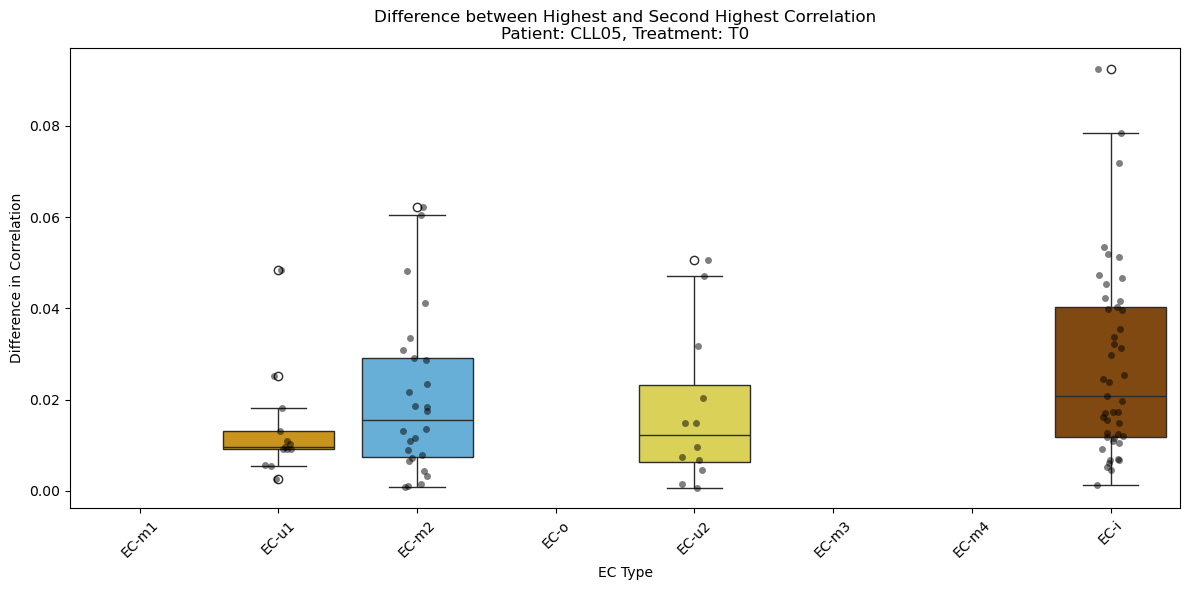

/tmp/ipykernel_2605329/3113483021.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)


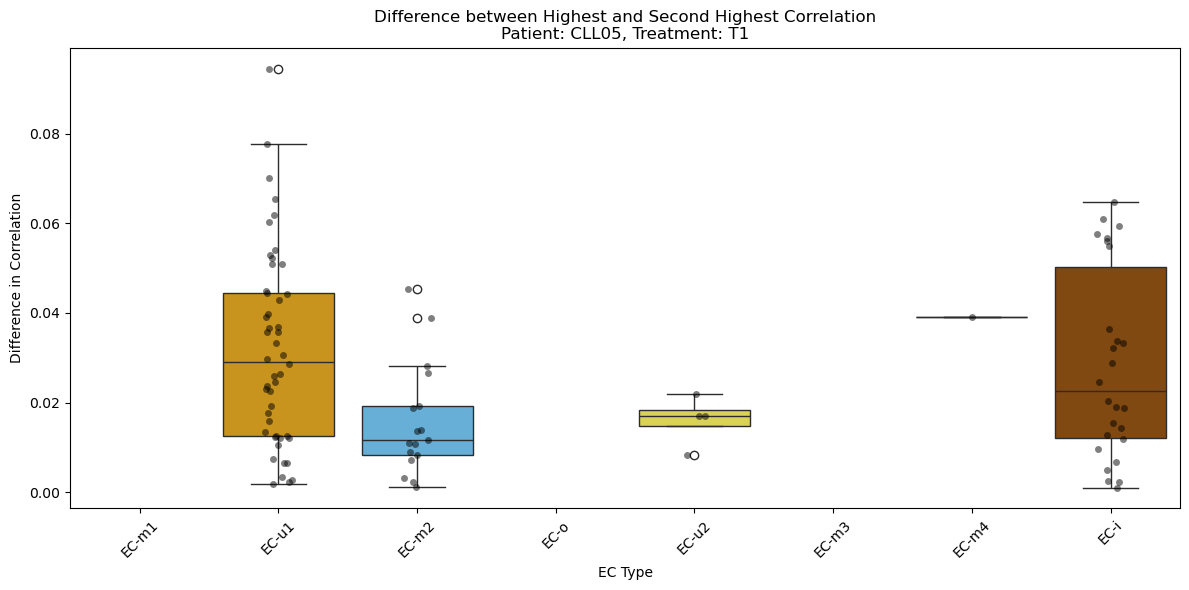

/tmp/ipykernel_2605329/3113483021.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)


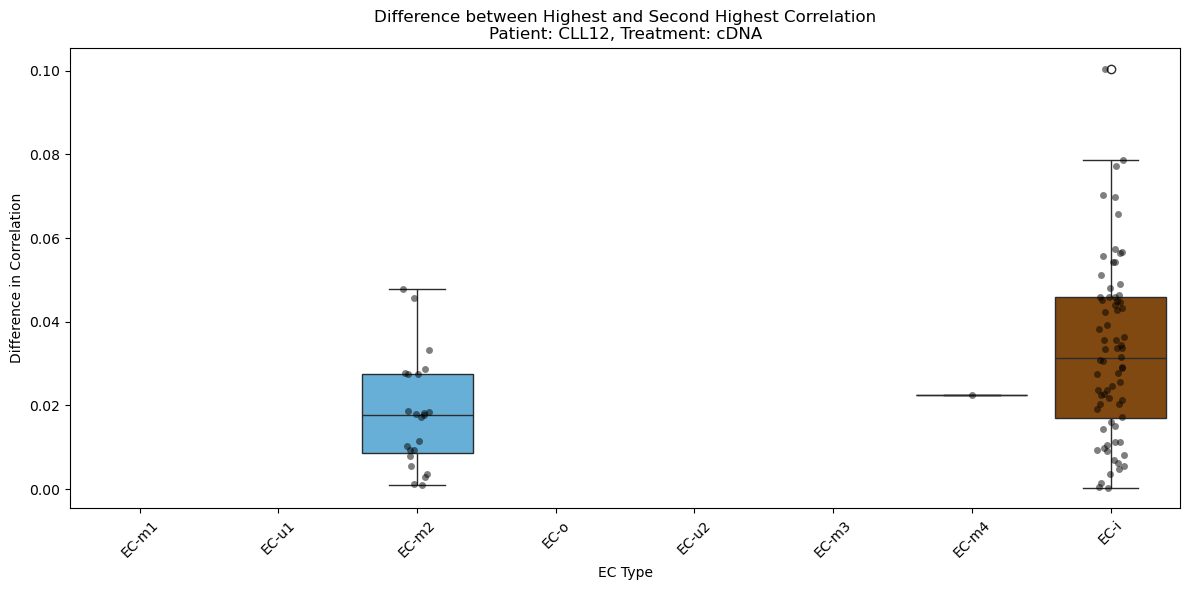

In [39]:
# Compute the differences between highest and second highest correlations
correlation_diff = pd.DataFrame(index=correlation_results.index, columns=['EC', 'Difference'])

for sample_id in correlation_results.index:
    valid_correlations = pd.to_numeric(correlation_results.loc[sample_id].dropna(), errors='coerce')
    if valid_correlations.size > 1:
        highest_corr = valid_correlations.nlargest(2)
        correlation_diff.loc[sample_id] = [highest_corr.index[0], highest_corr.iloc[0] - highest_corr.iloc[1]]
    elif valid_correlations.size == 1:
        correlation_diff.loc[sample_id] = [valid_correlations.index[0], valid_correlations.iloc[0]]
    else:
        correlation_diff.loc[sample_id] = [np.nan, np.nan]
        
# Extract patient and treatment information from cell_name
correlation_diff['Patient'] = correlation_diff.index.str.split('_').str[0]
correlation_diff['Treatment'] = correlation_diff.index.str.split('_').str[1]

# Convert the DataFrame to a format suitable for Seaborn boxplot
plot_data = correlation_diff.dropna().reset_index().rename(columns={'index': 'Sample'})

# Ensure EC types in plot_data match EC_NAMES
plot_data['EC'] = pd.Categorical(plot_data['EC'], categories=EC_NAMES, ordered=True)

# Plot the data for each patient and treatment
for patient in plot_data['Patient'].unique():
    for treatment in plot_data['Treatment'].unique():
        subset_data = plot_data[(plot_data['Patient'] == patient) & (plot_data['Treatment'] == treatment)]
        if not subset_data.empty:
            plt.figure(figsize=(12, 6))
            sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)
            sns.stripplot(x='EC', y='Difference', data=subset_data, jitter=True, color='black', alpha=0.5, order=EC_NAMES)
            plt.xlabel('EC Type')
            plt.ylabel('Difference in Correlation')
            plt.title(f'Difference between Highest and Second Highest Correlation\nPatient: {patient}, Treatment: {treatment}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

/tmp/ipykernel_2605329/542033496.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)


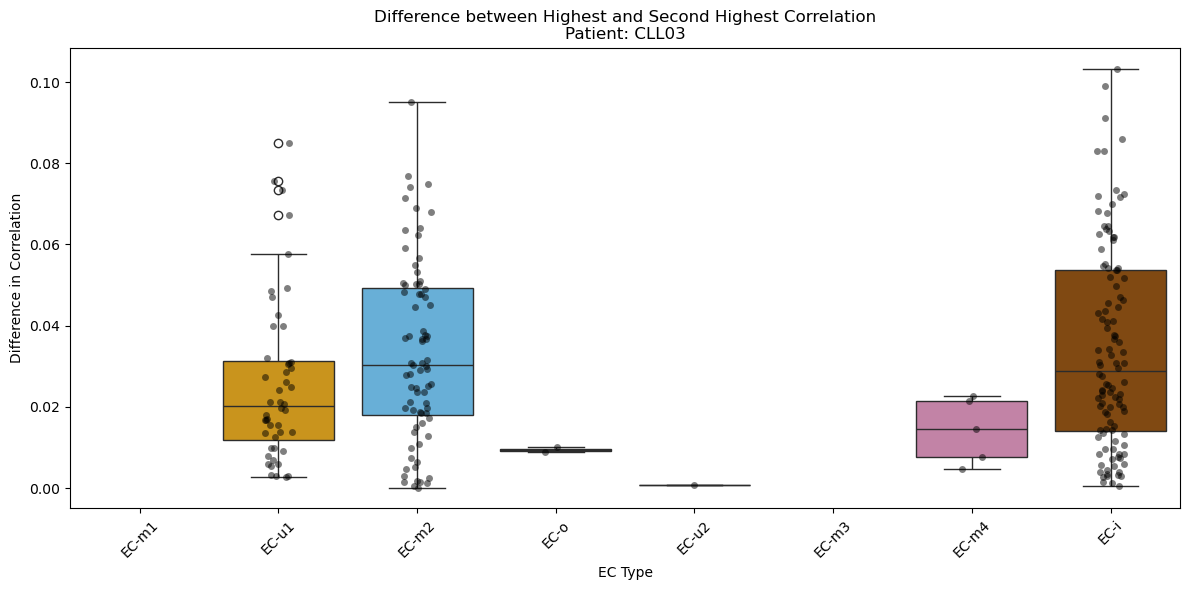

/tmp/ipykernel_2605329/542033496.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)


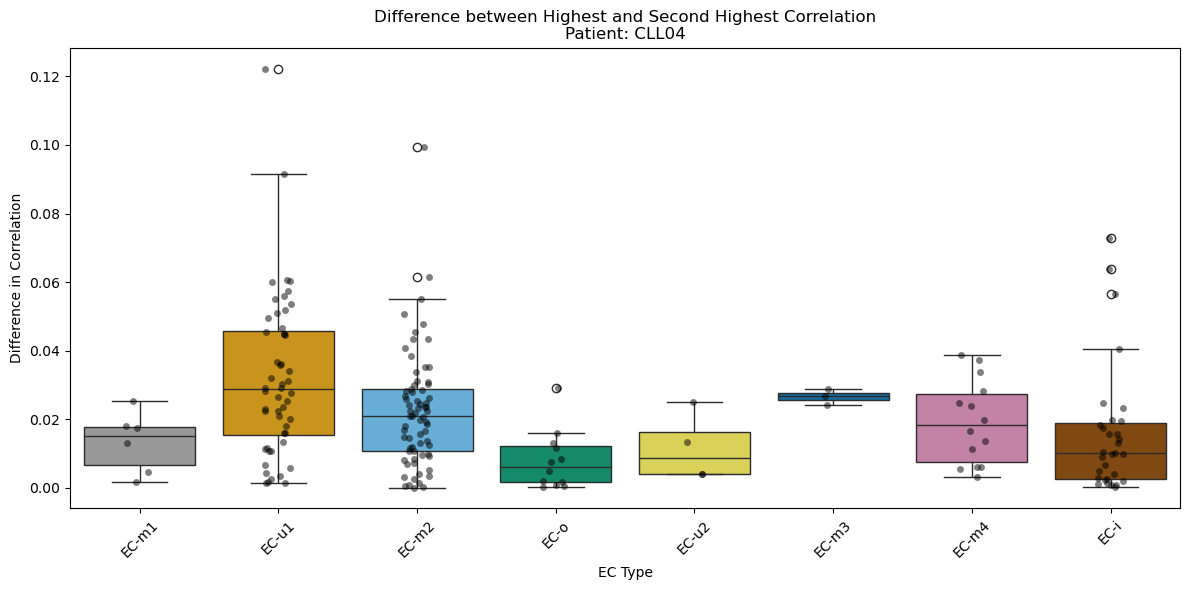

/tmp/ipykernel_2605329/542033496.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)


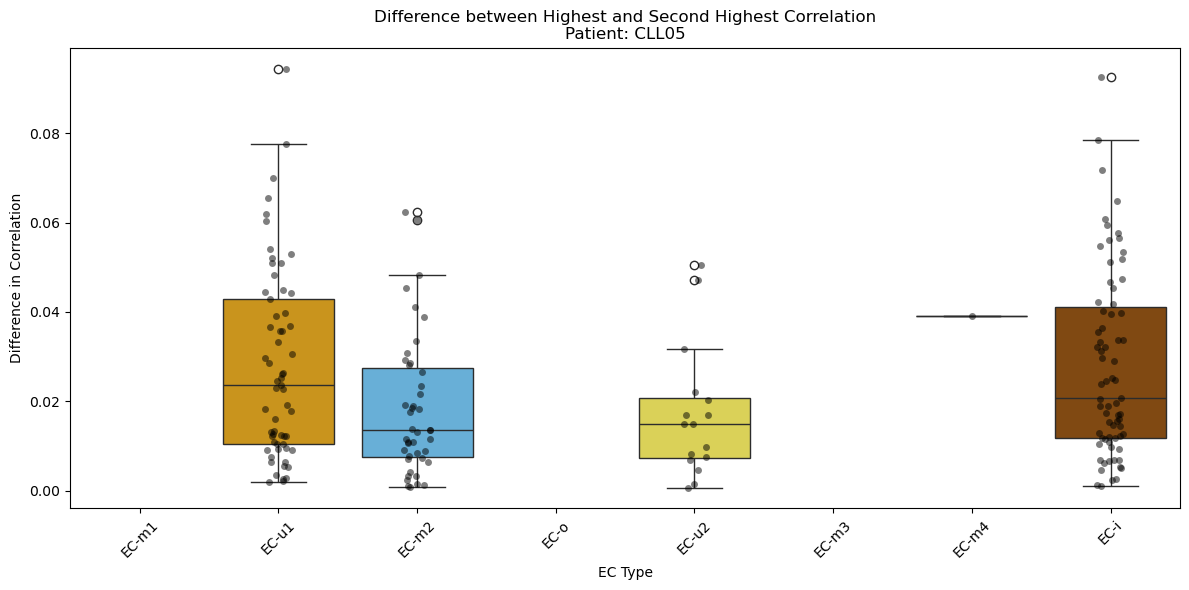

/tmp/ipykernel_2605329/542033496.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)


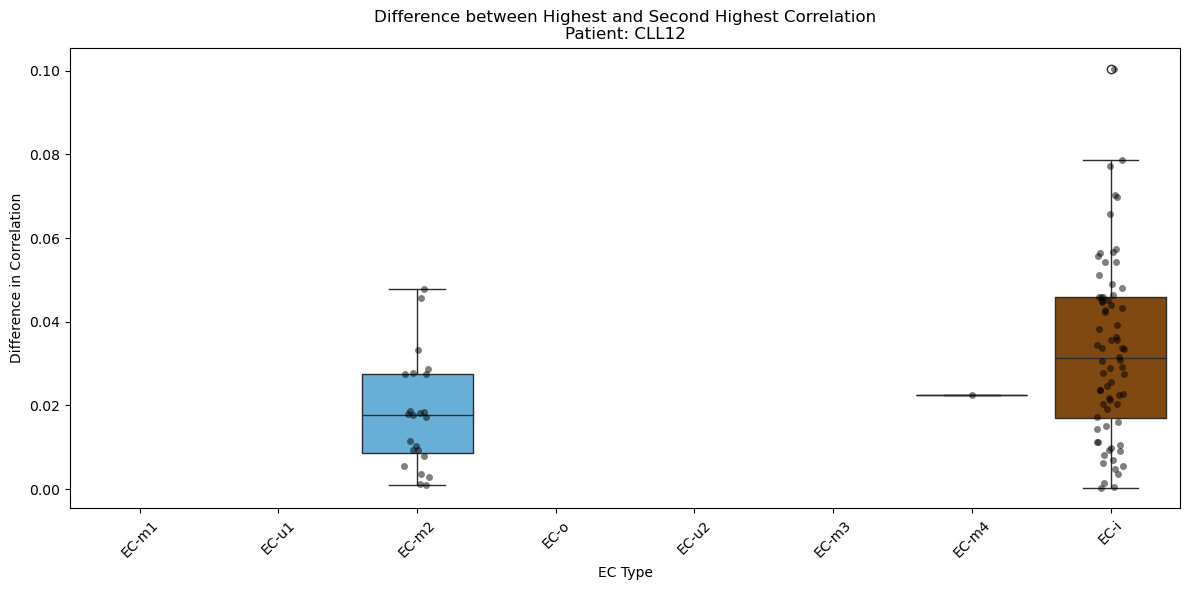

In [40]:
# Compute the differences between highest and second highest correlations
correlation_diff = pd.DataFrame(index=correlation_results.index, columns=['EC', 'Difference'])

for sample_id in correlation_results.index:
    valid_correlations = pd.to_numeric(correlation_results.loc[sample_id].dropna(), errors='coerce')
    if valid_correlations.size > 1:
        highest_corr = valid_correlations.nlargest(2)
        correlation_diff.loc[sample_id] = [highest_corr.index[0], highest_corr.iloc[0] - highest_corr.iloc[1]]
    elif valid_correlations.size == 1:
        correlation_diff.loc[sample_id] = [valid_correlations.index[0], valid_correlations.iloc[0]]
    else:
        correlation_diff.loc[sample_id] = [np.nan, np.nan]
        
# Extract patient and treatment information from cell_name
correlation_diff['Patient'] = correlation_diff.index.str.split('_').str[0]
correlation_diff['Treatment'] = correlation_diff.index.str.split('_').str[1]

# Convert the DataFrame to a format suitable for Seaborn boxplot
plot_data = correlation_diff.dropna().reset_index().rename(columns={'index': 'Sample'})

# Ensure EC types in plot_data match EC_NAMES
plot_data['EC'] = pd.Categorical(plot_data['EC'], categories=EC_NAMES, ordered=True)

# Plot the data for each patient and treatment
for patient in plot_data['Patient'].unique():
    subset_data = plot_data[(plot_data['Patient'] == patient)]
    if not subset_data.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)
        sns.stripplot(x='EC', y='Difference', data=subset_data, jitter=True, color='black', alpha=0.5, order=EC_NAMES)
        plt.xlabel('EC Type')
        plt.ylabel('Difference in Correlation')
        plt.title(f'Difference between Highest and Second Highest Correlation\nPatient: {patient}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

/tmp/ipykernel_972940/866452672.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Difference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


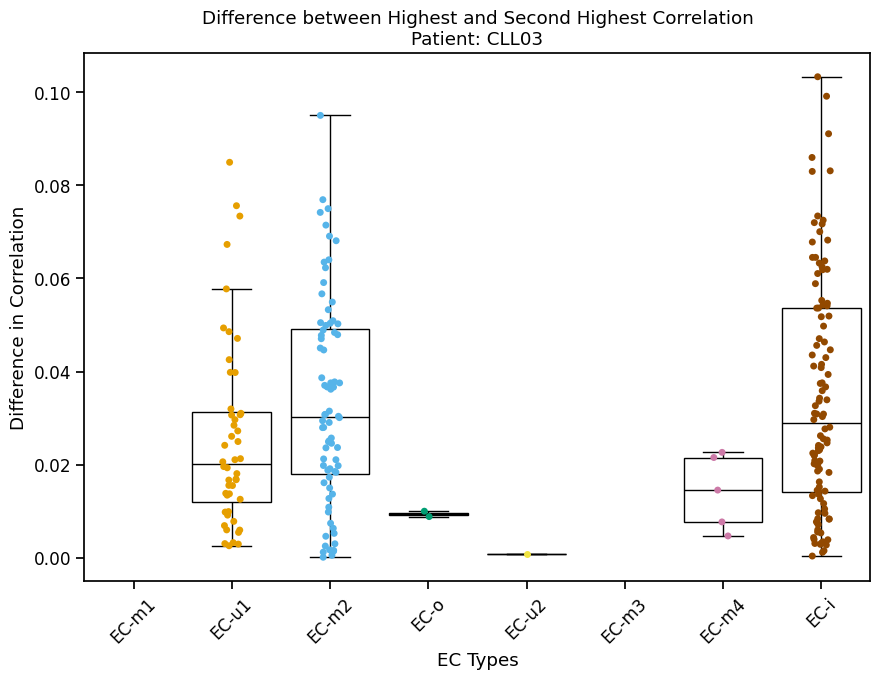

/tmp/ipykernel_972940/866452672.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Difference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


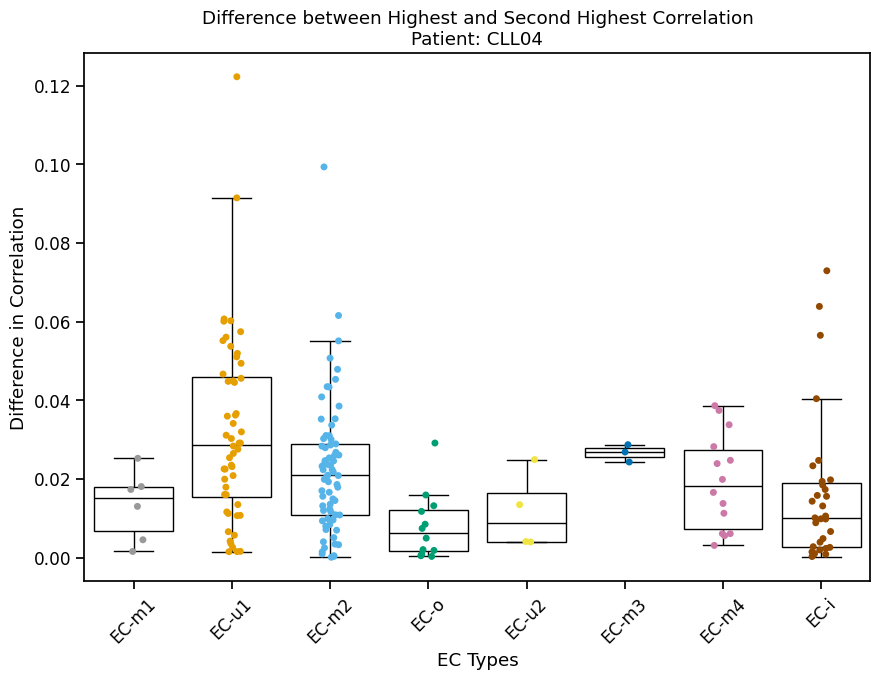

/tmp/ipykernel_972940/866452672.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Difference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


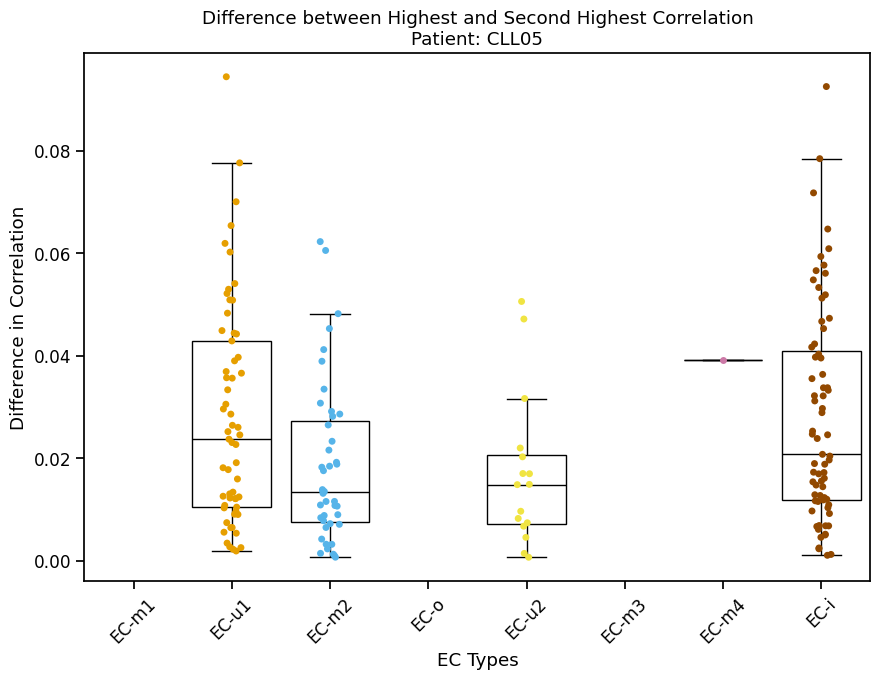

/tmp/ipykernel_972940/866452672.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='EC', y='Difference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


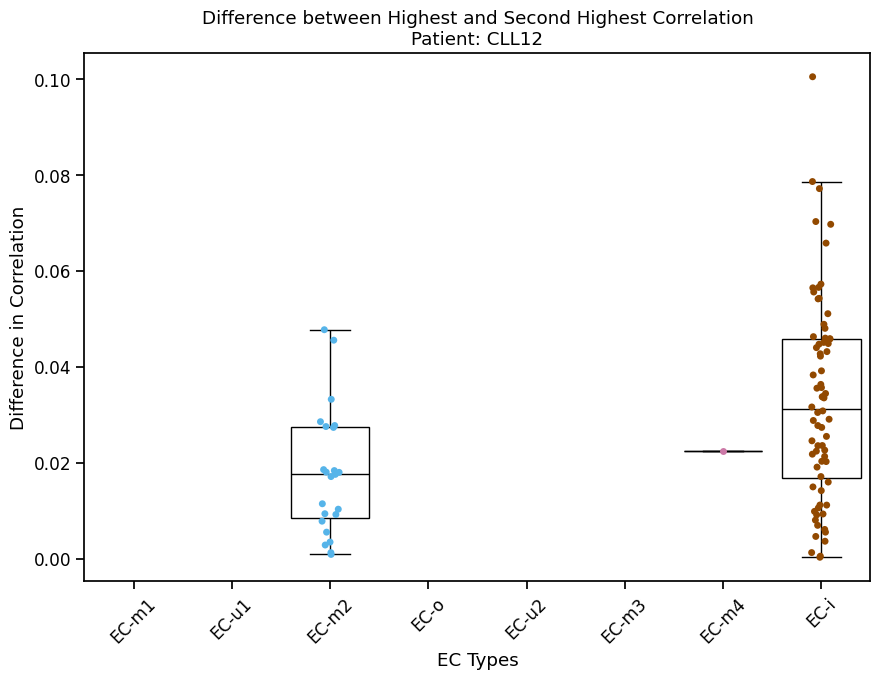

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Compute the differences between highest and second highest correlations
correlation_diff = pd.DataFrame(index=correlation_results.index, columns=['EC', 'Difference'])

for sample_id in correlation_results.index:
    valid_correlations = pd.to_numeric(correlation_results.loc[sample_id].dropna(), errors='coerce')
    if valid_correlations.size > 1:
        highest_corr = valid_correlations.nlargest(2)
        correlation_diff.loc[sample_id] = [highest_corr.index[0], highest_corr.iloc[0] - highest_corr.iloc[1]]
    elif valid_correlations.size == 1:
        correlation_diff.loc[sample_id] = [valid_correlations.index[0], valid_correlations.iloc[0]]
    else:
        correlation_diff.loc[sample_id] = [np.nan, np.nan]

# Extract patient and treatment information from cell_name
correlation_diff['Patient'] = correlation_diff.index.str.split('_').str[0]
correlation_diff['Treatment'] = correlation_diff.index.str.split('_').str[1]

# Convert the DataFrame to a format suitable for Seaborn boxplot
plot_data = correlation_diff.dropna().reset_index().rename(columns={'index': 'Sample'})

# Ensure EC types in plot_data match EC_NAMES
plot_data['EC'] = pd.Categorical(plot_data['EC'], categories=EC_NAMES, ordered=True)

# Plot the data for each patient
sns.set_context("notebook", font_scale=1.1)

for patient in plot_data['Patient'].unique():
    subset_data = plot_data[(plot_data['Patient'] == patient)]
    if not subset_data.empty:
        plt.figure(figsize=(9, 7))
        sns.boxplot(
            x='EC', y='Difference', data=subset_data, order=EC_NAMES, 
            boxprops=dict(facecolor='white', edgecolor='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='black'),
            showfliers=False
        )
        sns.stripplot(x='EC', y='Difference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)
        plt.xlabel('EC Types')
        plt.ylabel('Difference in Correlation')
        plt.title(f'Difference between Highest and Second Highest Correlation\nPatient: {patient}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


/tmp/ipykernel_2605329/307186147.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


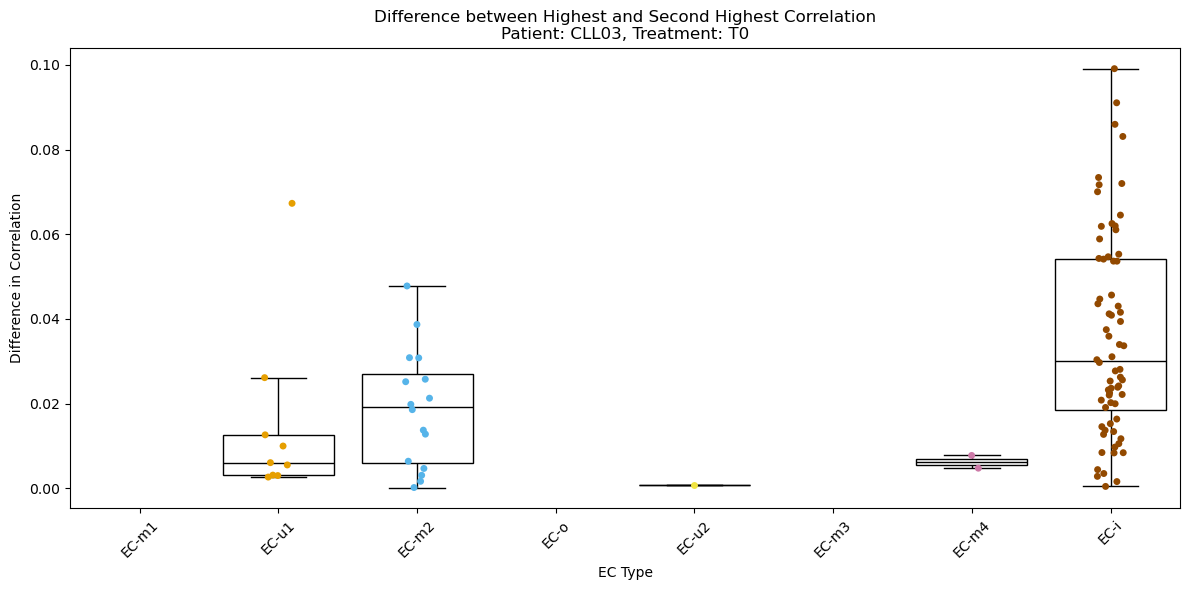

/tmp/ipykernel_2605329/307186147.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


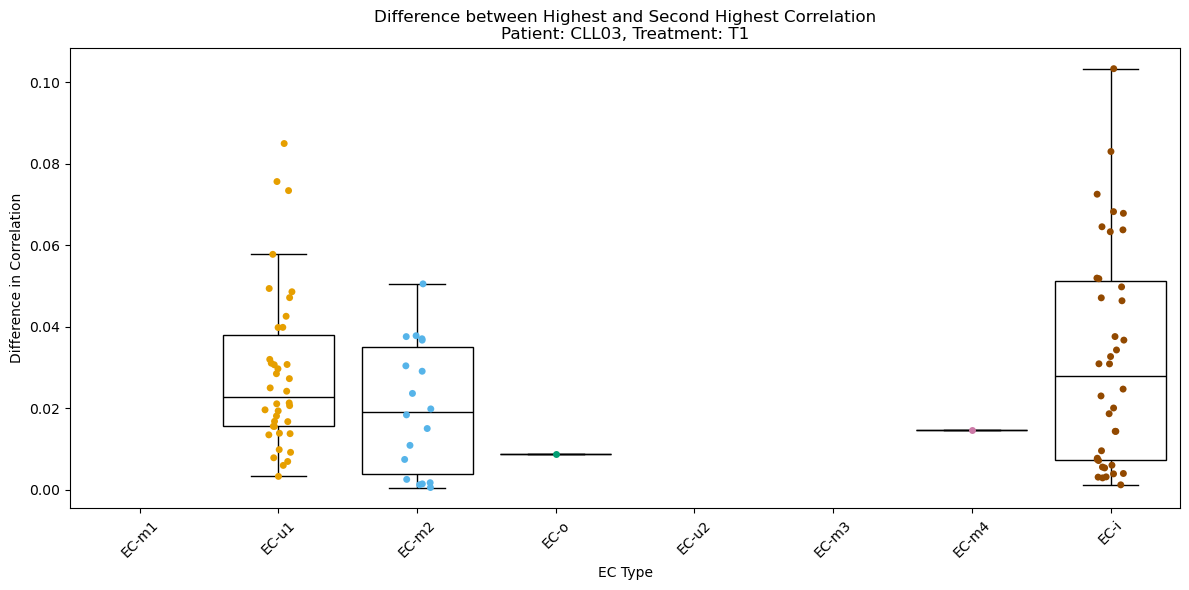

/tmp/ipykernel_2605329/307186147.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


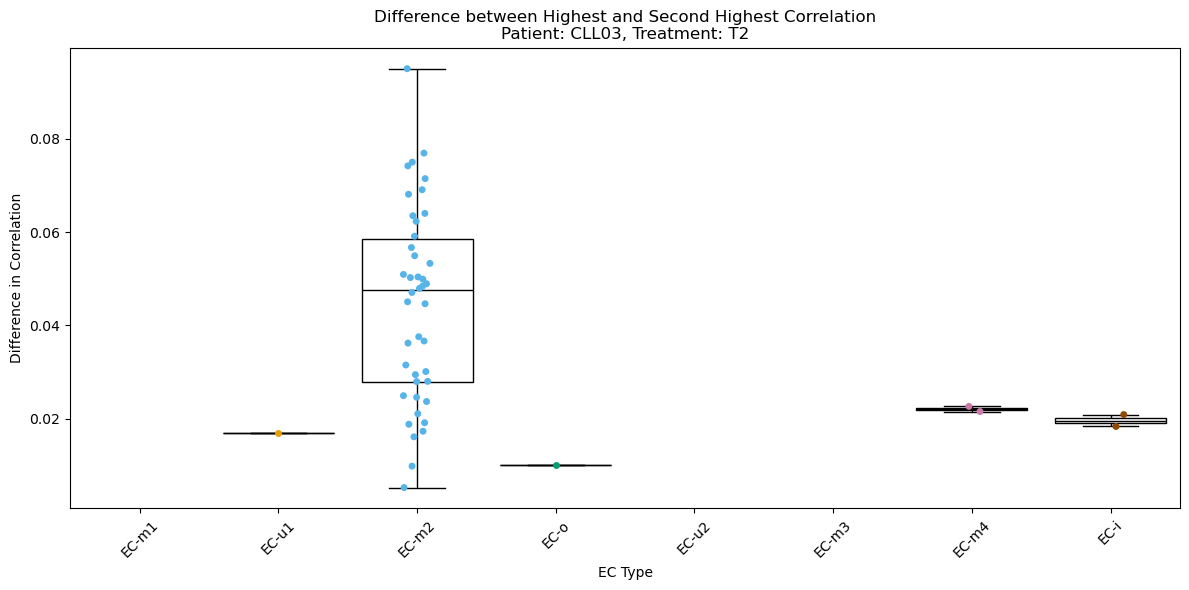

/tmp/ipykernel_2605329/307186147.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


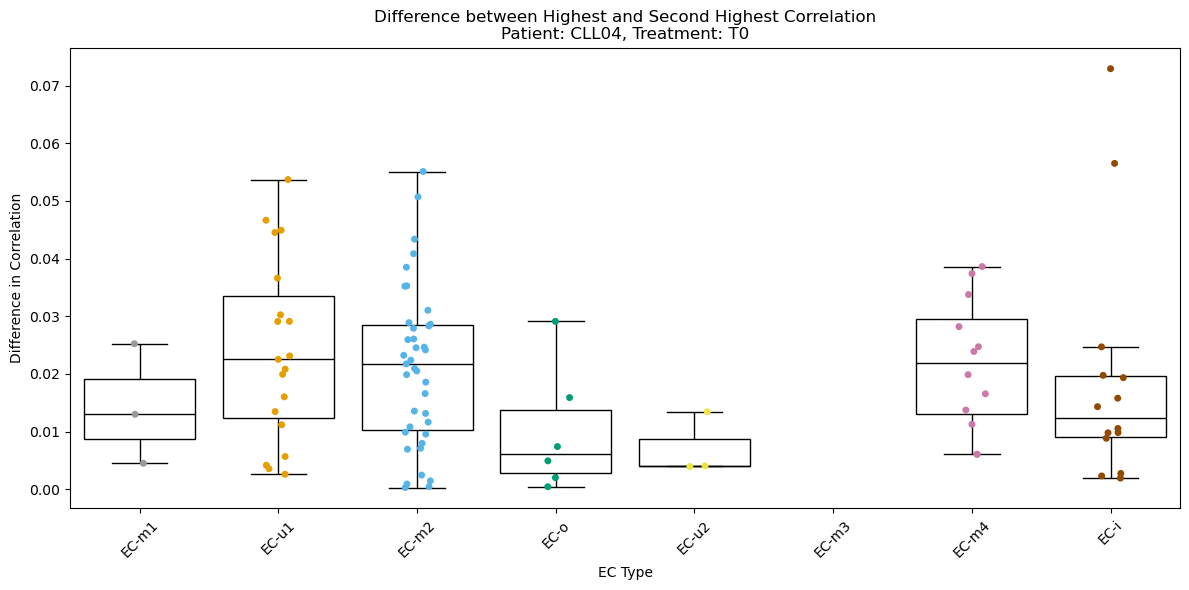

/tmp/ipykernel_2605329/307186147.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


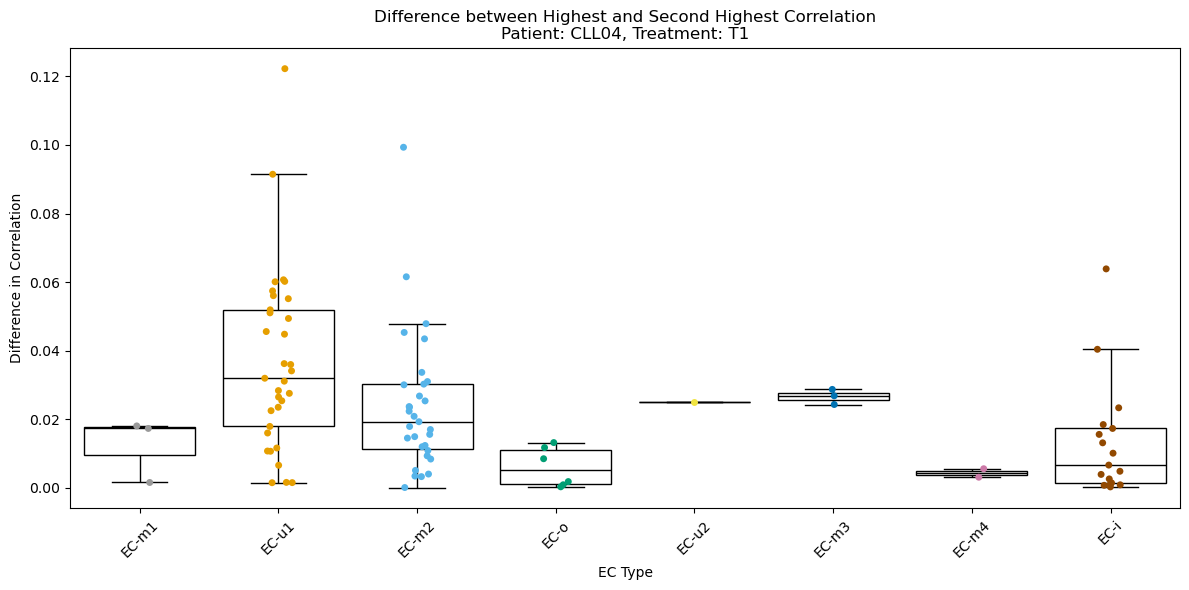

/tmp/ipykernel_2605329/307186147.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


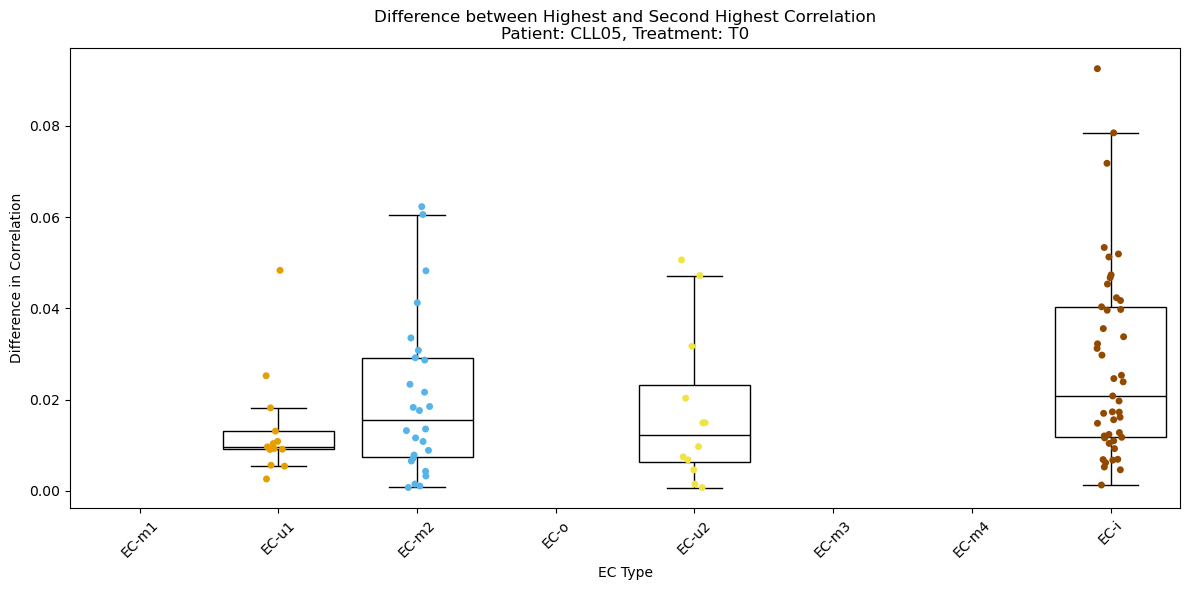

/tmp/ipykernel_2605329/307186147.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


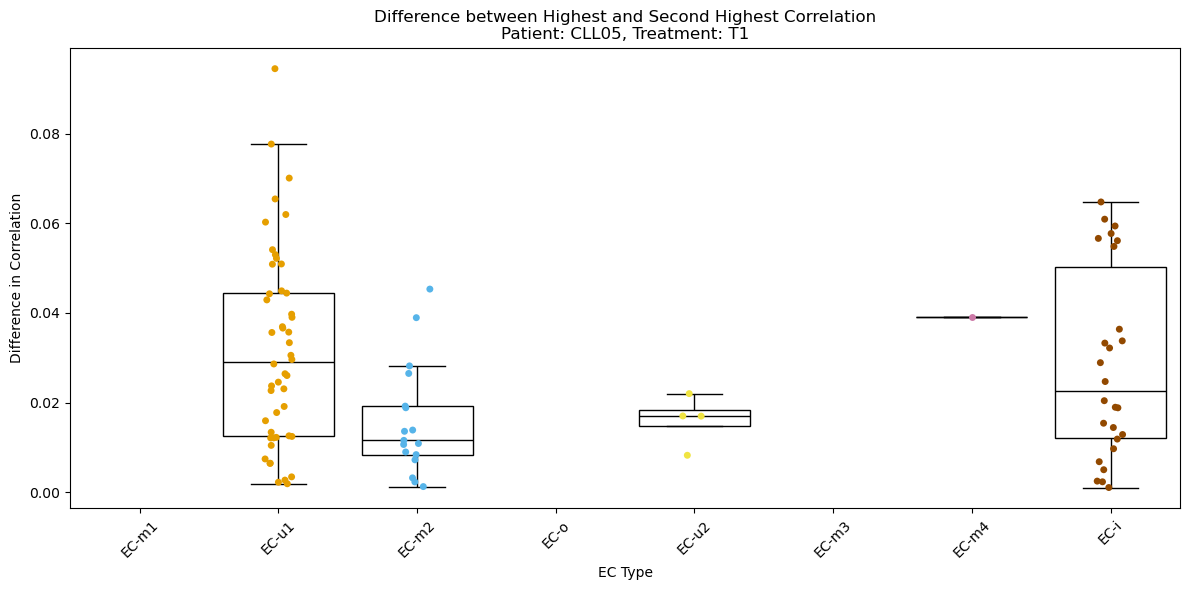

/tmp/ipykernel_2605329/307186147.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


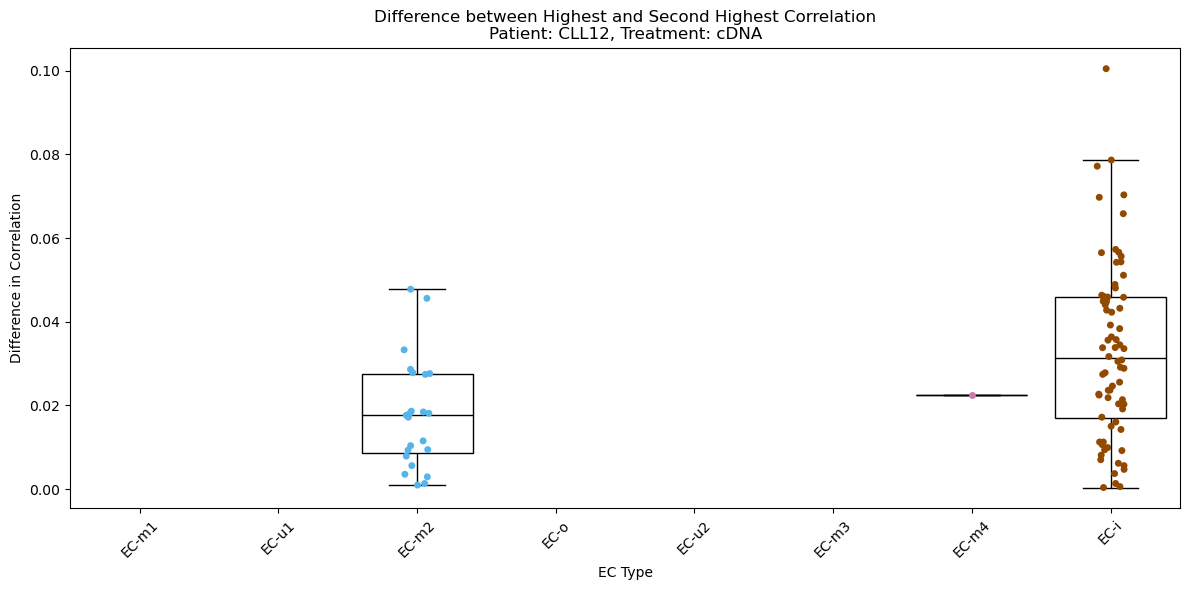

In [41]:
# Compute the differences between highest and second highest correlations
correlation_diff = pd.DataFrame(index=correlation_results.index, columns=['EC', 'Difference'])

for sample_id in correlation_results.index:
    valid_correlations = pd.to_numeric(correlation_results.loc[sample_id].dropna(), errors='coerce')
    if valid_correlations.size > 1:
        highest_corr = valid_correlations.nlargest(2)
        correlation_diff.loc[sample_id] = [highest_corr.index[0], highest_corr.iloc[0] - highest_corr.iloc[1]]
    elif valid_correlations.size == 1:
        correlation_diff.loc[sample_id] = [valid_correlations.index[0], valid_correlations.iloc[0]]
    else:
        correlation_diff.loc[sample_id] = [np.nan, np.nan]
        
# Extract patient and treatment information from cell_name
correlation_diff['Patient'] = correlation_diff.index.str.split('_').str[0]
correlation_diff['Treatment'] = correlation_diff.index.str.split('_').str[1]

# Convert the DataFrame to a format suitable for Seaborn boxplot
plot_data = correlation_diff.dropna().reset_index().rename(columns={'index': 'Sample'})

# Ensure EC types in plot_data match EC_NAMES
plot_data['EC'] = pd.Categorical(plot_data['EC'], categories=EC_NAMES, ordered=True)

# Plot the data for each patient and treatment
# for patient in plot_data['Patient'].unique():
#     for treatment in plot_data['Treatment'].unique():
#         subset_data = plot_data[(plot_data['Patient'] == patient) & (plot_data['Treatment'] == treatment)]
#         if not subset_data.empty:
#             plt.figure(figsize=(12, 6))
#             sns.boxplot(x='EC', y='Difference', data=subset_data, order=EC_NAMES, palette=EC_COLORS)
#             sns.stripplot(x='EC', y='Difference', data=subset_data, jitter=True, color='black', alpha=0.5, order=EC_NAMES)
#             plt.xlabel('EC Type')
#             plt.ylabel('Difference in Correlation')
#             plt.title(f'Difference between Highest and Second Highest Correlation\nPatient: {patient}, Treatment: {treatment}')
#             plt.xticks(rotation=45)
#             plt.tight_layout()
#             plt.show()

# Plot the data for each patient and treatment
for patient in plot_data['Patient'].unique():
    for treatment in plot_data['Treatment'].unique():
        subset_data = plot_data[(plot_data['Patient'] == patient) & (plot_data['Treatment'] == treatment)]
        if not subset_data.empty:
            plt.figure(figsize=(12, 6))
            # Boxplot with empty squares (only edges are visible)
            sns.boxplot(
                x='EC', y='Difference', data=subset_data, order=EC_NAMES,
                boxprops=dict(facecolor='white', edgecolor='black'),  # Empty squares
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                medianprops=dict(color='black'),
                showfliers=False  # Hide outliers in boxplot
            )
            # Stripplot with colored dots
            sns.stripplot(
                x='EC', y='Difference', data=subset_data, jitter=True, 
                palette=EC_COLORS, size=5, order=EC_NAMES
            )
            plt.xlabel('EC Type')
            plt.ylabel('Difference in Correlation')
            plt.title(f'Difference between Highest and Second Highest Correlation\nPatient: {patient}, Treatment: {treatment}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

In [1]:
# Plot the data for each patient and treatment
for patient in plot_data['Patient'].unique():
    for treatment in plot_data['Treatment'].unique():
        subset_data = plot_data[(plot_data['Patient'] == patient) & (plot_data['Treatment'] == treatment)]
        if not subset_data.empty:
            plt.figure(figsize=(12, 6))
            # Boxplot with empty squares (only edges are visible)
            sns.boxplot(
                x='EC', y='Difference', data=subset_data, order=EC_NAMES,
                boxprops=dict(facecolor='white', edgecolor='black'),  # Empty squares
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                medianprops=dict(color='black'),
                showfliers=False  # Hide outliers in boxplot
            )
            # Stripplot with colored dots
            sns.stripplot(
                x='EC', y='Difference', data=subset_data, jitter=True, 
                palette=EC_COLORS, size=5, order=EC_NAMES
            )
            plt.xlabel('EC Type')
            plt.ylabel('Difference in Correlation')
            plt.title(f'Difference between Highest and Second Highest Correlation\nPatient: {patient}, Treatment: {treatment}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

NameError: name 'plot_data' is not defined

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

# Load the normalized single-cell data
adata = sc.read_h5ad("raw_data/normalized_sc_cll_3ca.h5ad")

# Filter the data to keep only the relevant descriptions
descriptions_to_keep = [
    'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
    # Add all other descriptions you want to keep
]

adata_filtered = adata[:, adata.var.index.isin(descriptions_to_keep)]

# Extract EC profiles
ec_profiles = pd.DataFrame(adata_filtered.X.T, index=adata_filtered.var_names, columns=adata_filtered.obs['ec_name'])

# Compute Spearman correlations and store them in a DataFrame
correlation_results = pd.DataFrame(index=adata_filtered.obs.index, columns=ec_profiles.columns)

def compute_spearman_correlations(sample_expression, ec_profiles):
    correlations = {}
    for ec_type in ec_profiles.columns:
        ec_expression = ec_profiles[ec_type]
        if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
            correlations[ec_type] = np.nan
        elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0:
            correlations[ec_type] = np.nan
        else:
            correlation, _ = spearmanr(sample_expression, ec_expression)
            correlations[ec_type] = correlation
    return correlations

for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

# Create a DataFrame to store the highest EC type per sample
closest_ec_types_per_sample = {}
highest_correlation_list = []

for sample_id in correlation_results.index:
    valid_correlations = correlation_results.loc[sample_id].dropna()
    if not valid_correlations.empty:
        highest_ec_type = valid_correlations.idxmax()
        highest_correlation = valid_correlations[highest_ec_type]
        highest_correlation_list.append(highest_correlation)
        close_ec_types = valid_correlations[valid_correlations >= highest_correlation].index.tolist()
        closest_ec_types_per_sample[sample_id] = close_ec_types

# Aggregate the data to prepare for plotting
df_plot = pd.DataFrame(list(closest_ec_types_per_sample.items()), columns=['sample_id', 'closest_ec_types'])
df_plot = df_plot.explode('closest_ec_types')

# Count the occurrences of each EC type for each sample_id
df_counts = df_plot.groupby(['sample_id', 'closest_ec_types']).size().unstack(fill_value=0)

# Plot the data for each patient
for sample_id in df_counts.index:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=df_counts.columns, y=df_counts.loc[sample_id], palette=EC_COLORS)
    plt.title(f'Distribution of EC Types for Patient: {sample_id}')
    plt.ylabel('Spearman correlation')
    plt.xlabel('EC_Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


KeyError: 'ec_name'

In [ ]:
# Check the columns in adata_filtered.obs
print(adata_filtered.obs.columns)

Index(['sample', 'patient', 'sample_status', 'complexity'], dtype='object')


/tmp/ipykernel_894630/118426027.py:55: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_filtered.obs['highest_ec_type'] = highest_ec_type
/tmp/ipykernel_894630/118426027.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_data.index, y=patient_data.values, palette=EC_COLOR_LIST)


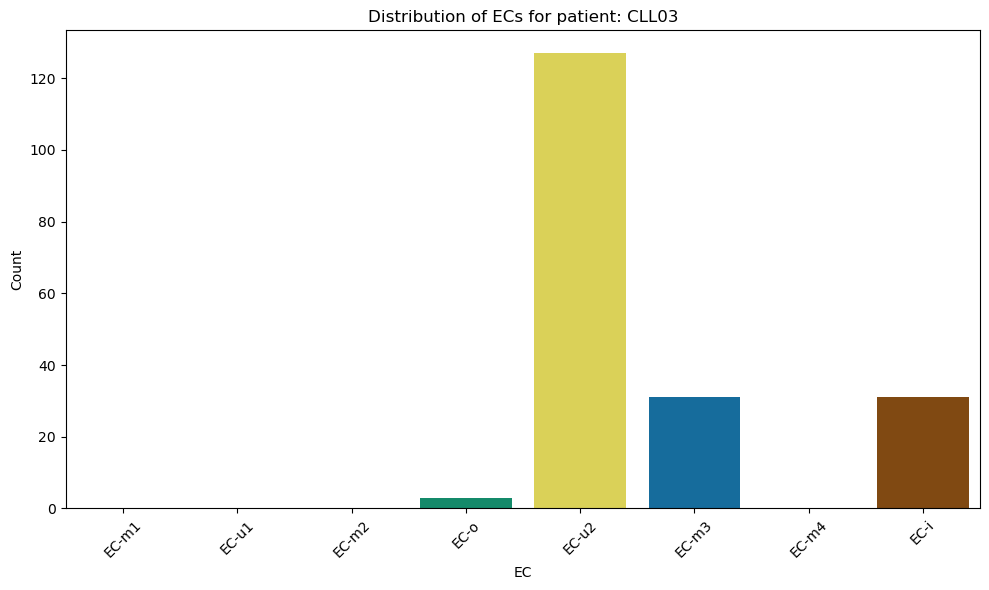

/tmp/ipykernel_894630/118426027.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_data.index, y=patient_data.values, palette=EC_COLOR_LIST)


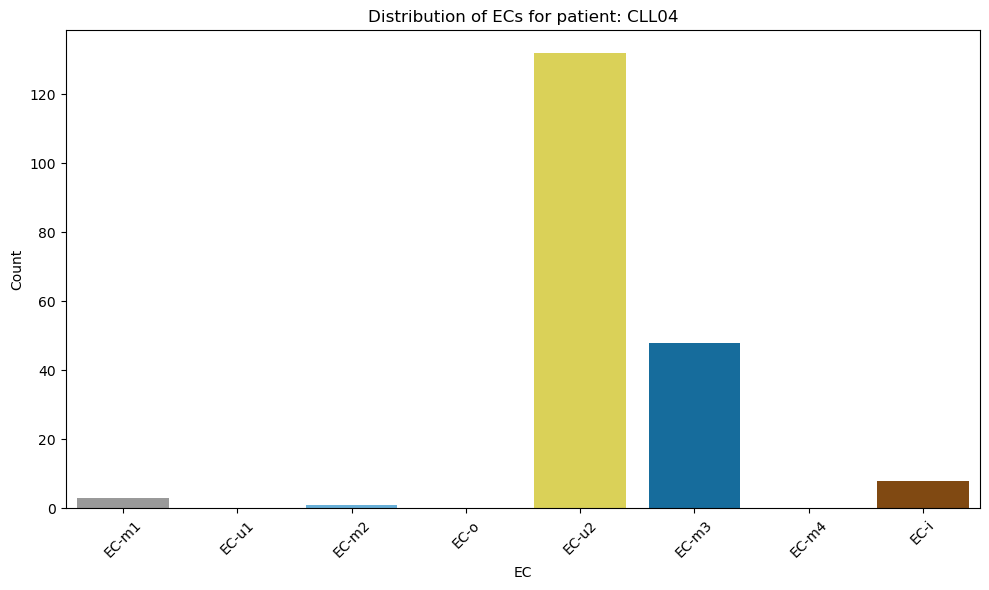

/tmp/ipykernel_894630/118426027.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_data.index, y=patient_data.values, palette=EC_COLOR_LIST)


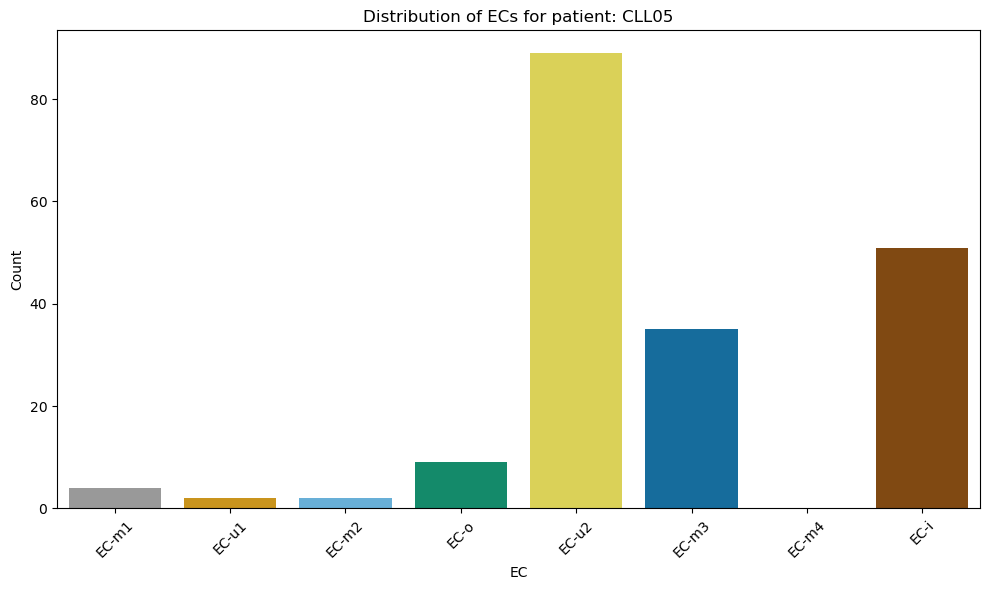

/tmp/ipykernel_894630/118426027.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_data.index, y=patient_data.values, palette=EC_COLOR_LIST)


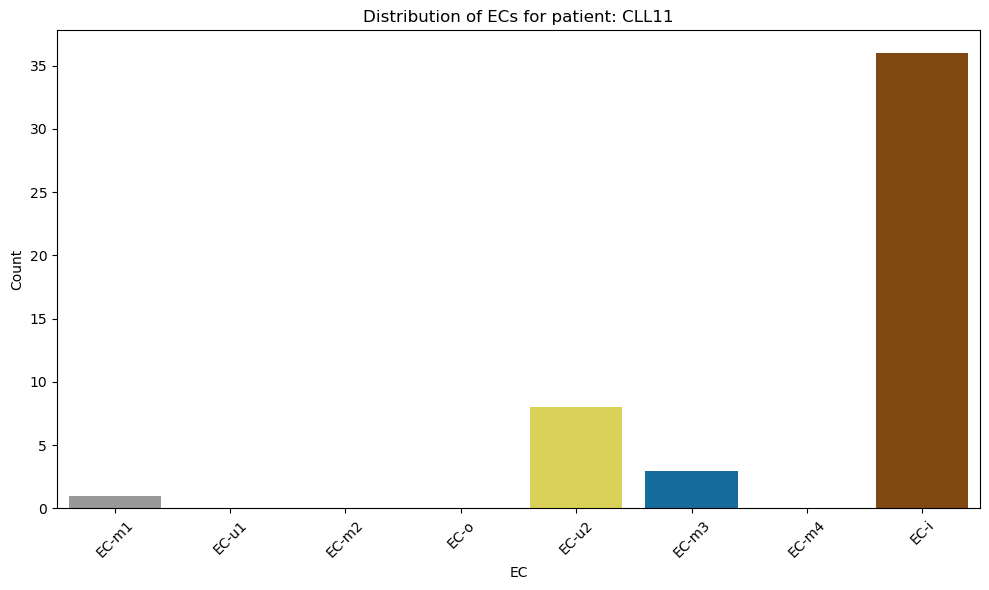

/tmp/ipykernel_894630/118426027.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patient_data.index, y=patient_data.values, palette=EC_COLOR_LIST)


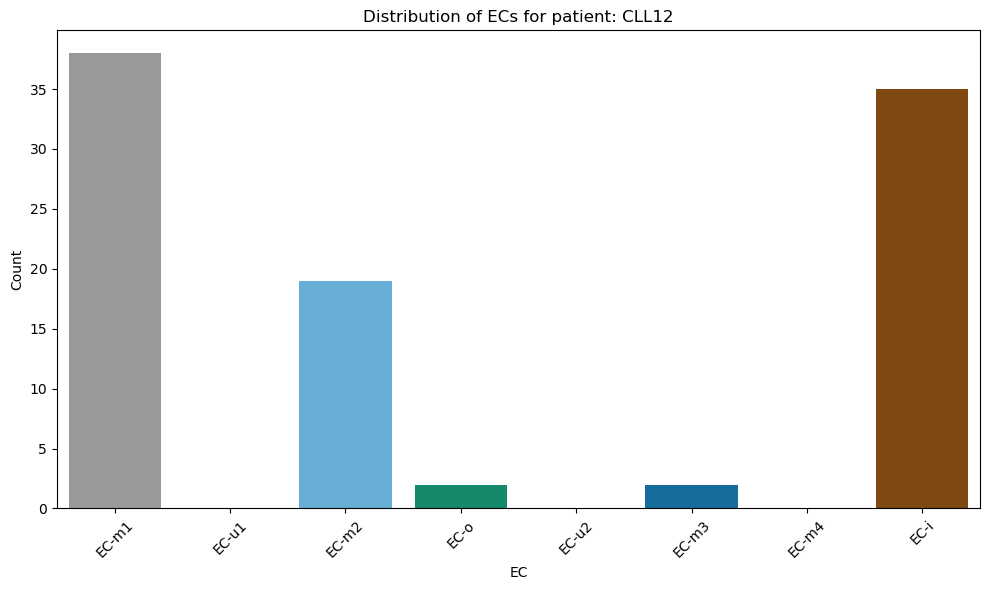

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.stats import spearmanr

# Load the normalized single-cell data
adata = sc.read_h5ad("raw_data/normalized_sc_cll_3ca.h5ad")

descriptions_to_keep = [
    'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
    # (continue with other gene names)
    'ZNF471', 'KCNH2', 'COBLL1', 'SOWAHC', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
    'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
    # Add all other descriptions you want to keep
]

# Filter the AnnData object
adata_filtered = adata[:, adata.var.index.isin(descriptions_to_keep)]

# Assuming you have an EC profile matrix to correlate against:
ec_profiles = pd.DataFrame(
    np.random.rand(len(descriptions_to_keep), 8),  # Dummy data; replace with your EC profiles
    index=descriptions_to_keep, 
    columns=["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
)

# Compute Spearman correlation for each cell
correlation_results = pd.DataFrame(index=adata_filtered.obs.index, columns=ec_profiles.columns)

def compute_spearman_correlations(sample_expression, ec_profiles):
    correlations = {}
    for ec_type in ec_profiles.columns:
        ec_expression = ec_profiles[ec_type]
        if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
            correlations[ec_type] = np.nan
        elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0:
            correlations[ec_type] = np.nan
        else:
            correlation, _ = spearmanr(sample_expression, ec_expression)
            correlations[ec_type] = correlation
    return correlations

for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

# Find the EC type with the highest correlation for each cell
highest_ec_type = correlation_results.idxmax(axis=1)

# Merge the highest EC type with the patient information
adata_filtered.obs['highest_ec_type'] = highest_ec_type
df_plot = adata_filtered.obs[['patient', 'highest_ec_type']]

# Plot the distribution of EC types for each patient
for patient in df_plot['patient'].unique():
    plt.figure(figsize=(10, 6))
    patient_data = df_plot[df_plot['patient'] == patient]['highest_ec_type'].value_counts().reindex(ec_profiles.columns, fill_value=0)
    sns.barplot(x=patient_data.index, y=patient_data.values, palette=EC_COLOR_LIST)
    plt.title(f'Distribution of ECs for patient: {patient}')
    plt.xlabel('EC')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
adata.obs

sample patient  sample_status  complexity
cell_name                                                                     
CLL03_T0_cDNA_A10_S202  CLL03_pre_treatment   CLL03  pre_treatment        4941
CLL03_T0_cDNA_A11_S203  CLL03_pre_treatment   CLL03  pre_treatment        6307
CLL03_T0_cDNA_A12_S204  CLL03_pre_treatment   CLL03  pre_treatment        2939
CLL03_T0_cDNA_A1_S193   CLL03_pre_treatment   CLL03  pre_treatment        7023
CLL03_T0_cDNA_A2_S194   CLL03_pre_treatment   CLL03  pre_treatment        6222
...                                     ...     ...            ...         ...
CLL12_cDNA_H5_S185      CLL12_pre_treatment   CLL12  pre_treatment        1961
CLL12_cDNA_H6_S186      CLL12_pre_treatment   CLL12  pre_treatment        5563
CLL12_cDNA_H7_S187      CLL12_pre_treatment   CLL12  pre_treatment        5844
CLL12_cDNA_H9_S189      CLL12_pre_treatment   CLL12  pre_treatment        3733
CLL12_cDNA_H8_S188      CLL12_pre_treatment   CLL12  pre_treatment        4361

[720 rows x 4 columns]

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

# Load the data from your AnnData object
adata = sc.read_h5ad("raw_data/normalized_sc_cll_3ca.h5ad")

# Extract necessary information
sample_to_ec_type = pd.DataFrame({
    'sample_id': adata.obs_names,
    'EC_type': adata.obs['ec_name']  # Assuming 'ec_name' contains the EC type
})

# Extract CLL_Type (first 5 characters of sample_id)
sample_to_ec_type['CLL_Type'] = sample_to_ec_type['sample_id'].apply(lambda x: x[:5])

# Set the category order for EC_Type
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
sample_to_ec_type['EC_type'] = pd.Categorical(sample_to_ec_type['EC_type'], categories=EC_NAMES, ordered=True)

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))

# Combine all dictionaries into a single comprehensive dictionary
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# Plot the data without considering treatment
for cll_type in sample_to_ec_type['CLL_Type'].unique():
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(
        x='EC', 
        data=sample_to_ec_type[sample_to_ec_type['CLL_Type'] == cll_type], 
        palette=EC_COLORS
    )
    plt.title(f'Distribution of ECs for CLL Type: {cll_type}')
    
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

KeyError: 'ec_name'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame to map each sample to its highest EC type
sample_to_ec_type = pd.DataFrame(list(closest_ec_types_per_sample.items()), columns=['Sample', 'EC_Type'])

# Extract CLL_Type and Treatment information from the Sample column
sample_to_ec_type['CLL_Type'] = sample_to_ec_type['Sample'].apply(lambda x: x[:5])
sample_to_ec_type['Treatment'] = sample_to_ec_type['Sample'].apply(lambda x: x.split('_')[1])

# Set the category order for EC_Type
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
sample_to_ec_type['EC_Type'] = pd.Categorical(sample_to_ec_type['EC_Type'], categories=EC_NAMES, ordered=True)

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))

# Combine all dictionaries into a single comprehensive dictionary
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# Simulated data for correlation values
# In practice, replace this with your actual correlation calculations
np.random.seed(42)
sample_to_ec_type['Correlation'] = np.random.rand(len(sample_to_ec_type))

# Plot the data
for cll_type in sample_to_ec_type['CLL_Type'].unique():
    for treatment in sample_to_ec_type[sample_to_ec_type['CLL_Type'] == cll_type]['Treatment'].unique():
        plt.figure(figsize=(8, 5))
        subset = sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)]
        ax = sns.boxplot(x='EC_Type', y='Correlation', data=subset, palette=EC_COLORS)
        plt.title(f'Distribution of Correlations for CLL Type: {cll_type}, Treatment: {treatment}')
        plt.xlabel('EC Type')
        plt.ylabel('Correlation')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

TypeError: unhashable type: 'list'

In [ ]:
tpms_603samps_deseqLog10_batchcorr = pd.read_csv(path + "cll_tables/cllmap_rnaseq_tpms_603samps_deseqLog10_batchcorr.tsv", sep="\t")
print(tpms_603samps_deseqLog10_batchcorr.columns)

Index(['Name', 'Description', 'SCLL-0003', 'SCLL-0004', 'SCLL-0005',
       'SCLL-0007', 'SCLL-0008', 'SCLL-0009', 'SCLL-0010', 'SCLL-0012',
       ...
       'GCLL-0176', 'GCLL-0183', 'GCLL-0247', 'GCLL-0248', 'GCLL-0292',
       'GCLL-0296', 'GCLL-0300', 'GCLL-0314', 'JB-0015', 'NHLBI-0053'],
      dtype='object', length=605)


In [ ]:
# Load the original data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix

# Load the original data
check = sc.read_h5ad("ECs_allGens_tpm.h5ad")
check

AnnData object with n_obs × n_vars = 603 × 102
    var: 'Name'

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Provided code
adata_avg_dict = {}

# Step 1: Calculate average expression for each subset
for ec_type, adata_subset in adata_dict.items():
    avg_expression = np.mean(adata_subset.X, axis=0)  # Calculate the average expression for each gene
    avg_expression = avg_expression.reshape(1, -1)  # Reshape to keep 2D structure
    adata_avg = sc.AnnData(X=avg_expression, var=adata_subset.var.copy())  # Create a new AnnData object
    adata_avg.obs['ec_name'] = [ec_type]  # Add EC type to obs
    adata_avg_dict[ec_type] = adata_avg

# Combine the individual AnnData objects into one
adata_combined = sc.concat(adata_avg_dict.values(), join='outer', merge='same')

# Create a DataFrame for easier handling
df = pd.DataFrame(data=adata_combined.X.T, index=adata_combined.var.index, columns=adata_combined.obs['ec_name'])

# Calculate the average TPM across all EC types
avg_tpm = df.mean(axis=1)

# Filter out genes with an average TPM of over 10
filtered_genes = avg_tpm[avg_tpm >= 10].index
df_filtered = df.loc[filtered_genes]

# Ensure all values in df are finite
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Ensure all values in df_filtered are finite
df_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)
df_filtered.fillna(0, inplace=True)

# Define the desired order for the columns
desired_order = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]

# Reorder the columns
df = df[desired_order]
df_filtered = df_filtered[desired_order]

# Initialize a dictionary to store upregulated and downregulated genes for each EC
genes_per_ec = {'Up': {}, 'Down': {}}

# For each EC type, find the upregulated and downregulated genes
for ec_type in desired_order:
    ec_data = df_filtered[ec_type]
    up_genes = ec_data[ec_data >= 10].index.tolist()
    down_genes = ec_data[ec_data < 10].index.tolist()
    
    genes_per_ec['Up'][ec_type] = up_genes
    genes_per_ec['Down'][ec_type] = down_genes

# Print the upregulated and downregulated genes for each EC type
for ec_type in desired_order:
    print(f"EC Type: {ec_type}")
    print("Upregulated genes with TPM >= 10:")
    print(genes_per_ec['Up'][ec_type])
    print("Downregulated genes with TPM < 10:")
    print(genes_per_ec['Down'][ec_type])
    print("\n")


EC Type: EC-m1
Upregulated genes with TPM >= 10:
['SH3D21', 'C1orf162', 'SEMA4A', 'FCRL3', 'FCRL2', 'MNDA', 'FCER1G', 'FMOD', 'FAM49A', 'MAP4K4', 'COBLL1', 'CTLA4', 'LEF1', 'TBC1D9', 'MYLIP', 'AEBP1', 'TFEC', 'CNTNAP2', 'KCNH2', 'MYBL1', 'PIP5K1B', 'DUSP5', 'FADS3', 'SESN3', 'RIMKLB', 'LRRK2', 'HIP1R', 'VPS37B', 'ACSM3', 'ITGAX', 'P2RX1', 'TUBG2', 'MYL9', 'SAMSN1', 'APP', 'SIK1', 'COL18A1', 'CYBB', 'PHF16', 'ZMAT1', 'BEX4']
Downregulated genes with TPM < 10:
['CD1C', 'EML6', 'TSPAN13', 'MS4A4E', 'BCL7A', 'GNAO1', 'CEACAM1', 'HCK', 'TOX2']


EC Type: EC-u1
Upregulated genes with TPM >= 10:
['SH3D21', 'C1orf162', 'SEMA4A', 'FCRL3', 'FCRL2', 'MNDA', 'FCER1G', 'FMOD', 'FAM49A', 'MAP4K4', 'COBLL1', 'CTLA4', 'LEF1', 'TBC1D9', 'MYLIP', 'TSPAN13', 'AEBP1', 'CNTNAP2', 'KCNH2', 'DUSP5', 'MS4A4E', 'FADS3', 'SESN3', 'RIMKLB', 'LRRK2', 'BCL7A', 'HIP1R', 'ACSM3', 'ITGAX', 'P2RX1', 'TUBG2', 'CEACAM1', 'HCK', 'MYL9', 'TOX2', 'SAMSN1', 'APP', 'SIK1', 'COL18A1', 'CYBB', 'PHF16', 'ZMAT1', 'BEX4']
Downreg

/data01/home/ls/sarahl/miniforge3/envs/proj/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.stats import spearmanr

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))

# Combine all dictionaries into a single comprehensive dictionary
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# Define the desired order for the columns
desired_order = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]

# Load the normalized single-cell data
check = sc.read_h5ad("raw_data/normalized_sc_cll_3ca.h5ad")

descriptions_to_keep = [
    'P2RX1', 'TFEC', 'C1orf162', 'COL18A1', 'BEX4', 'NRIP1', 'APP', 'SLC19A1',
    'ZNF471', 'KCNH2', 'COBLL1', 'SOWAHC', 'MNDA', 'LDOC1', 'FCRL3', 'LPL',
    'FAM49A', 'KANK2', 'FCRL2', 'WNT9A', 'SH3D21', 'FMOD', 'HCK',
    'LEF1', 'CD1C', 'SEMA4A', 'VPS37B', 'CTLA4', 'CYBB', 'TOX2', 'MYLIP',
    'ACSM3', 'PIP5K1B', 'TBC1D9', 'SIK1', 'SESN3', 'DUSP5',
    'ARSI', 'TUBG2', 'BCL7A', 'ZNF804A', 'ITGB5', 'GPR34', 'TSPAN13',
    'PPP1R9A', 'SLC12A7', 'MAP4K4', 'MS4A4E', 'LRRK2', 'MYL9', 'SAMSN1', 'NT5E',
    'CEACAM1', 'MS4A6A', 'PHF16', 'CNTNAP2', 'AEBP1', 'MYBL1', 'HIP1R', 'NUGGC',
    'RIMKLB', 'GNAO1', 'EML6', 'CD80', 'FADS3', 'ADAM29', 'ITGAX', 'GRIK3',
    'ZMAT1', 'FCER1G', 'DPF3', 'GADD45A', 'GPHN', 'MYO3A', 'PTK2', 'WWC1', 'TSHZ2'
]

adata_filtered = check[:, check.var.index.isin(descriptions_to_keep)]

# Step 1: Subset the AnnData object to include only the sample 'CRC-0004'
ec_profiles = pd.DataFrame(adata_filtered.X.T, index=adata_filtered.var_names, columns=adata_filtered.obs['ec_name'])

# Step 2: Compute Spearman correlation for each sample
# Create a DataFrame to store the correlation results
correlation_results = pd.DataFrame(index=adata_filtered.obs.index, columns=ec_profiles.columns)

def compute_spearman_correlations(sample_expression, ec_profiles):
    correlations = {}
    for ec_type in ec_profiles.columns:
        ec_expression = ec_profiles[ec_type]
        # Check if there are NaNs in the data
        if np.any(np.isnan(sample_expression)) or np.any(np.isnan(ec_expression)):
            correlations[ec_type] = np.nan
        # Check if the data is constant
        elif np.std(sample_expression) == 0 or np.std(ec_expression) == 0:
            correlations[ec_type] = np.nan
        else:
            correlation, _ = spearmanr(sample_expression, ec_expression)
            correlations[ec_type] = correlation
    return correlations

# Iterate over each sample in the AnnData object
for sample_id in adata_filtered.obs.index:
    sample_expression = adata_filtered[sample_id, :].X.toarray().flatten()
    correlations = compute_spearman_correlations(sample_expression, ec_profiles)
    for ec_type, correlation in correlations.items():
        correlation_results.loc[sample_id, ec_type] = correlation

# Dictionary to store the highest and second highest EC types for each sample
ec_correlations_per_sample = {}
for sample_id in correlation_results.index:
    # Remove NaN values before identifying the highest correlations
    valid_correlations = correlation_results.loc[sample_id].dropna()
    if not valid_correlations.empty:
        sorted_correlations = valid_correlations.sort_values(ascending=False)
        highest_ec_type = sorted_correlations.index[0]
        highest_correlation = sorted_correlations.iloc[0]
        if len(sorted_correlations) > 1:
            second_highest_ec_type = sorted_correlations.index[1]
            second_highest_correlation = sorted_correlations.iloc[1]
        else:
            second_highest_ec_type = None
            second_highest_correlation = None
        ec_correlations_per_sample[sample_id] = {
            "highest_ec_type": highest_ec_type,
            "highest_correlation": highest_correlation,
            "second_highest_ec_type": second_highest_ec_type,
            "second_highest_correlation": second_highest_correlation
        }

# Display the correlation results and closest EC types
print("\nEC Correlations per sample:")
for sample_id, correlations in ec_correlations_per_sample.items():
    print(f"{sample_id}: Highest: {correlations['highest_ec_type']} ({correlations['highest_correlation']:.4f}), "
          f"Second Highest: {correlations['second_highest_ec_type']} ({correlations['second_highest_correlation']:.4f})")


KeyError: 'ec_name'